# Analysis of Leios simulations at tag `leios-2025w15`

## Load dependencies

In [1]:
suppressMessages({
    require(bit64, quietly=TRUE)
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
    require(mongolite, quietly=TRUE)
    require(R.utils, quietly=TRUE)
    require(stringr, quietly=TRUE)
})

## 100-Node Network

### Receipt of messages

#### Read results

In [2]:
receipts <- fread("results/receipts.csv.gz", stringsAsFactors=TRUE)
receipts %>% summary

   simulator            label               network        
 haskell:11032258   default:17999000   100-nodes:17999000  
 rust   : 6966742                                          
                                                           
                                                           
                                                           
                                                           
                                                           
 ib-generation-probability ib-body-avg-size-bytes eb-generation-probability
 Min.   : 1.000            Min.   :98304          Min.   :1.5              
 1st Qu.: 4.500            1st Qu.:98304          1st Qu.:1.5              
 Median : 7.000            Median :98304          Median :1.5              
 Mean   : 6.434            Mean   :98304          Mean   :1.5              
 3rd Qu.: 8.500            3rd Qu.:98304          3rd Qu.:1.5              
 Max.   :10.000            Max.   :98304          Max.   :1.5   

#### Scenarios present in dataset

In [3]:
receipts[, .(`Records`=.N), by=.(`simulator`, `network`, `label`)]

simulator,network,label,Records
<fct>,<fct>,<fct>,<int>
rust,100-nodes,default,6966742
haskell,100-nodes,default,11032258


In [4]:
label <- receipts[, paste0(`network`, " network, ", `leios-stage-length-slots`, "-slot stages, ", `ib-body-avg-size-bytes`, " kB/IB") %>% unique]
label

[1] "100-nodes network, 20-slot stages, 98304 kB/IB"

In [5]:
ibRateLevels <- paste(receipts[, sort(unique(`ib-generation-probability`), decreasing=TRUE)], "IB/s")
ibRateFactor <- function(ibRate) factor(paste(ibRate, "IB/s"), levels=ibRateLevels)
ibRates <- 2*1:5

In [6]:
kinds <- receipts[, unique(`kind`) %>% sort]
kinds

[1] EB IB RB VT
Levels: EB IB RB VT

#### Compare the distributions of elapsed times

In [7]:
receiptScenario <- receipts[
    order(`simulator`, `label`, `network`, `leios-stage-length-slots`, `ib-generation-probability`, `ib-body-avg-size-bytes`, `eb-generation-probability`)
][
    !is.na(`elapsed`),
    .(`elapsed`),
    .(
        `simulator`,
        `scenario`=paste(`label`, `network`, `leios-stage-length-slots`, `ib-generation-probability`, `ib-body-avg-size-bytes`, `eb-generation-probability`, sep=" | "),
        `kind`
    )
]

In [8]:
options(repr.plot.width=20, repr.plot.height=15)

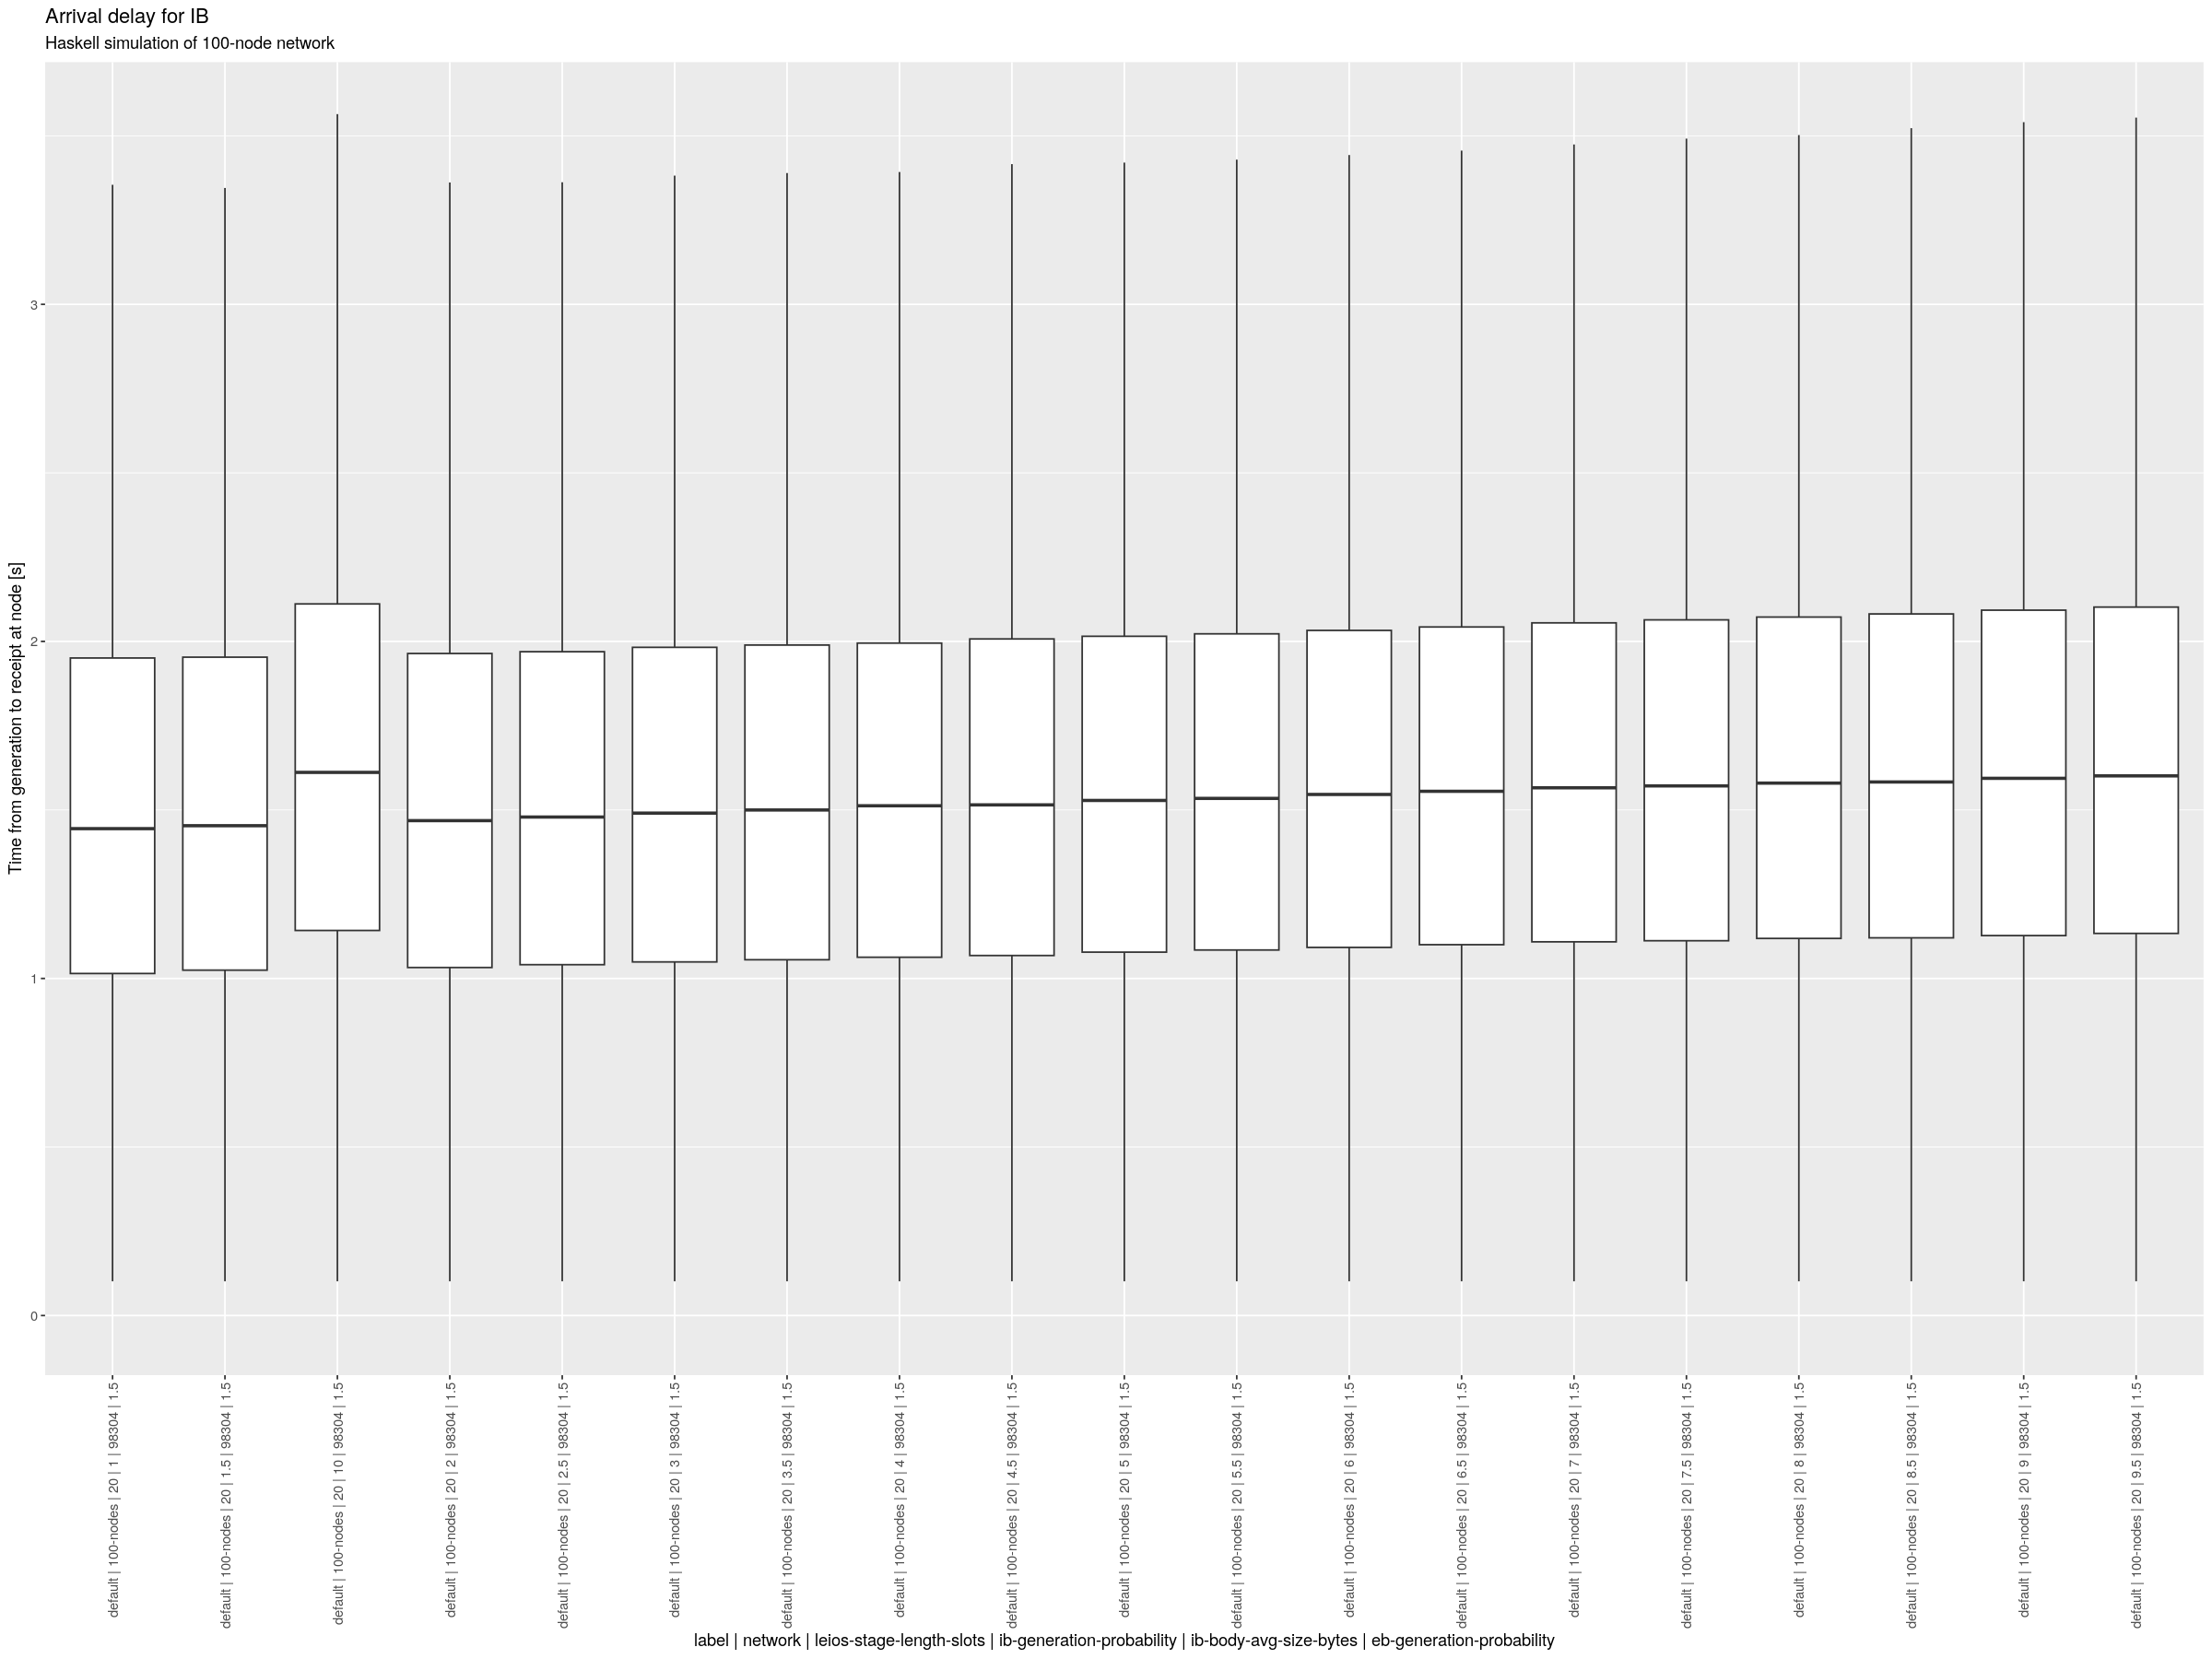

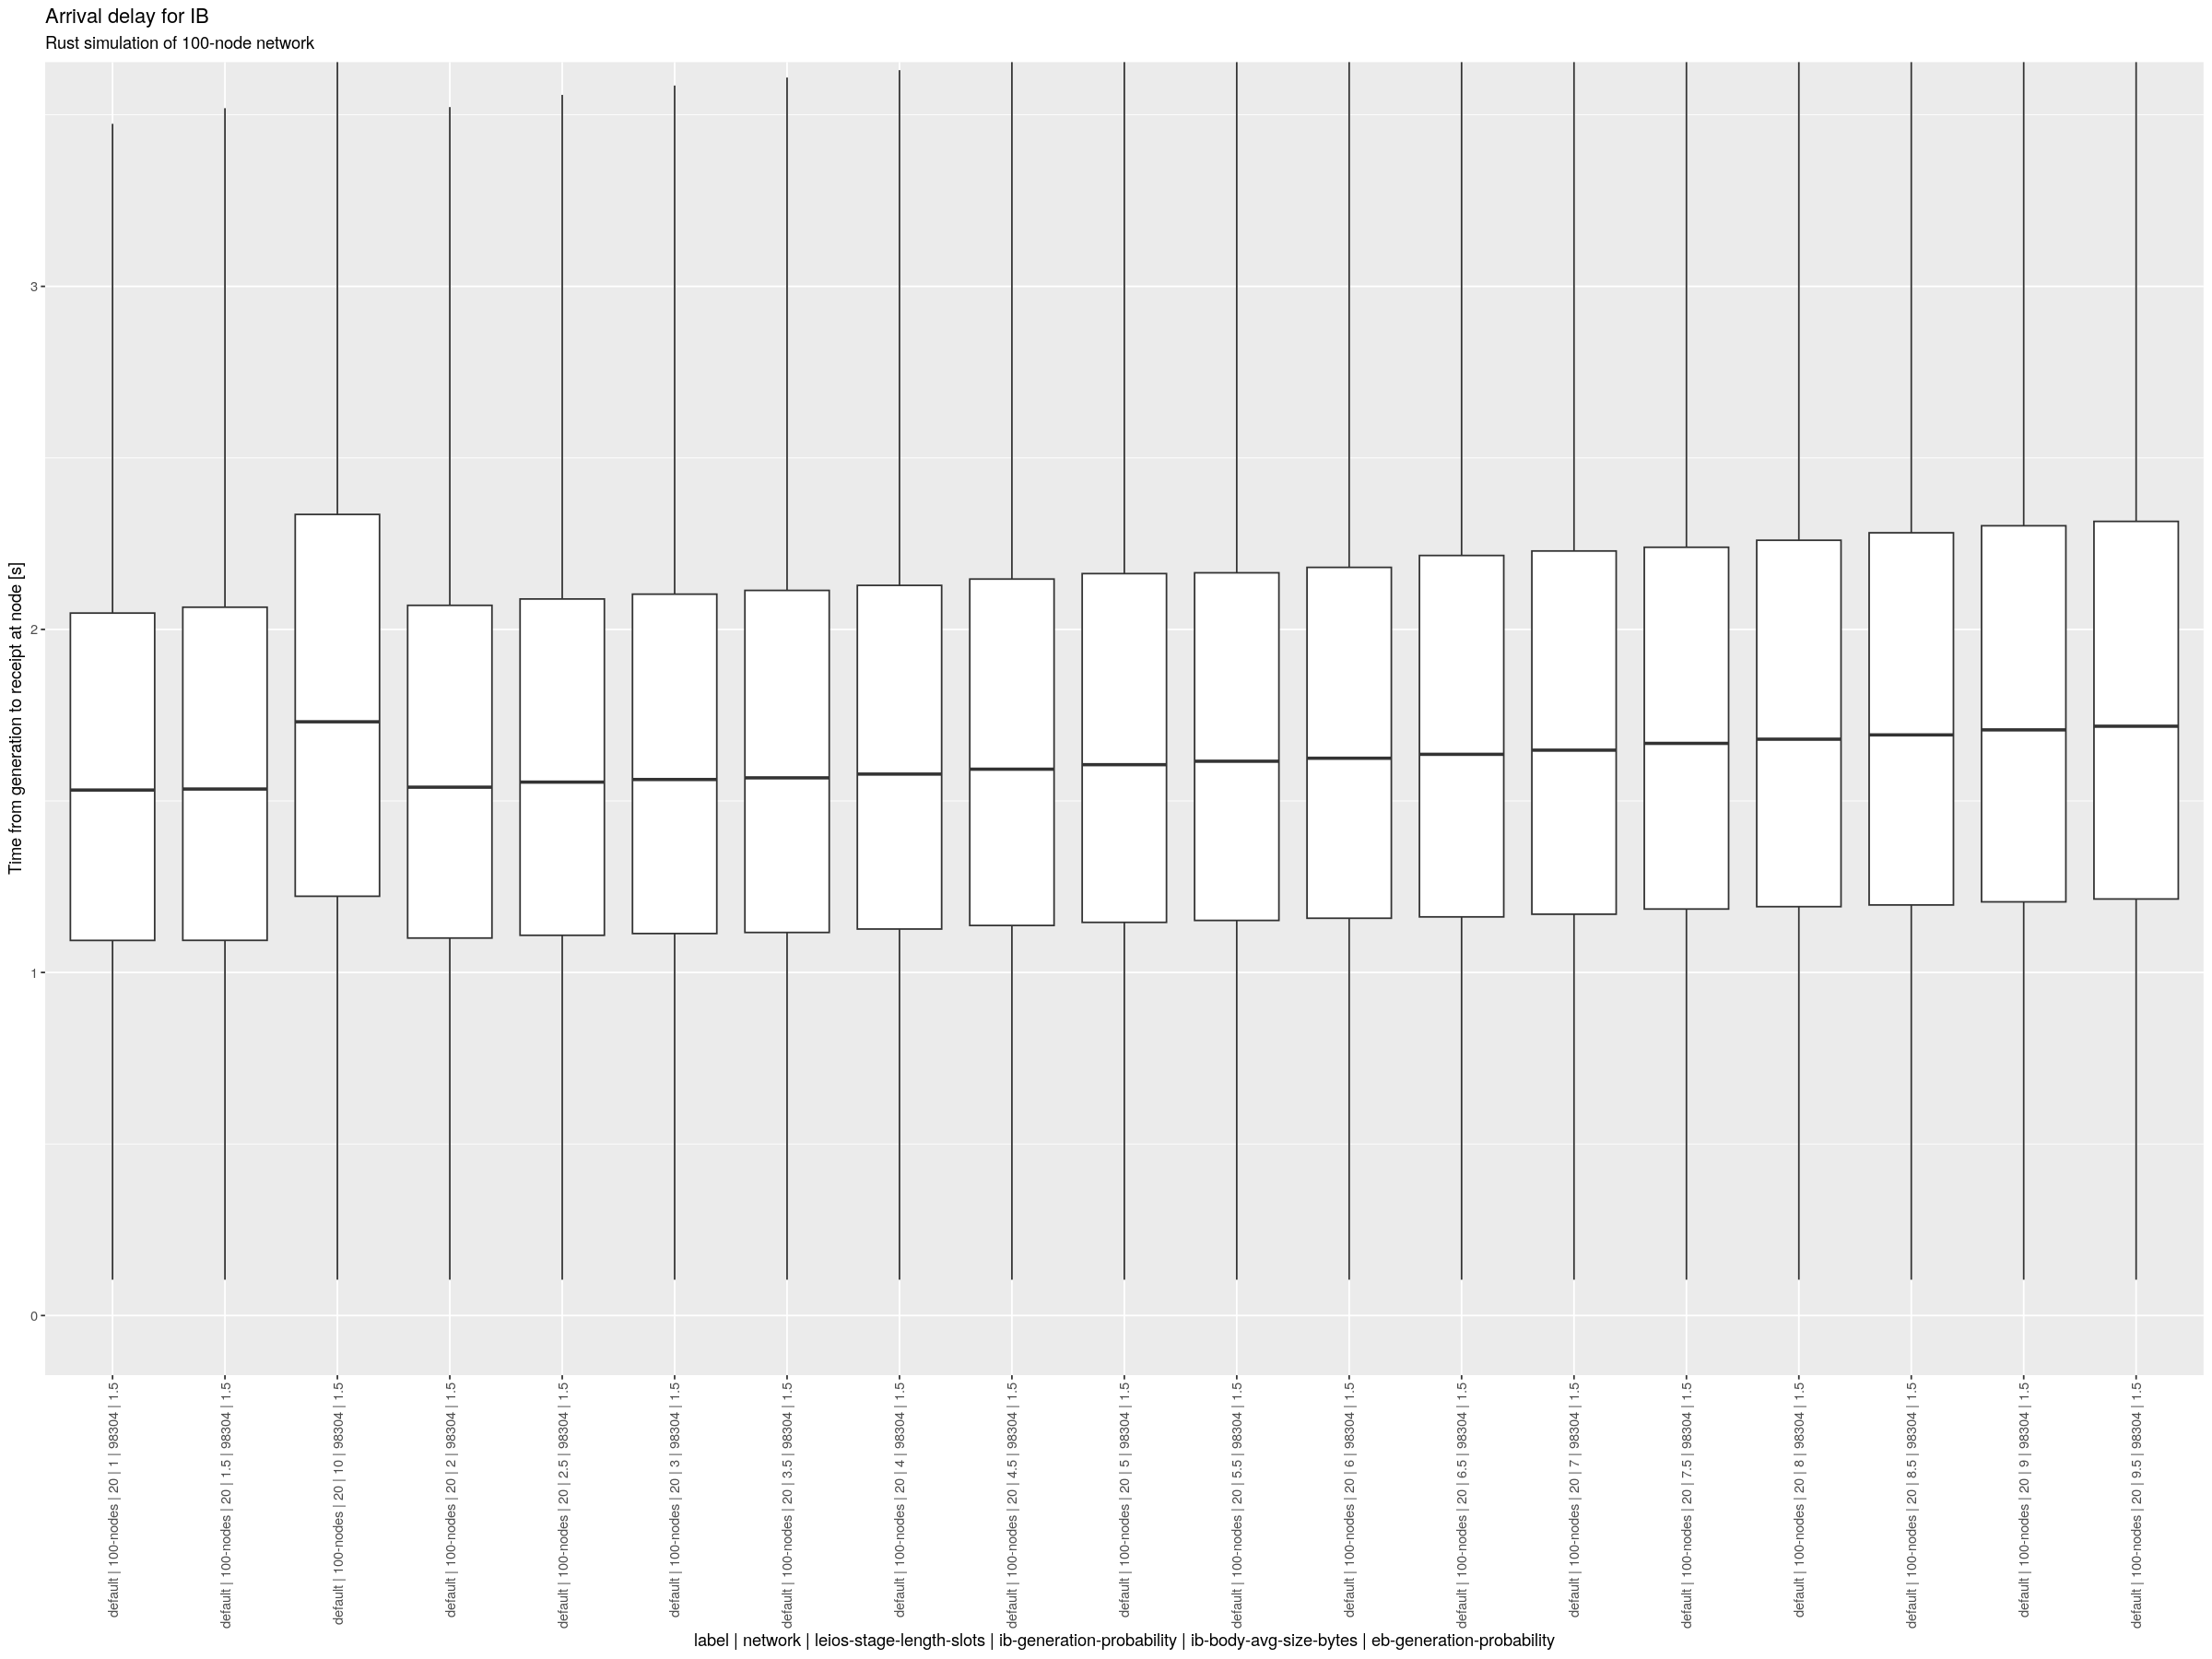

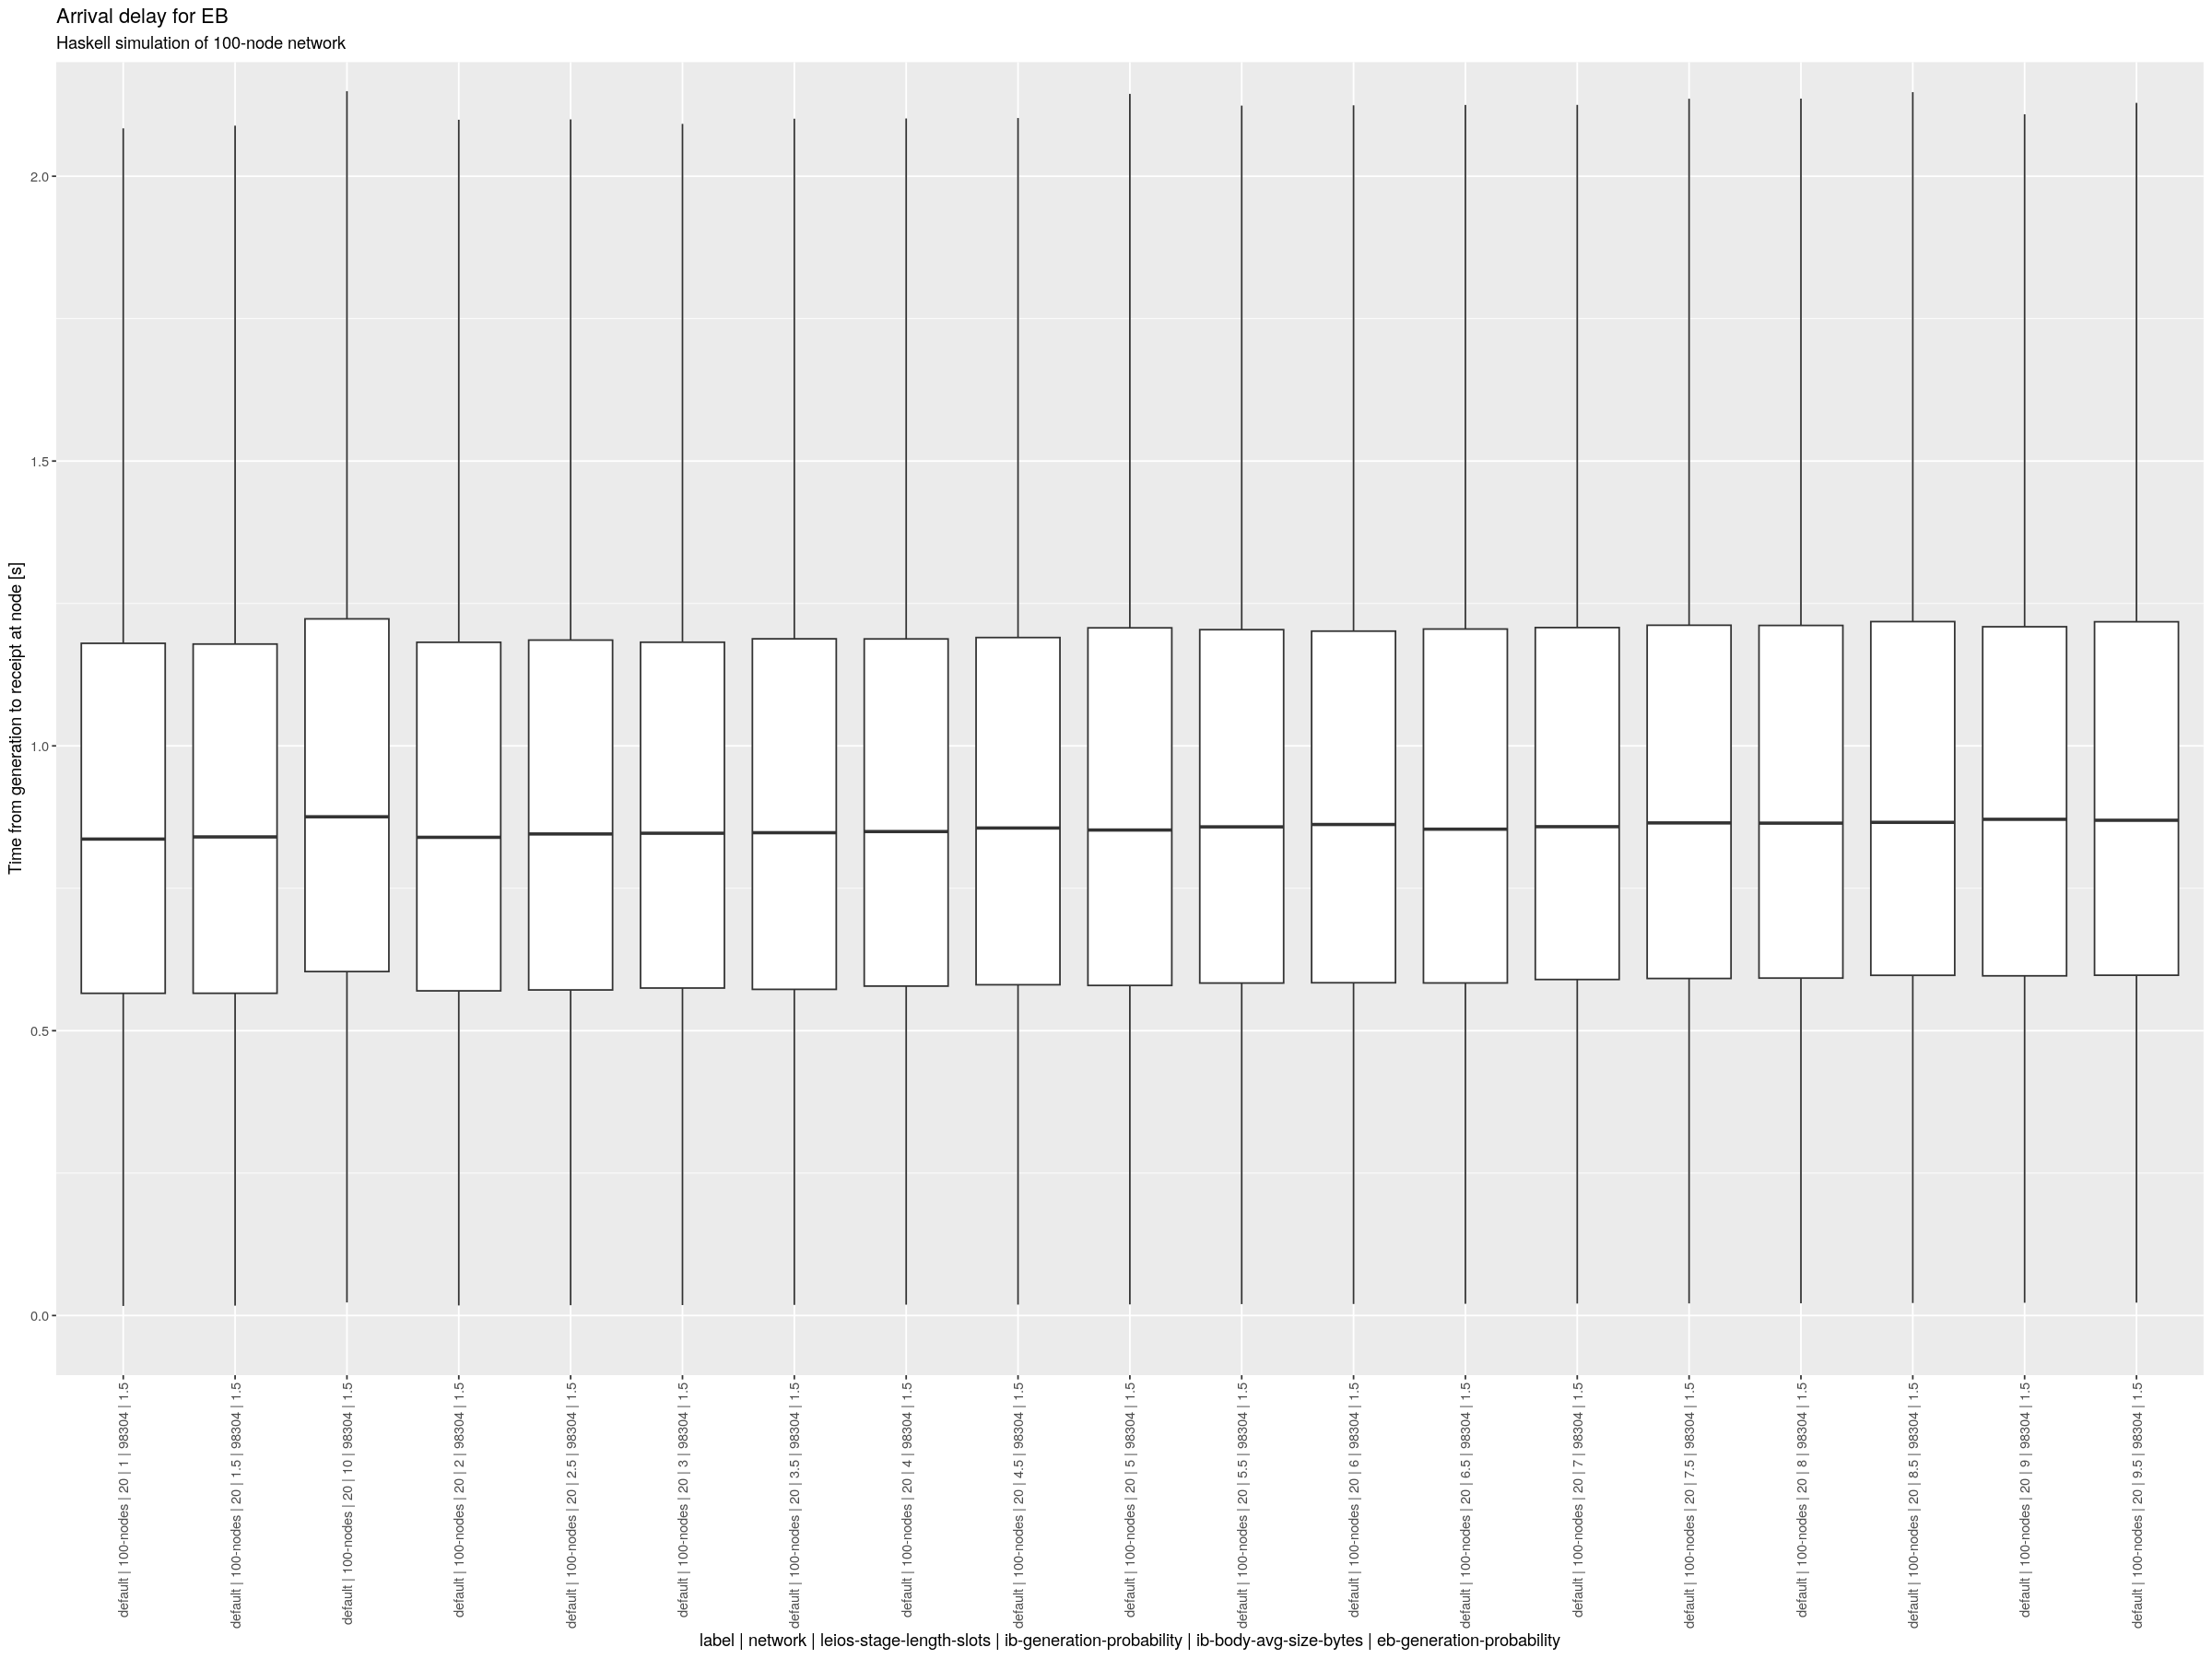

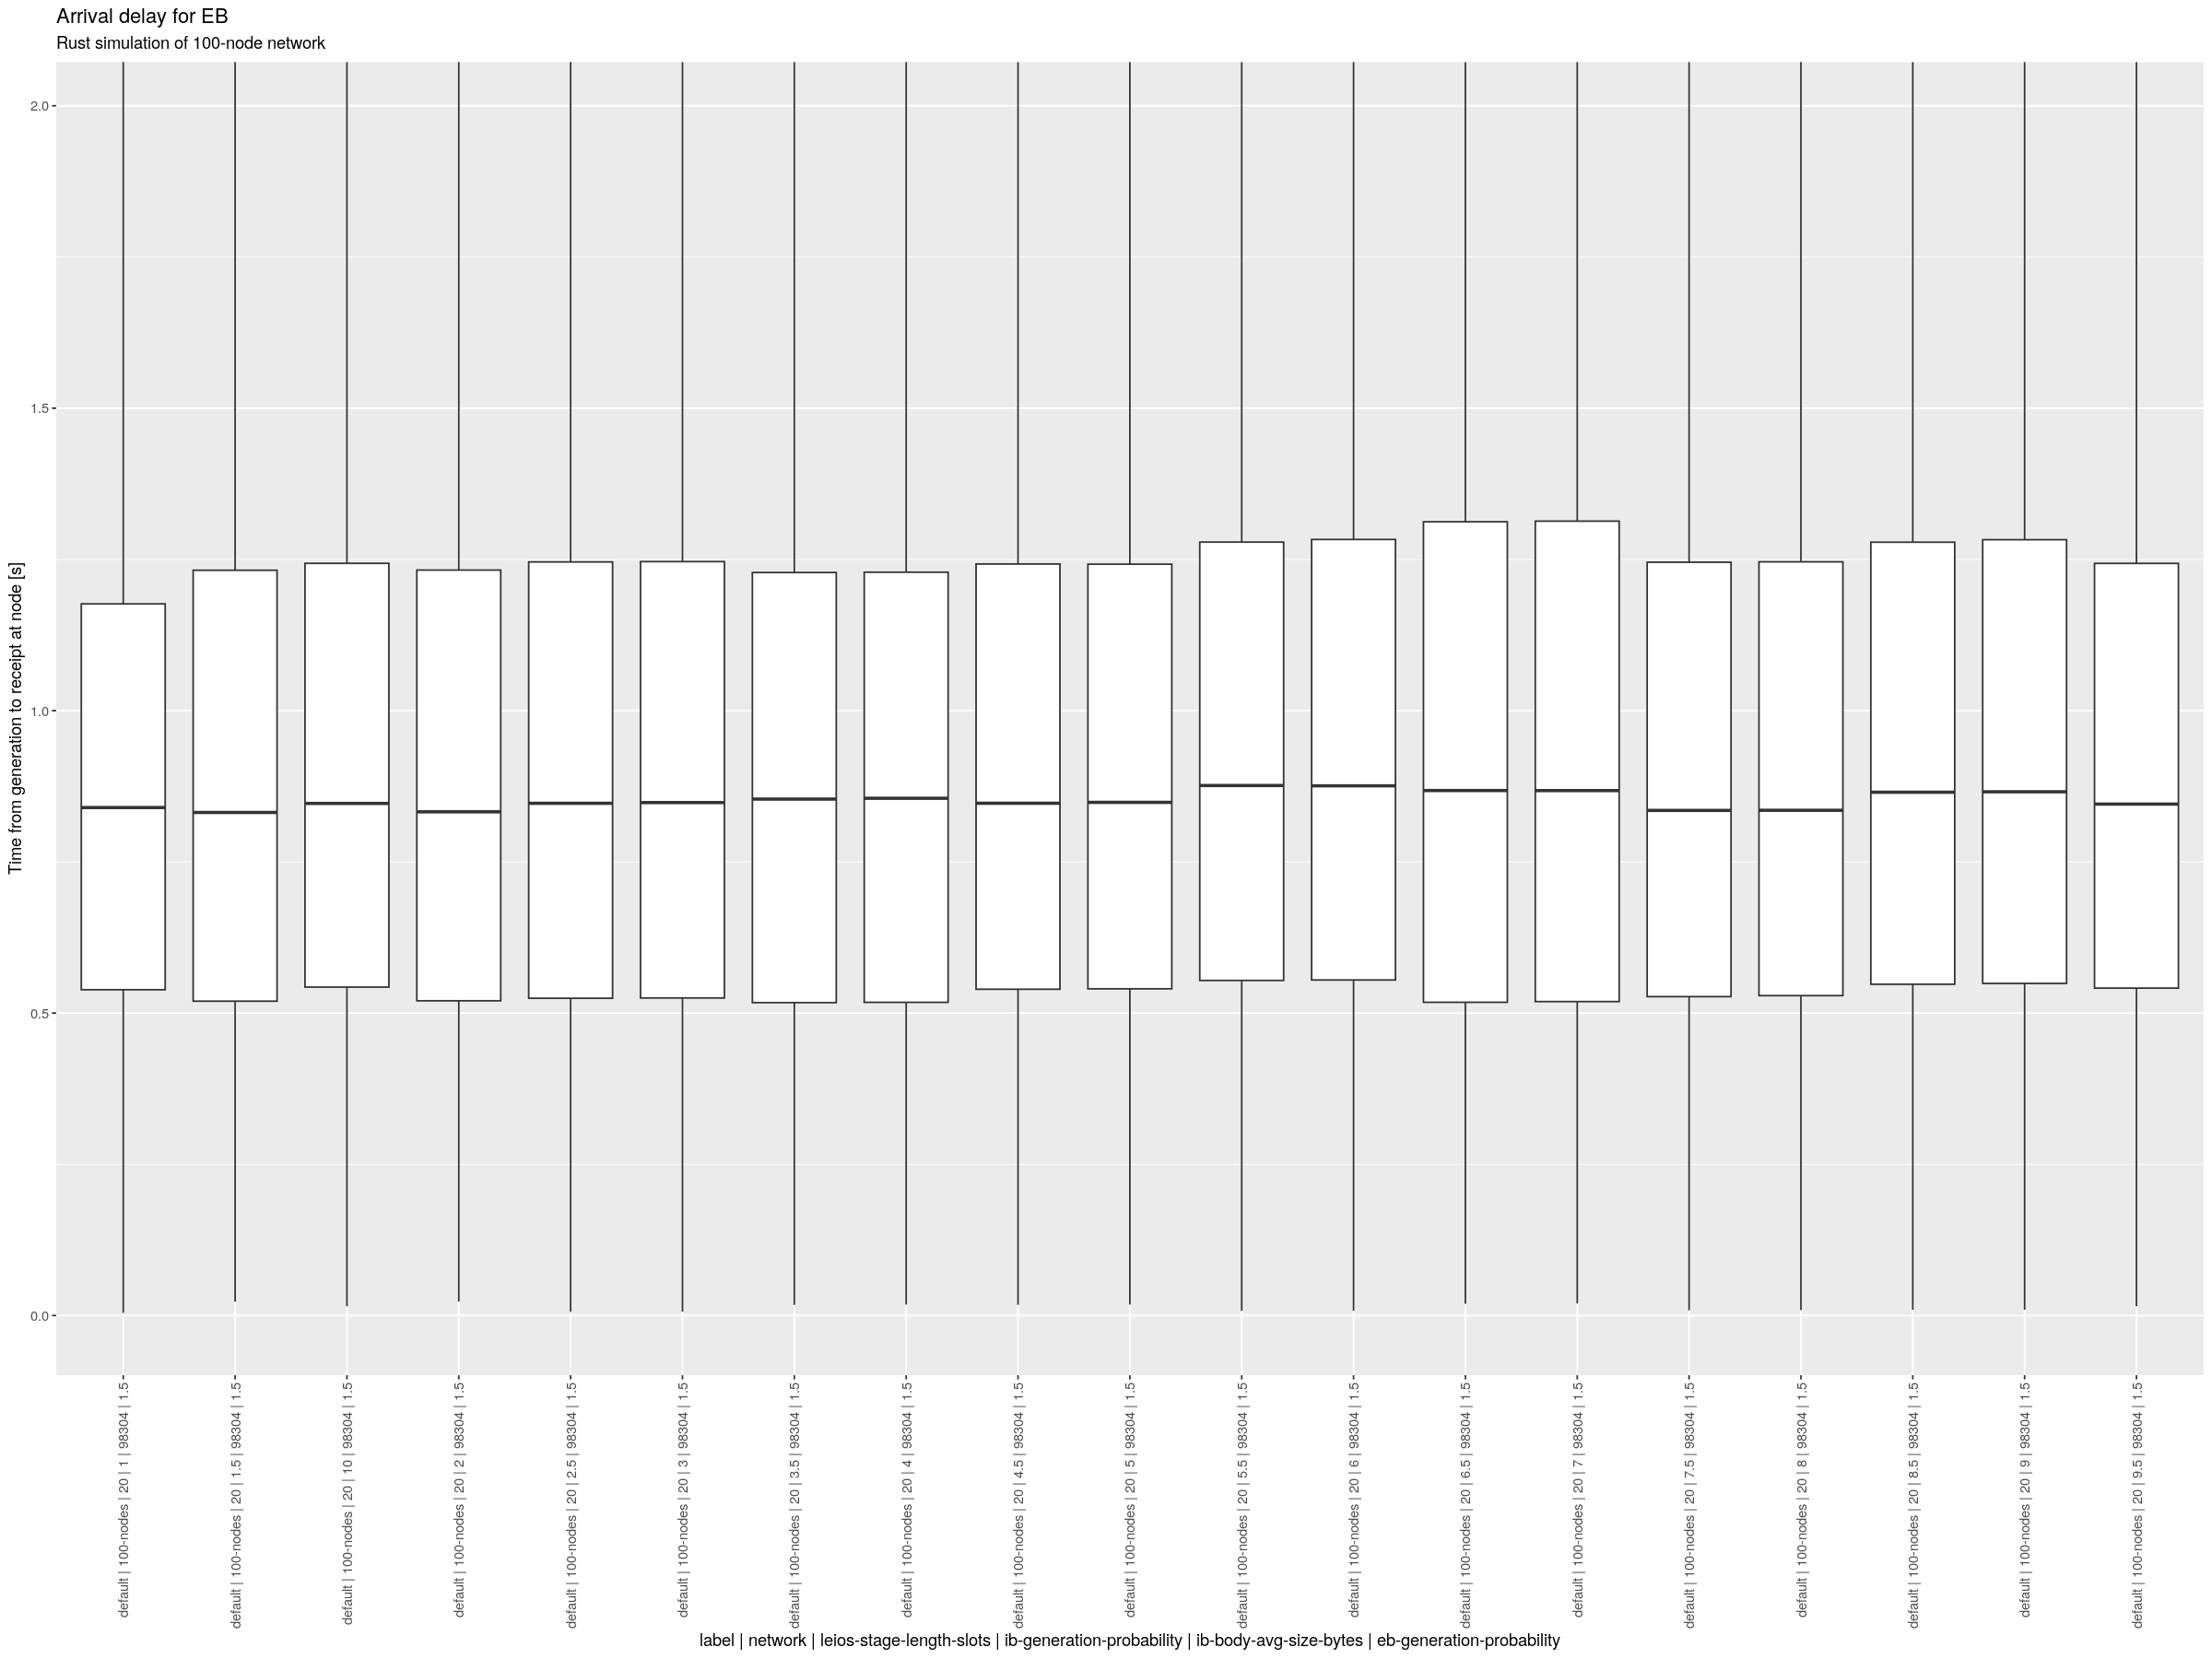

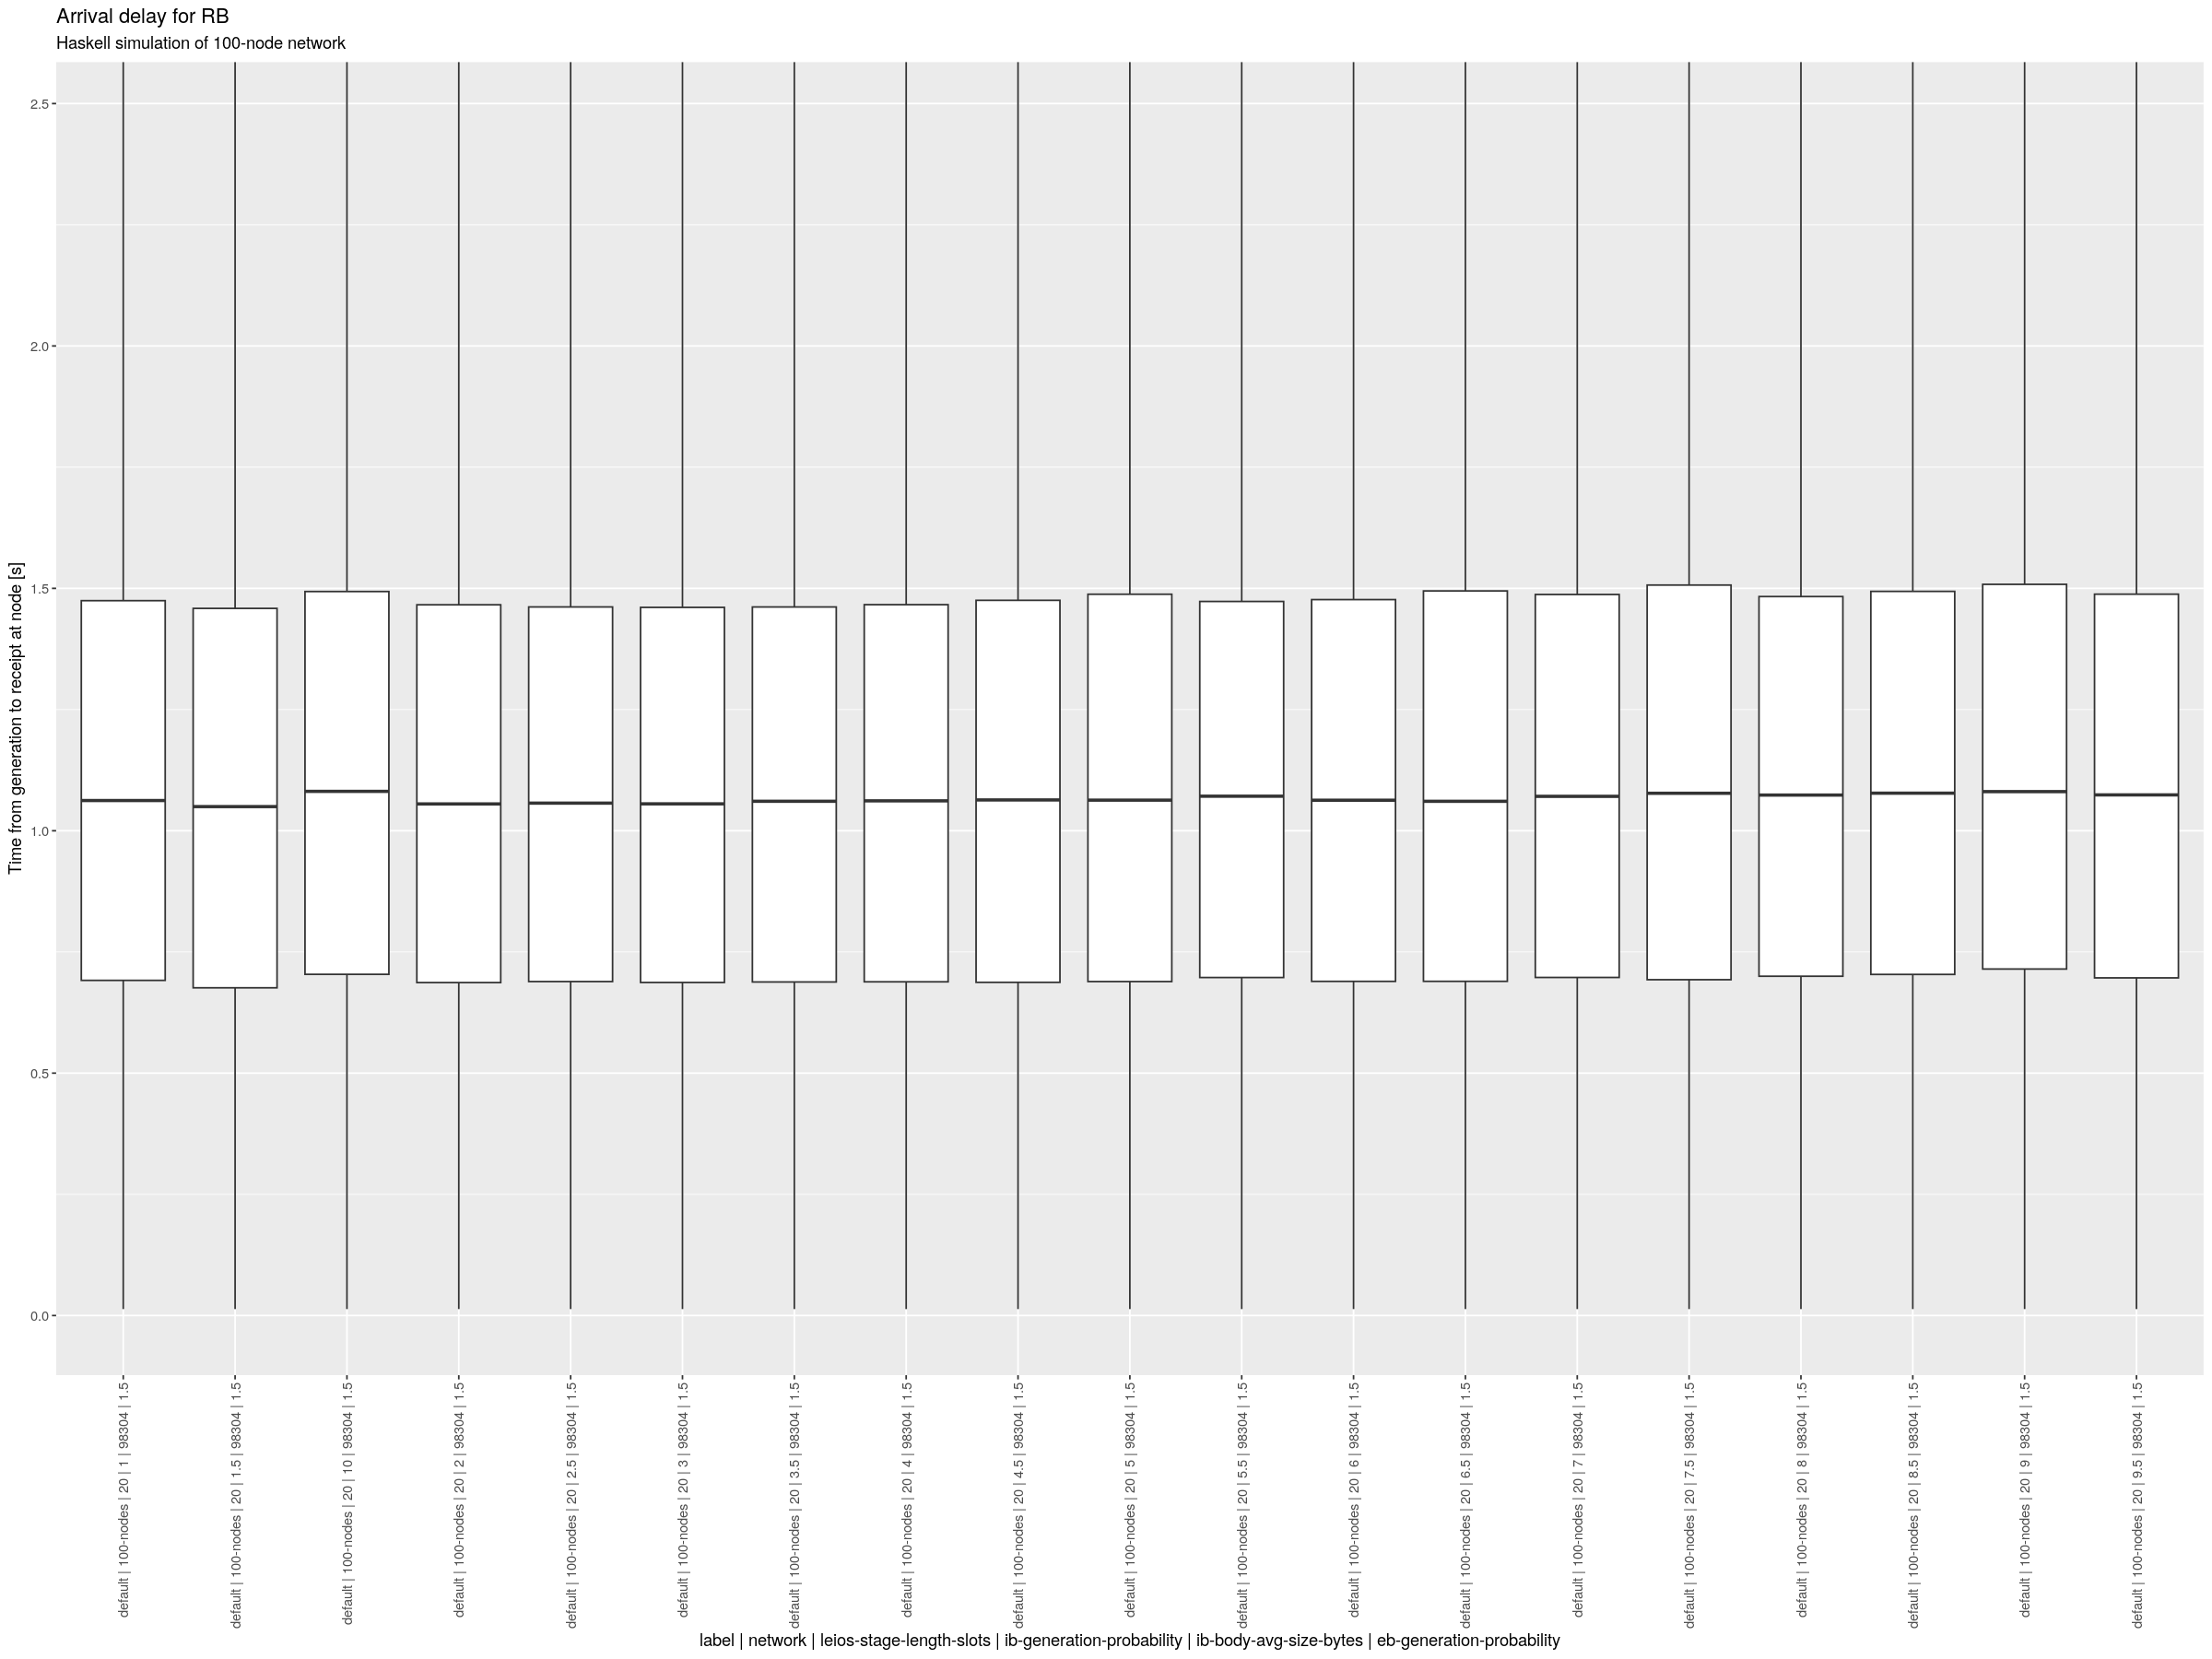

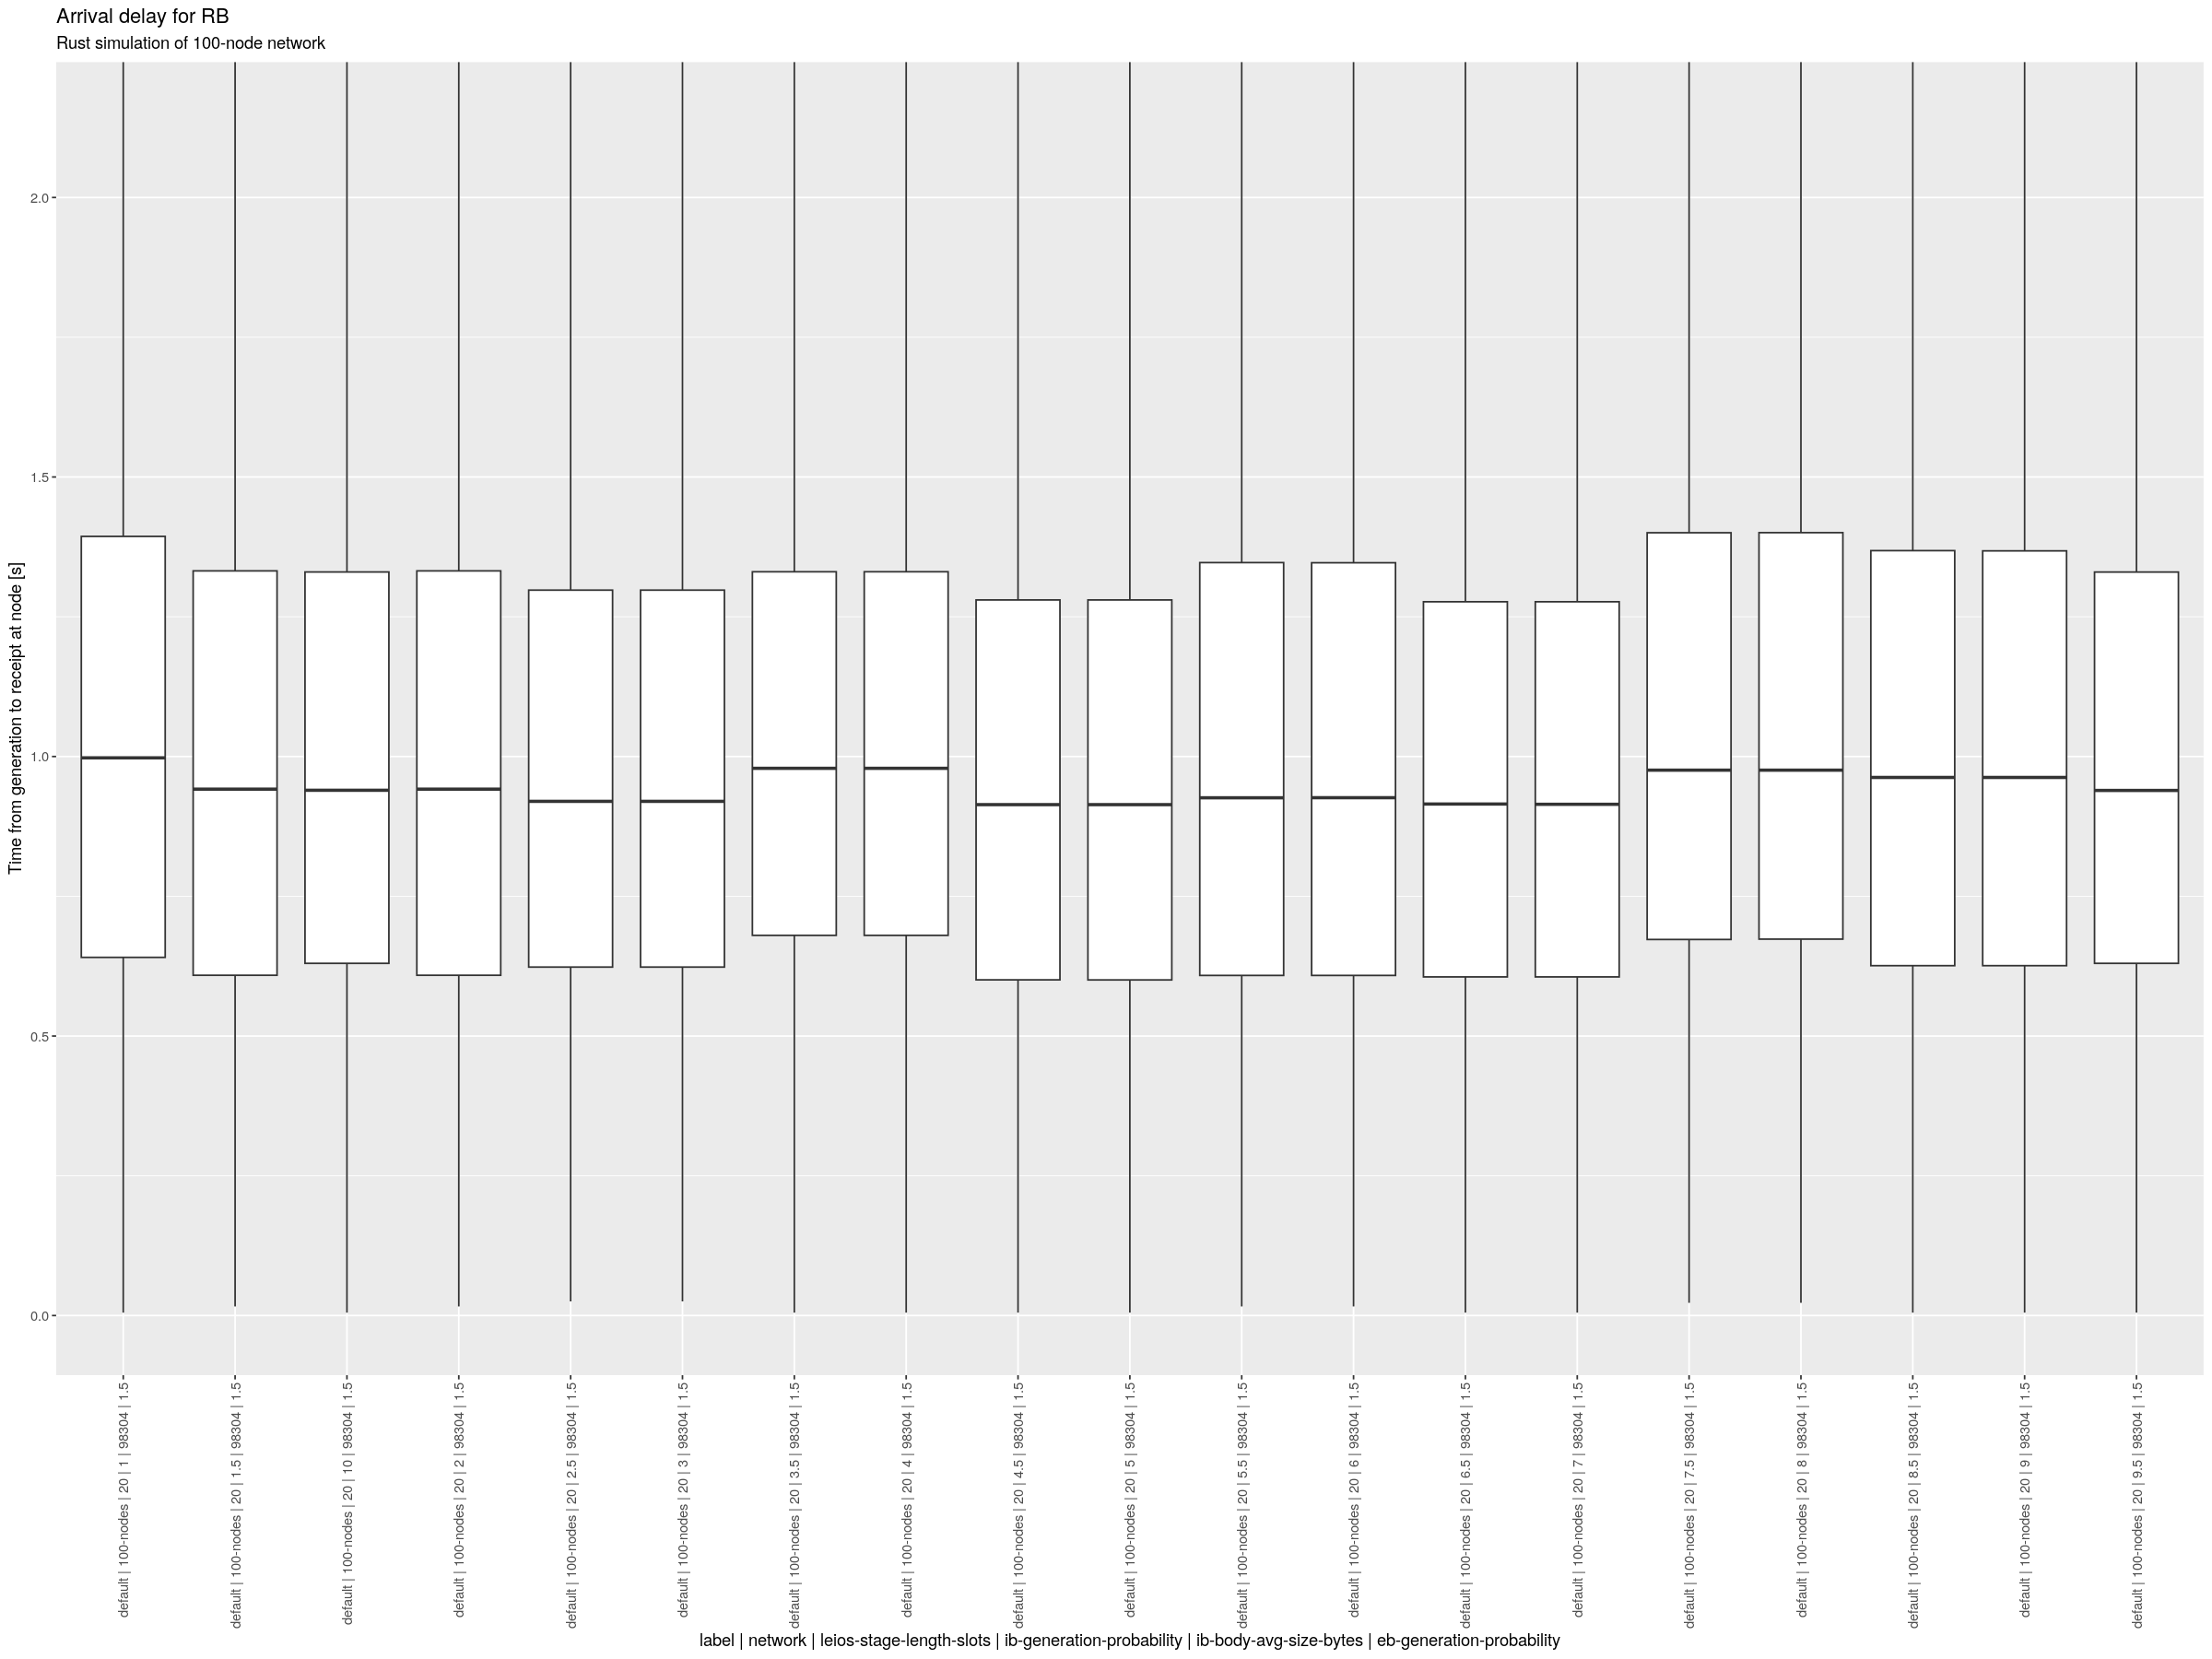

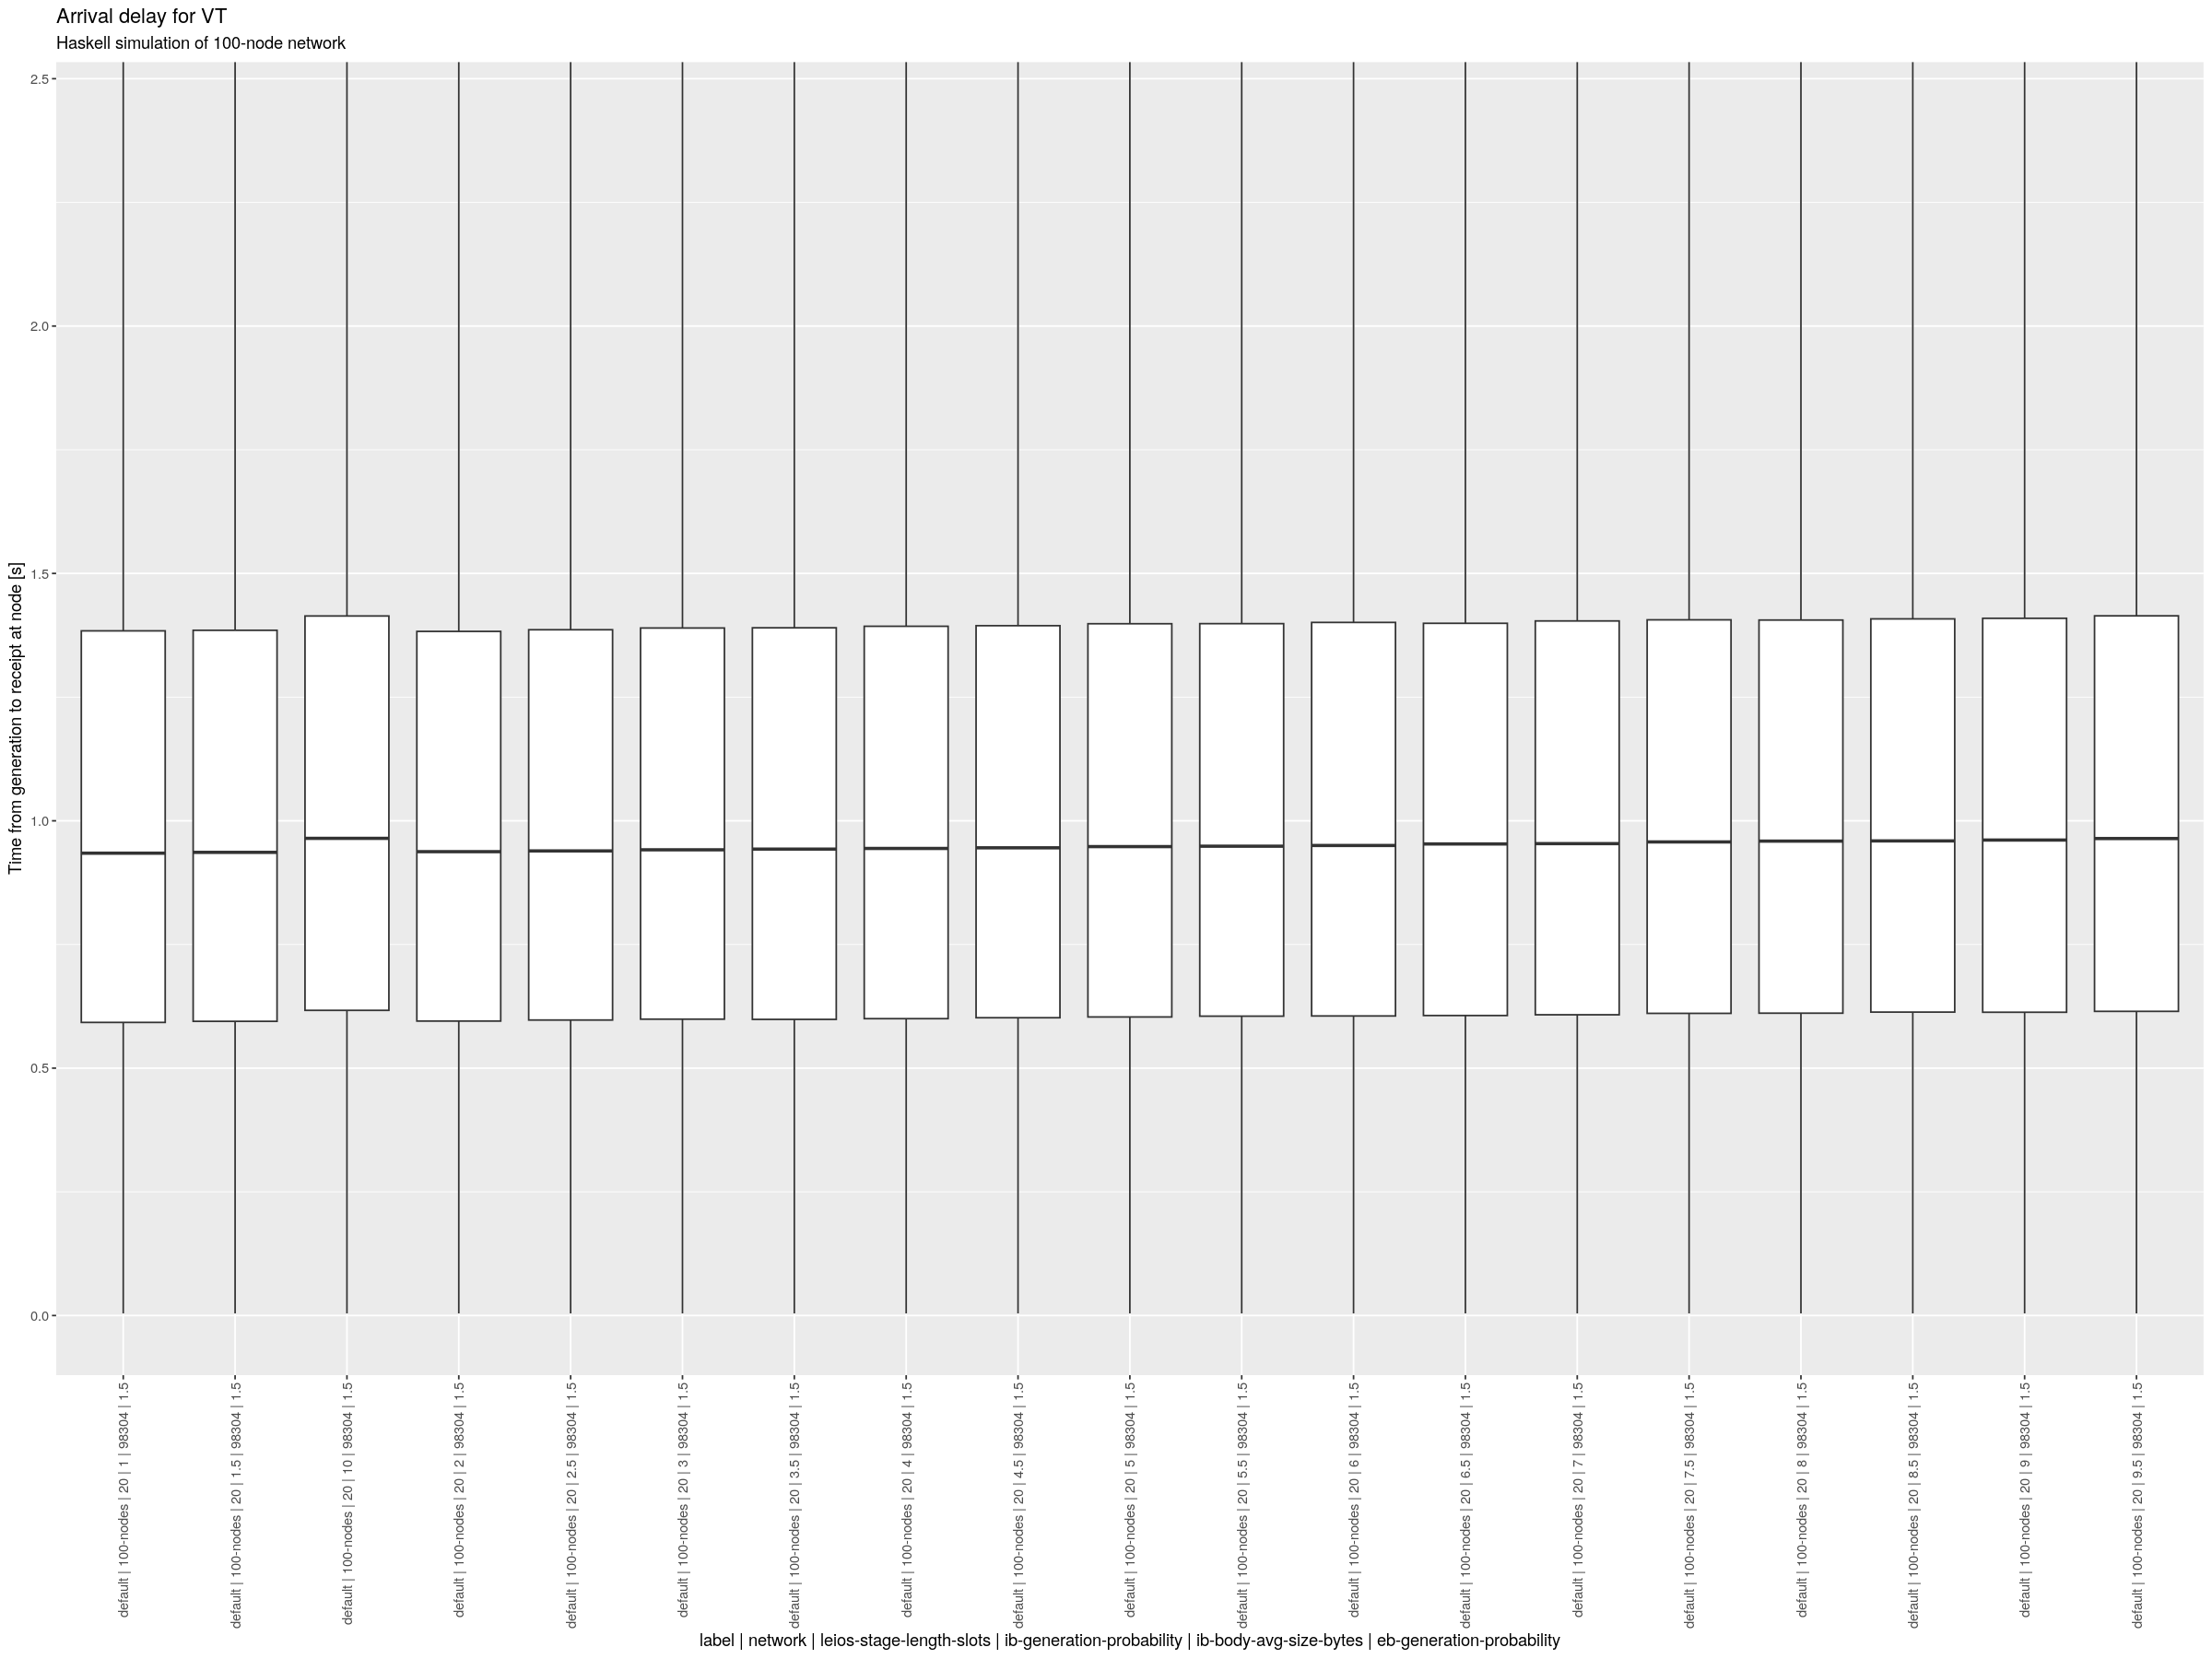

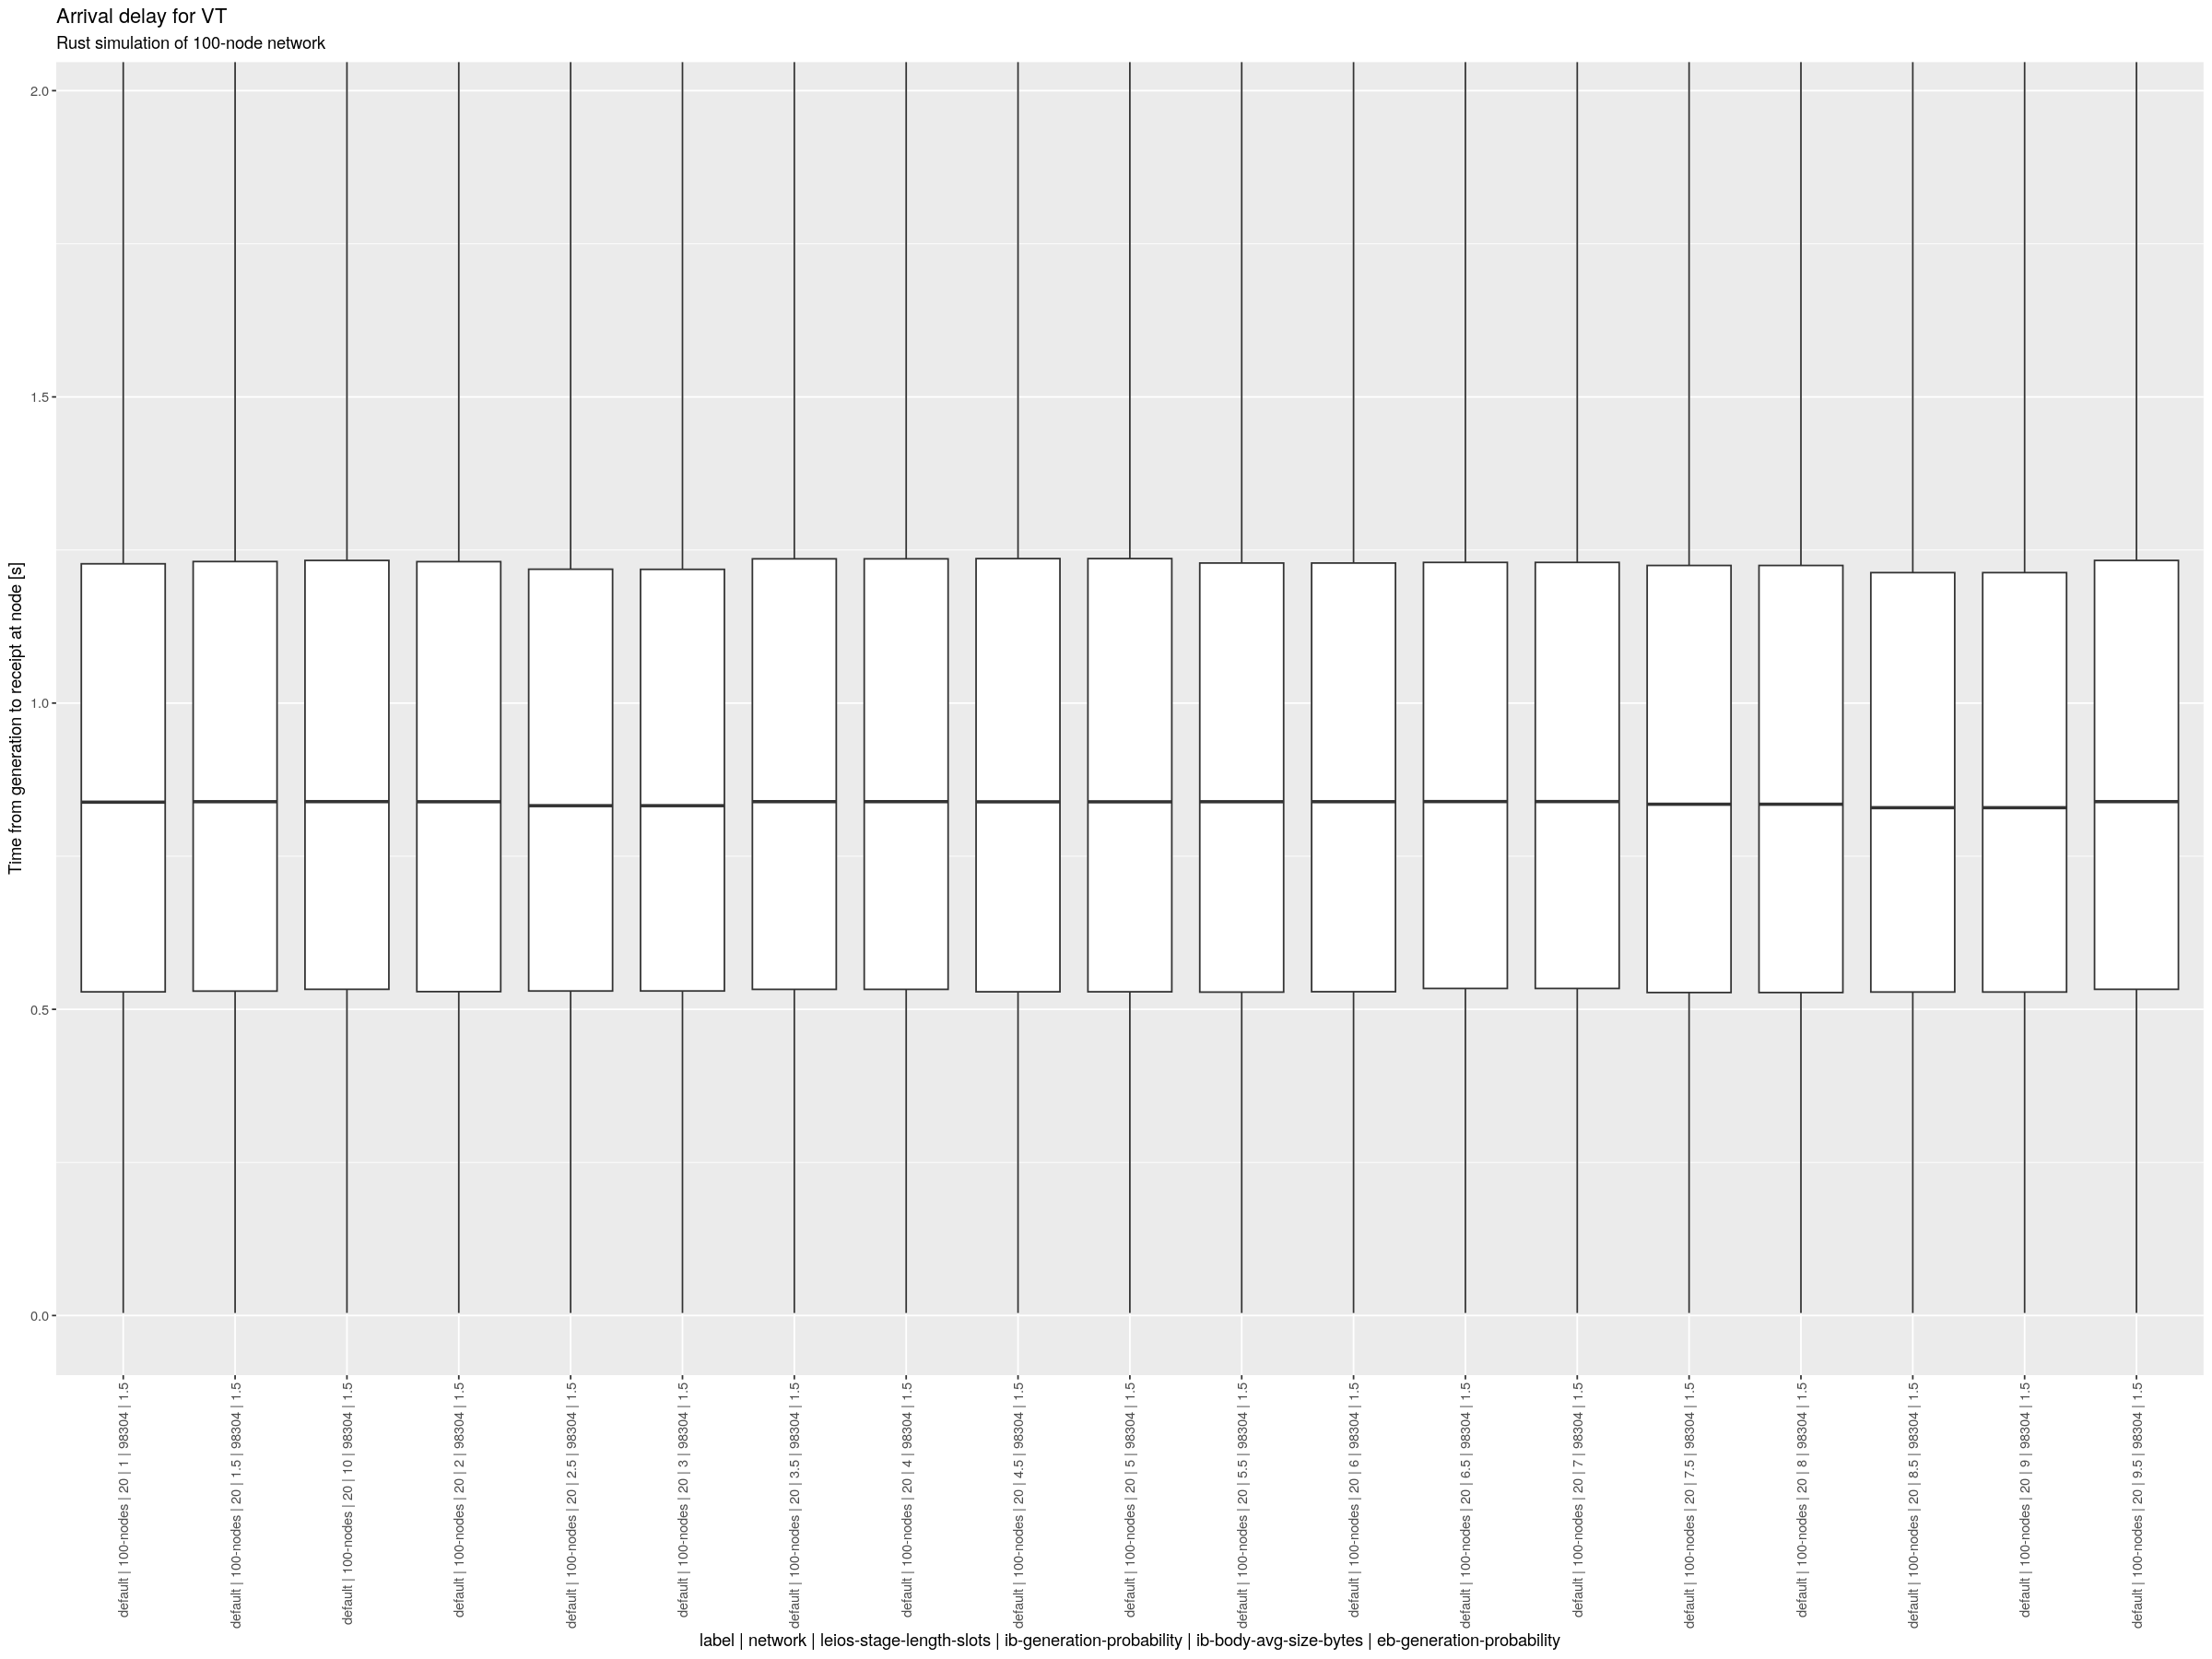

In [9]:
for (k in c("IB", "EB", "RB", "VT")) {
for (s in c("haskell", "rust")) {
    d <- receiptScenario[`simulator` == s & `kind` == k]
    g <- ggplot(d, aes(x=`scenario`, y=`elapsed`)) +
        geom_boxplot(outlier.shape=NA) +
        coord_cartesian(ylim=c(0, d[, quantile(`elapsed`, probs=0.99)])) +
        xlab("label | network | leios-stage-length-slots | ib-generation-probability | ib-body-avg-size-bytes | eb-generation-probability") +
        ylab("Time from generation to receipt at node [s]") +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
        ggtitle(paste("Arrival delay for", k), subtitle=paste(s %>% str_to_title, "simulation of 100-node network"))
    print(g)
    ggsave(paste0("plots/elapsed-boxplot-", k, "-", s, ".png"), units="in", width=15, height=6, dpi=150)
}
}

In [10]:
options(repr.plot.width=10, repr.plot.height=7)

#### IB rate variations

##### Compare the distributions of elapsed times

In [11]:
arrivalDelayHistogram <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[, .(`simulator`, `ibRate`=mapply(ibRateFactor, `ib-generation-probability`), `elapsed`)],
        aes(x=`elapsed`)
    ) +
        geom_histogram(binwidth=0.1) +
        facet_grid(`ibRate` ~ `simulator`, scales=scales) +
      # coord_cartesian(xlim=c(0, 5)) +
        xlab("Time from generation to receipt at node [s]") +
        ylab("Number received") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

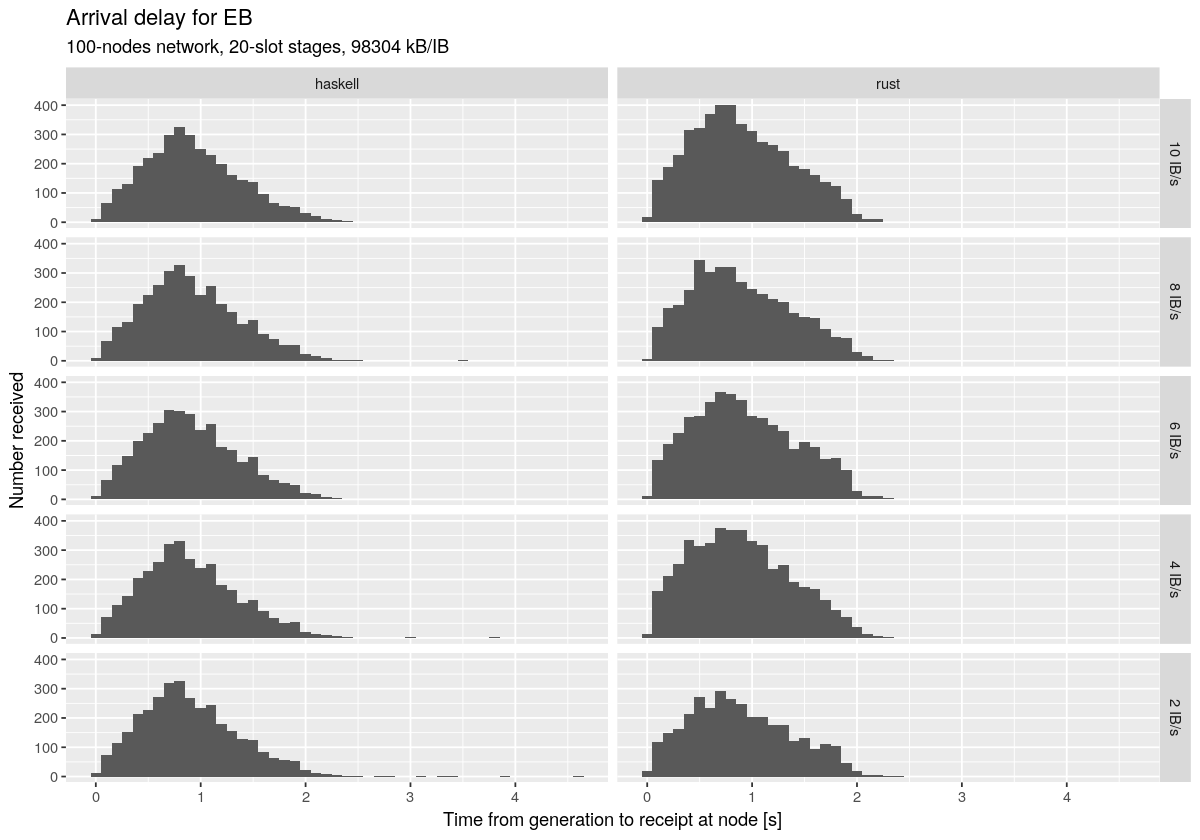

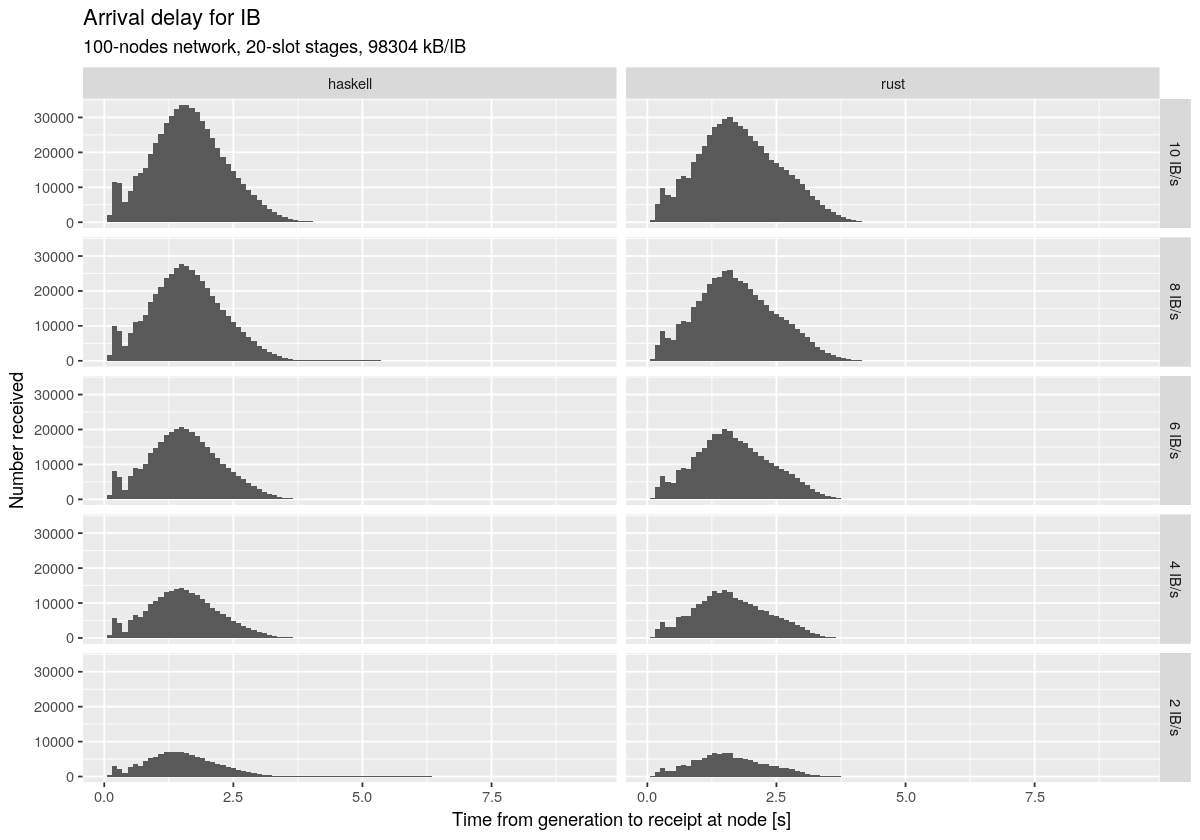

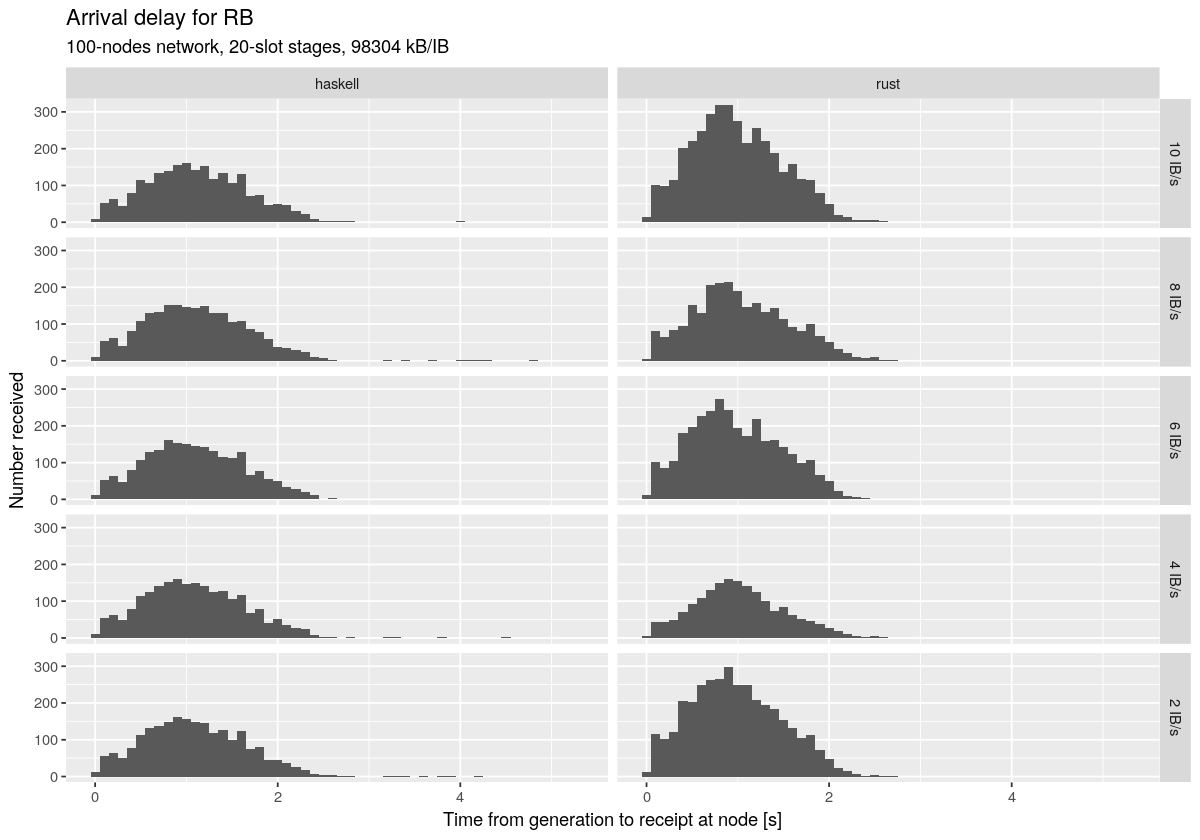

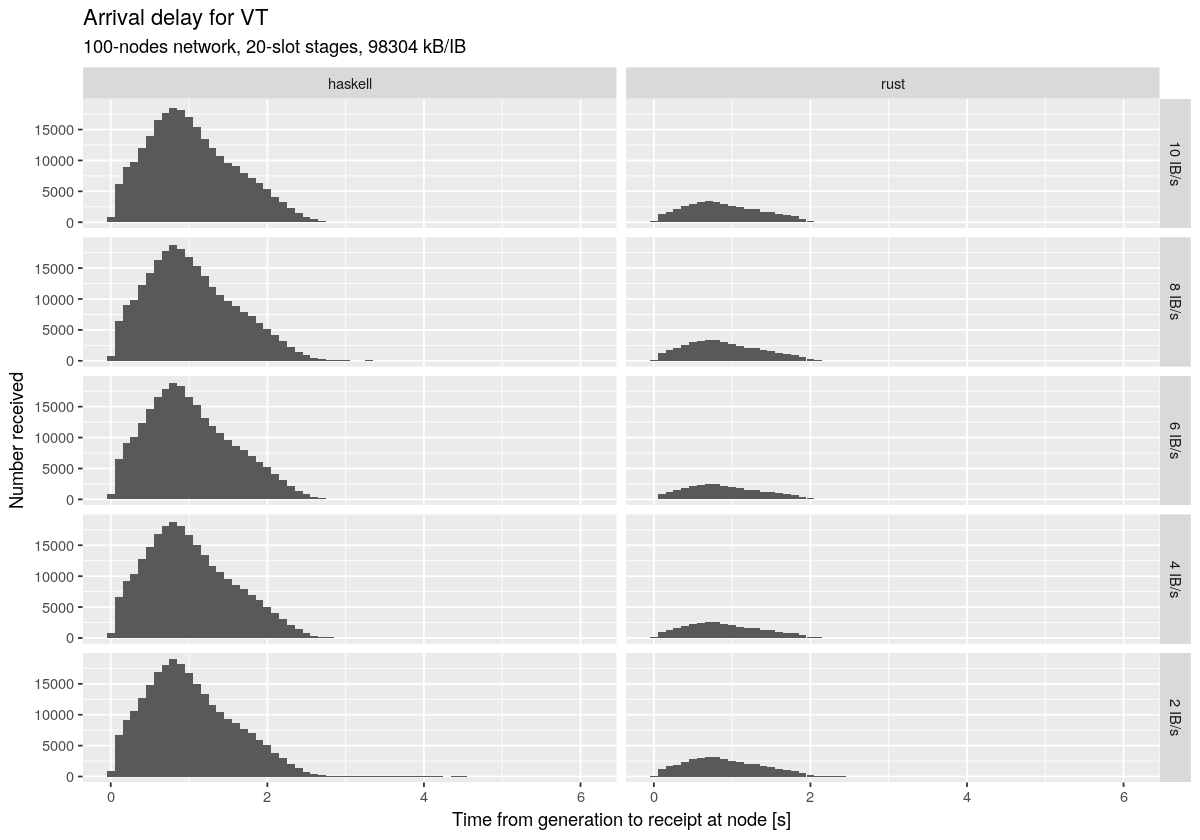

In [12]:
for (k in kinds)
    arrivalDelayHistogram(
        receipts[`kind` == k & `ib-generation-probability` %in% ibRates],
        paste("Arrival delay for", k),
        outfiles=paste0("plots/elapsed-", k, ".png")
    ) %>% print

#### Fraction of items arriving

In [13]:
arrivalFractionTimeseries <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(`received`=as.numeric(.N)),
            by=.(`simulator`, `network`, `label`, `ib-generation-probability`, `ib-body-avg-size-bytes`, `kind`, `sent`, `item`)
        ][,
            .(`total`=as.numeric(.N), `received`=sum(`received`)),
            by=.(`simulator`, `network`, `label`, `ib-generation-probability`, `ib-body-avg-size-bytes`, `kind`, `sent`)
        ][,
            .(`received`=sum(`received`)/sum(`total`)),
            by=.(`simulator`, `network`, `label`, `ib-generation-probability`, `ib-body-avg-size-bytes`, `kind`, `sent`)
        ][, .(
                `simulator`,
                `ibRate`=mapply(ibRateFactor, `ib-generation-probability`),
                `sent`,
                `received`
        )], 
        aes(x=`sent`, y=`received`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`ibRate`  ~ `simulator`, scales=scales) +
        xlab("Time of generation [s]") +
        ylab("Number of nodes receiving") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

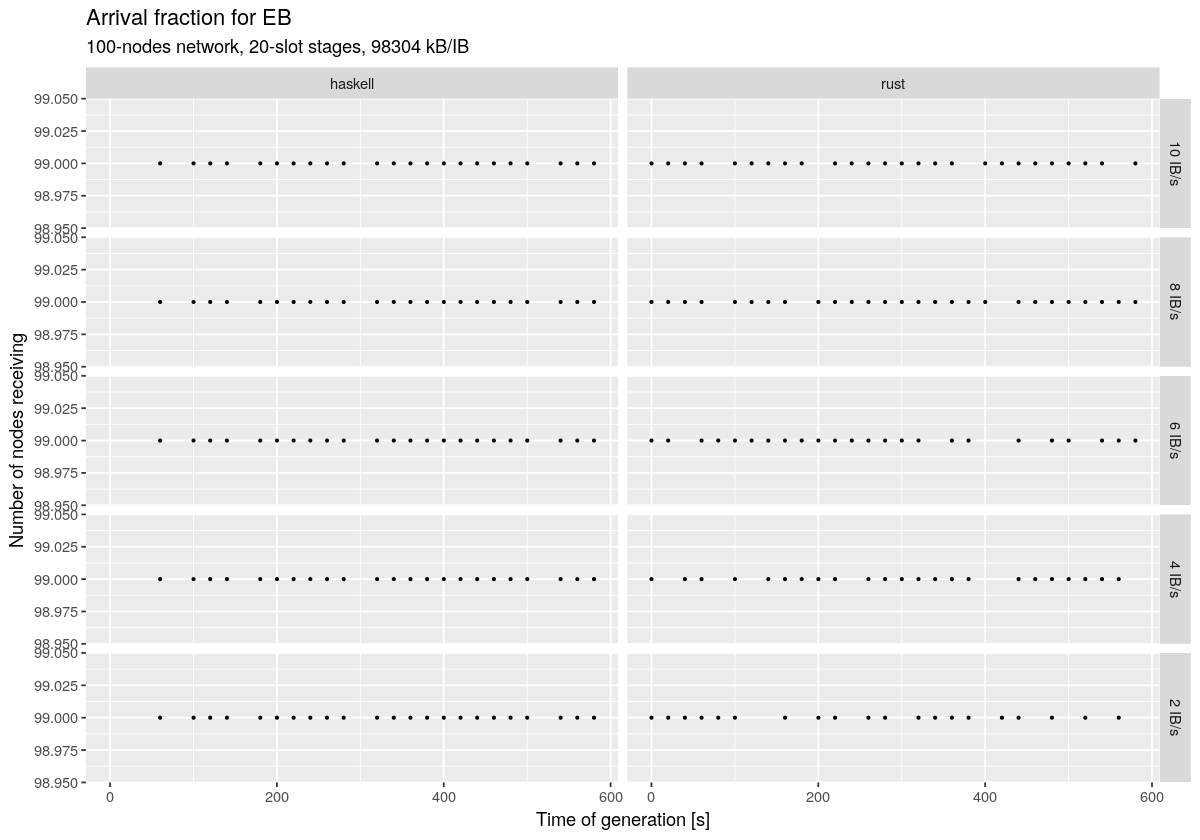

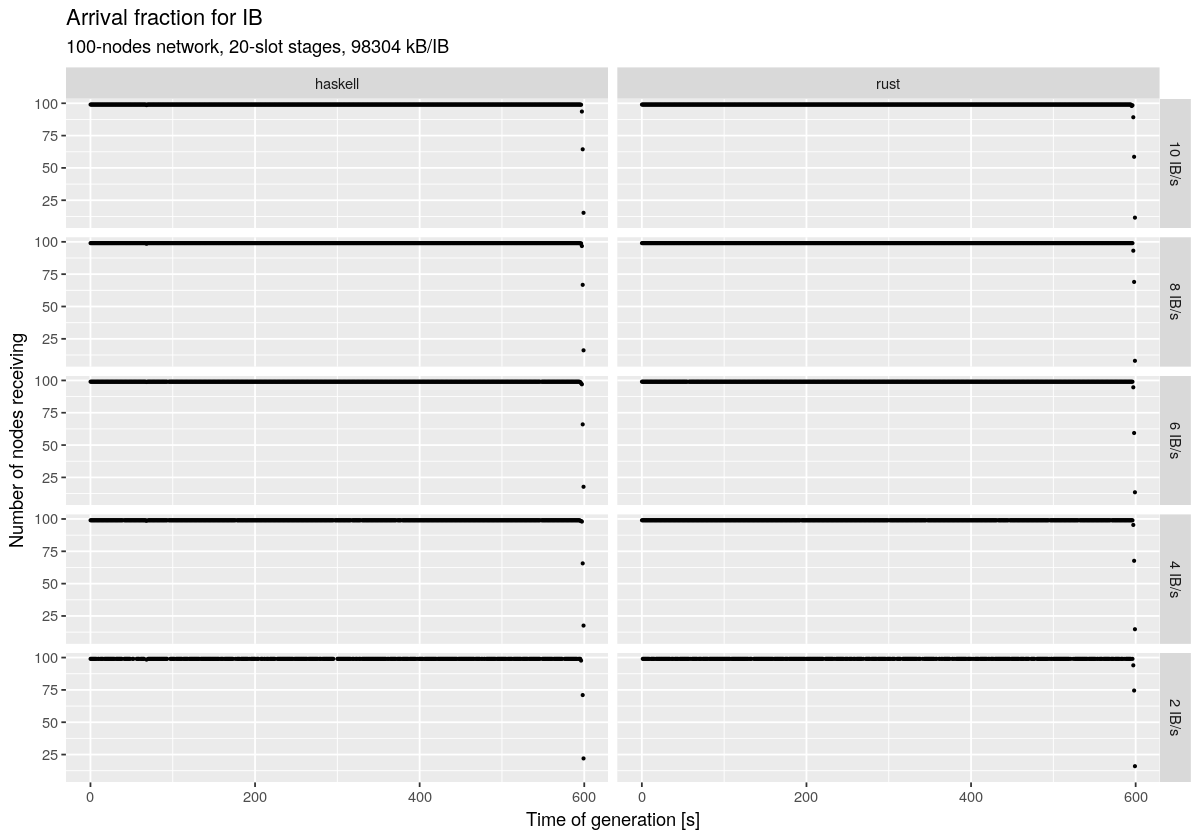

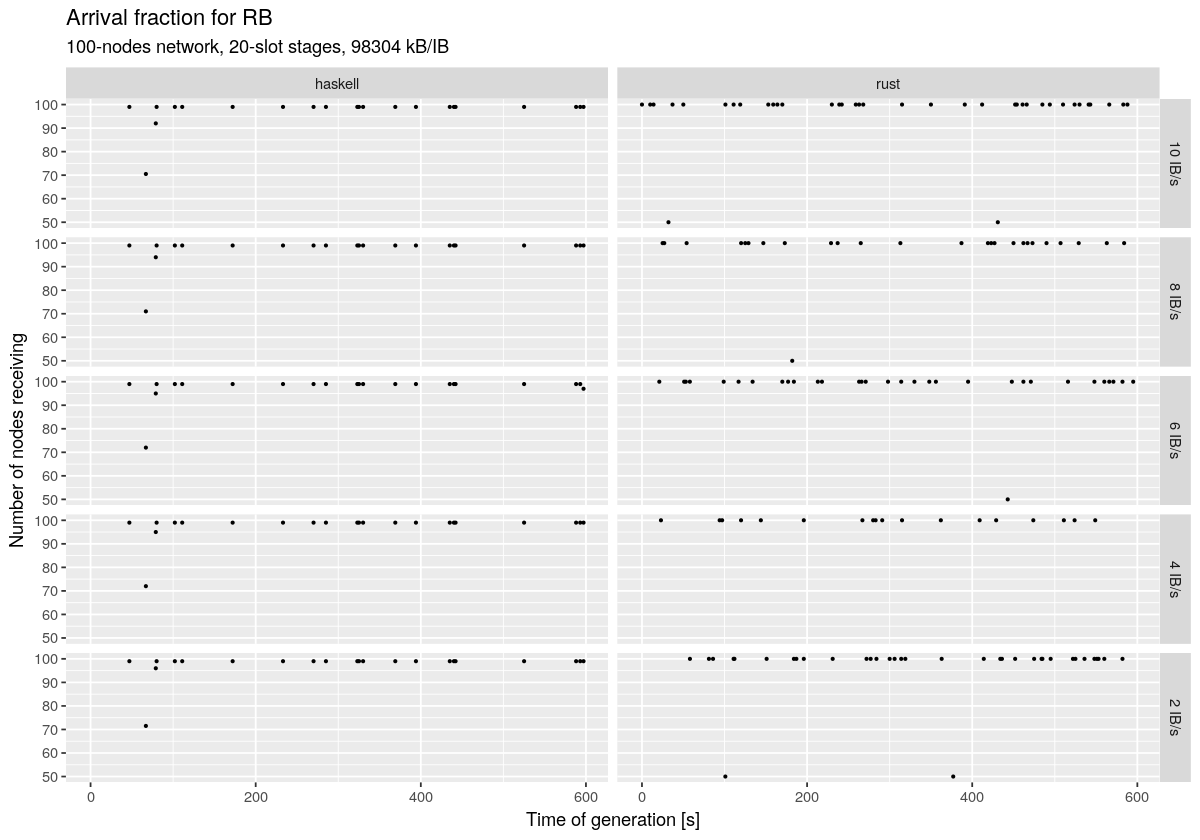

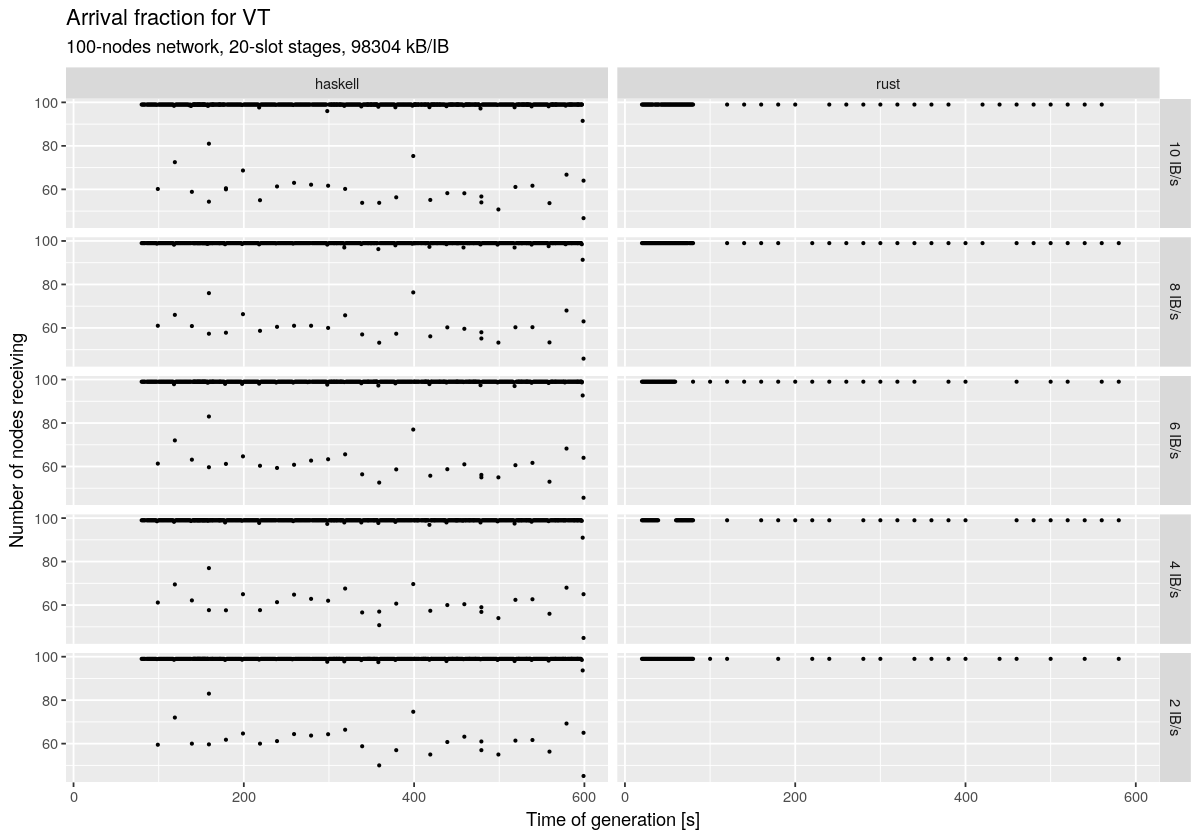

In [14]:
for (k in kinds)
    arrivalFractionTimeseries(
        receipts[`kind` == k & `ib-generation-probability` %in% ibRates],
        paste("Arrival fraction for", k),
        outfiles=paste0("plots/arrival-", k, ".png")
    ) %>% print

#### Bandwidth usage

##### Total network bandwidth

In [15]:
receipts[, .(`count`=.N), .(`simulator`, `kind`, `size missing?`=is.na(`size`))]

simulator,kind,size missing?,count
<fct>,<fct>,<lgl>,<int>
rust,EB,FALSE,86427
rust,IB,FALSE,6147594
rust,RB,TRUE,59224
rust,VT,FALSE,673497
haskell,EB,FALSE,63954
haskell,IB,FALSE,6171911
haskell,RB,TRUE,42148
haskell,VT,FALSE,4754245


In [16]:
totalBandwidthPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `size`=sum(`size`, rm.na=TRUE)/1000000000
            ),
            by=.(
                `simulator`,
                `ibRate`=mapply(ibRateFactor, `ib-generation-probability`),
                `slot`=floor(`received`),
                `Message`=`kind`
            )
        ],
        aes(x=`slot`, y=`size`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`ibRate` ~ `simulator`, scales=scales) +
        xlab("Slot [s]") +
        ylab("Total network ingress [GB/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

Warning message:
“Removed 728 rows containing non-finite values (`stat_align()`).”
Warning message:
“Removed 728 rows containing non-finite values (`stat_align()`).”


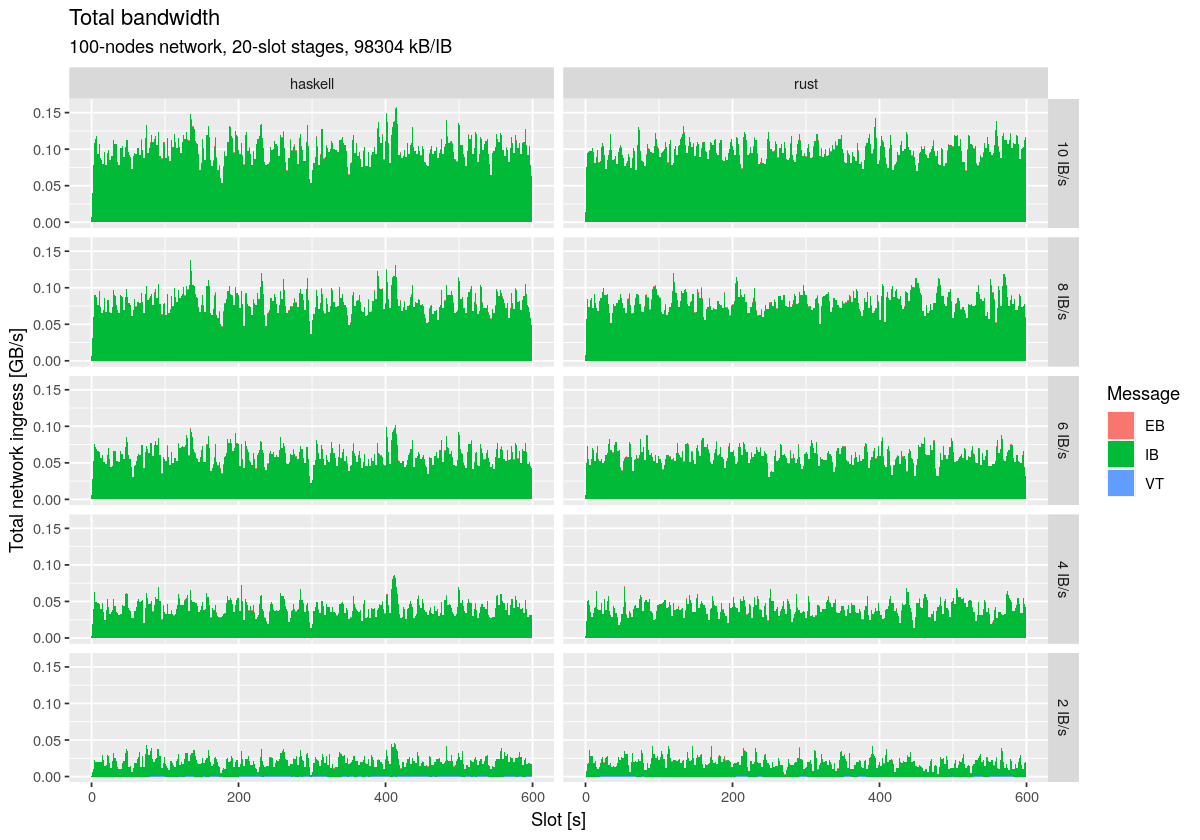

In [17]:
totalBandwidthPlot(
    receipts[`ib-generation-probability` %in% ibRates & !is.na(`elapsed`)],
    "Total bandwidth",
    outfiles=paste0("plots/ingress-total-area.png")
)

##### Bandwidth usage per node

In [18]:
meanNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `size`=sum(`size`)/1000000 / 100
            ),
            by=.(
                `simulator`,
                `ibRate`=mapply(ibRateFactor, `ib-generation-probability`),
                `slot`=floor(`received`),
                `Message`=`kind`
            )
        ],
        aes(x=`slot`, y=`size`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`ibRate` ~ `simulator`, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Mean network ingress among nodes [MB/s]") +
        ggtitle("title", subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

Warning message:
“Removed 728 rows containing non-finite values (`stat_align()`).”
Warning message:
“Removed 728 rows containing non-finite values (`stat_align()`).”


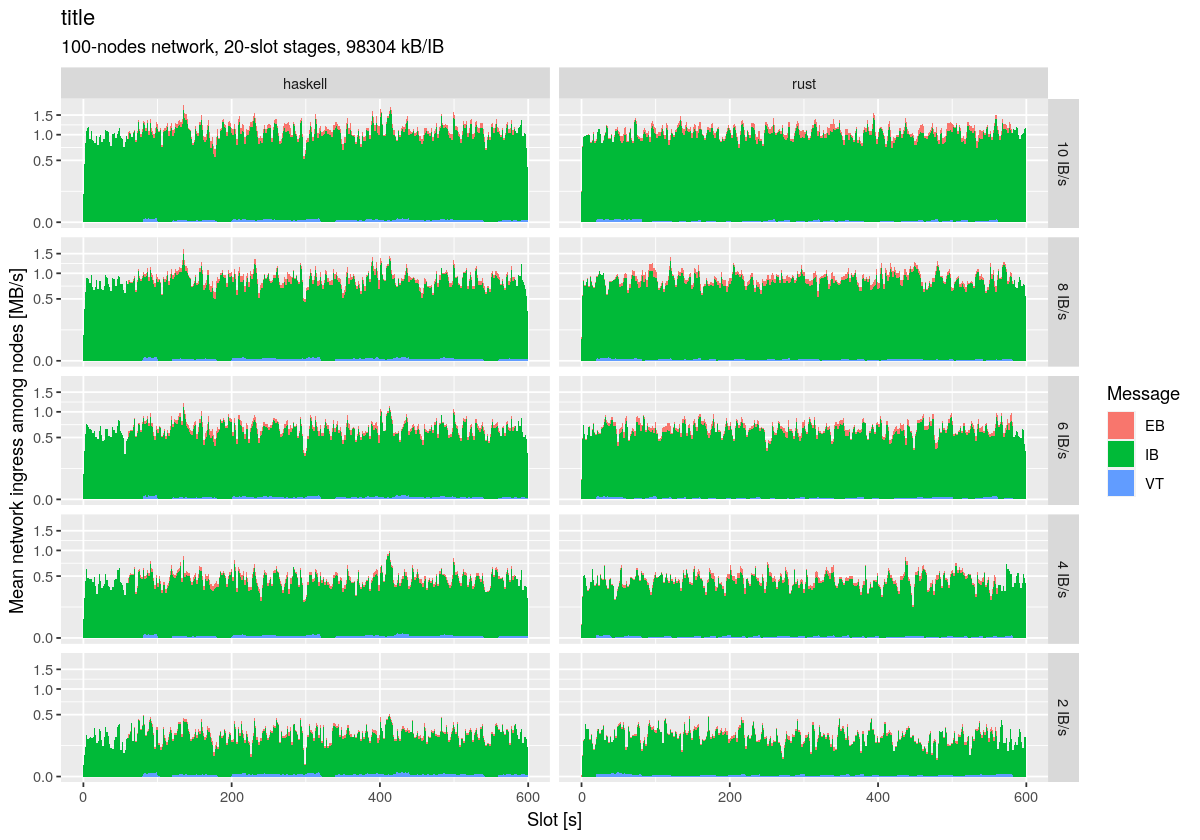

In [19]:
meanNodalIngressPlot(
    receipts[`ib-generation-probability` %in% ibRates], 
    "Mean nodal ingress",
    outfiles=paste0("plots/ingress-average-area.png")
)

In [20]:
peakNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `size`=sum(`size`, rm.na=TRUE)/1000000
            ),
            by=.(
                `simulator`,
                `ibRate`=mapply(ibRateFactor, `ib-generation-probability`),
                `slot`=floor(`received`),
                `Message`=`kind`,
                `recipient`
            )
        ][,
            .(`size`=max(`size`)),
            by=.(`simulator`, `ibRate`, `slot`, `Message`)
        ],
        aes(x=`slot`, y=`size`, color=`Message`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`ibRate` ~ `simulator`, scales=scales) +
        xlab("Slot [s]") +
        ylab("Maximum network ingress among nodes [MB/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

Warning message:
“Removed 728 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 728 rows containing missing values (`geom_point()`).”


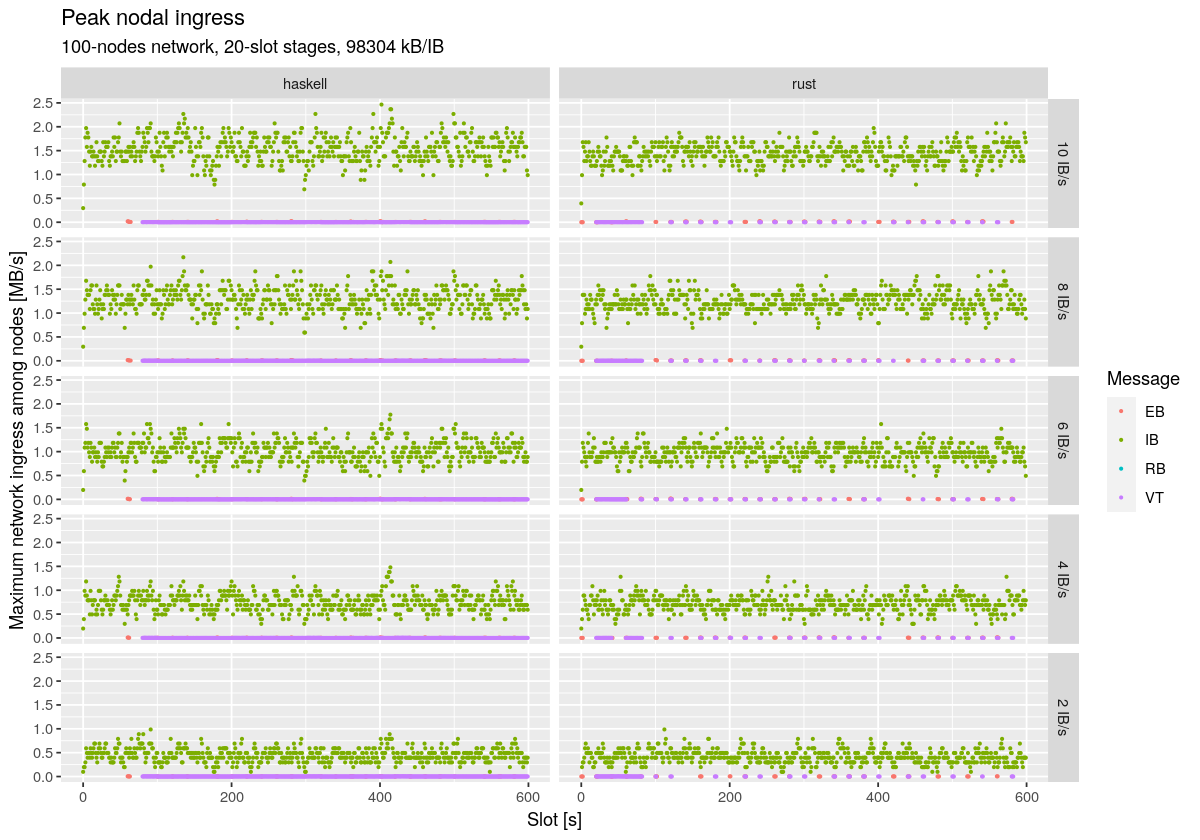

In [21]:
peakNodalIngressPlot(
    receipts[`ib-generation-probability` %in% ibRates], 
    "Peak nodal ingress",
    outfiles=paste0("plots/ingress-peak-point.png")
)

### CPU usage

#### Read results

In [22]:
cpus <- fread("results/cpus.csv.gz", stringsAsFactors=TRUE)
cpus %>% summary

   simulator           label              network       
 haskell:3489969   default:6007054   100-nodes:6007054  
 rust   :2517085                                        
                                                        
                                                        
                                                        
                                                        
                                                        
 ib-generation-probability ib-body-avg-size-bytes eb-generation-probability
 Min.   : 1.000            Min.   :98304          Min.   :1.5              
 1st Qu.: 3.500            1st Qu.:98304          1st Qu.:1.5              
 Median : 5.500            Median :98304          Median :1.5              
 Mean   : 5.639            Mean   :98304          Mean   :1.5              
 3rd Qu.: 8.000            3rd Qu.:98304          3rd Qu.:1.5              
 Max.   :10.000            Max.   :98304          Max.   :1.5              
            

In [23]:
retask <- function(h) {
    if (h == "GenIB")
        "IBBlockGenerated"
    else if (h == "ValIH")
        "IBHeaderValidated"
    else if (h == "ValIB")
        "IBBlockValidated"
    else if (h == "GenEB")
        "EBBlockGenerated"
    else if (h =="ValEB")
        "EBBlockValidated"
    else if (h == "GenVote")
        "VTBundleGenerated"
    else if (h == "ValVote")
        "VTBundleValidated"
    else if (h == "GenRB")
        "RBBlockGenerated"
    else if (h == "ValRB")
        "RBBlockValidated"
    else if (h == "ValRH")
        "RBHeaderValidated"
    else
        h
}

In [24]:
cpus[`simulator` == "haskell", `task`:=mapply(retask, `task`)]

In [25]:
cpusNode <-
cpus[
    ,
    .(
        `duration`=sum(`duration`)
    ),
    by=.(
        `simulator`,
        `ib-generation-probability`,
        `ib-body-avg-size-bytes`,
        `leios-stage-length-slots`,
        `node`,
        `slot`
    )
]

In [26]:
cpus[`ib-generation-probability` == 10, .(`total seconds`=sum(`duration`)), .(`simulator`, `task`)][order(`task`, `simulator`)]

simulator,task,total seconds
<fct>,<fct>,<dbl>
haskell,EBBlockGenerated,2.624965
rust,EBBlockGenerated,3.600000
haskell,EBBlockValidated,3.366000
rust,EBBlockValidated,4.752000
haskell,IBBlockGenerated,778.050000
rust,IBBlockGenerated,767.520000
haskell,IBBlockValidated,56881.122752
rust,IBBlockValidated,57882.315520
haskell,IBHeaderValidated,5558.925000


#### Peak CPU usage

##### Histogram

In [27]:
peakCpuHistogram <- function(cs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(
                `duration`=100*max(`duration`)
            ),
            by=.(
                `simulator`,
                `ibRate`=mapply(ibRateFactor, `ib-generation-probability`),
                `slot`
            )
        ], 
        aes(x=`duration`)
    ) +
        geom_histogram(binwidth=10) +
        facet_grid(`ibRate` ~ `simulator`, scales=scales) +
      # coord_cartesian(xlim=c(0, 700)) +
        xlab("Peak CPU load [%]") +
        ylab("Number of slots") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

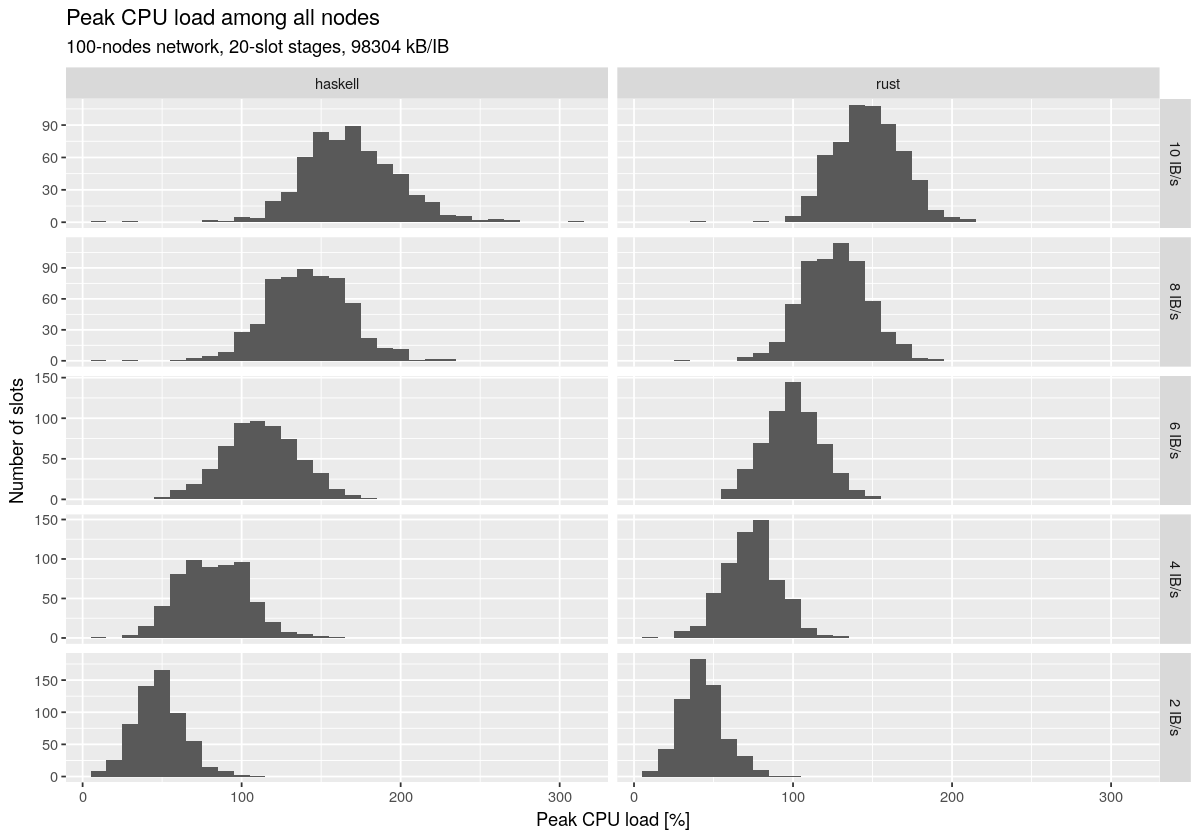

In [28]:
peakCpuHistogram(
    cpusNode[`ib-generation-probability` %in% ibRates], 
    "Peak CPU load among all nodes",
    scales="free_y",
    outfiles=paste0("plots/cpu-peak-histogram.png")
)

##### Time series

In [29]:
peakCpuTimeseries <- function(cs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(
                `duration`=100*mean(`duration`)
            ),
            by=.(
                `simulator`,
                `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(cpusNode[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
                `slot`
            )
        ], 
        aes(x=`slot`, y=`duration`)) +
        geom_line() +
        facet_grid(`ibRate` ~ `simulator`, scale=scales) +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

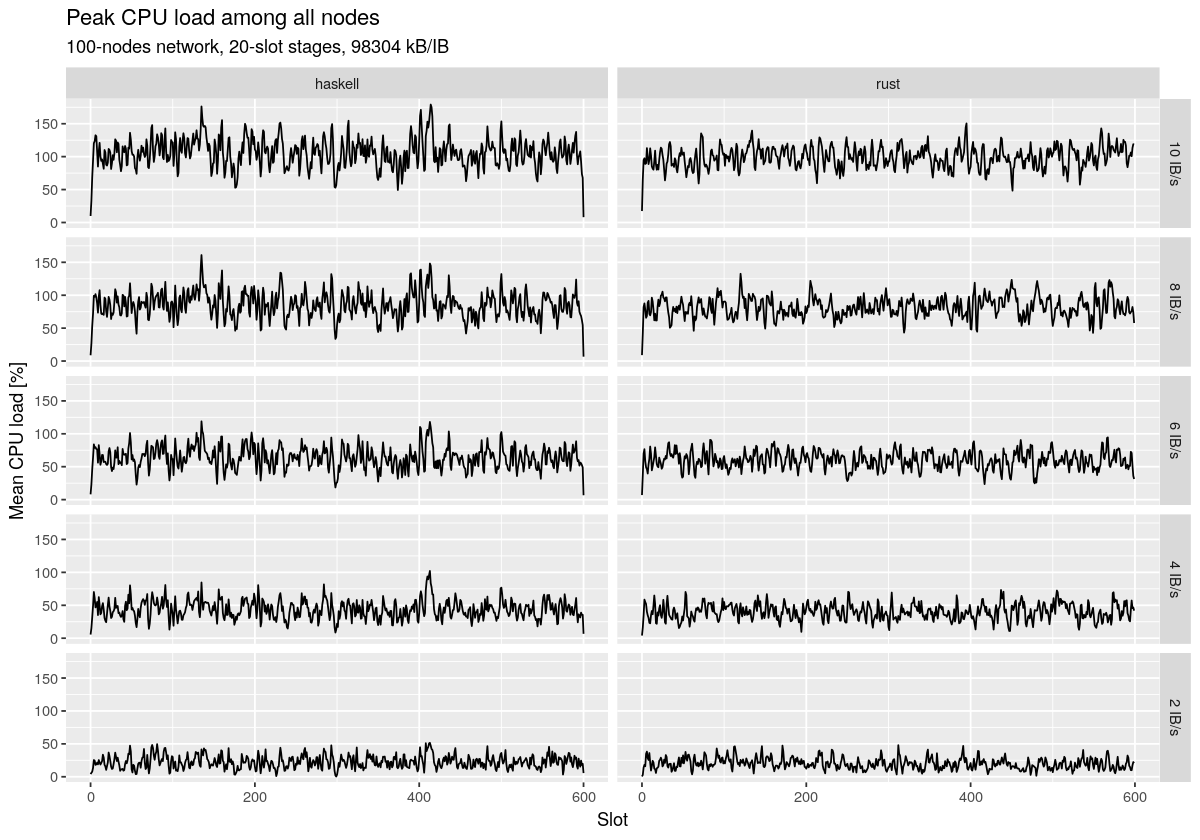

In [30]:
peakCpuTimeseries(
    cpusNode[`ib-generation-probability` %in% ibRates],
    "Peak CPU load among all nodes",
    outfiles=paste0("plots/cpu-peak-timeseries.png")
)

#### Mean CPU usage

##### Histogram

In [31]:
meanCpuHistogram <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(
                `duration`=100*sum(`duration`)/nodeSeconds
            ),
            by=.(
                `simulator`,
                `ibRate`=mapply(ibRateFactor, `ib-generation-probability`),
                `task`
            )
        ], 
        aes(x="", fill=`task`, y=`duration`)) +
        geom_bar(stat = "identity") +
        facet_grid(`ibRate` ~ `simulator`, scales=scales) +
        xlab("") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

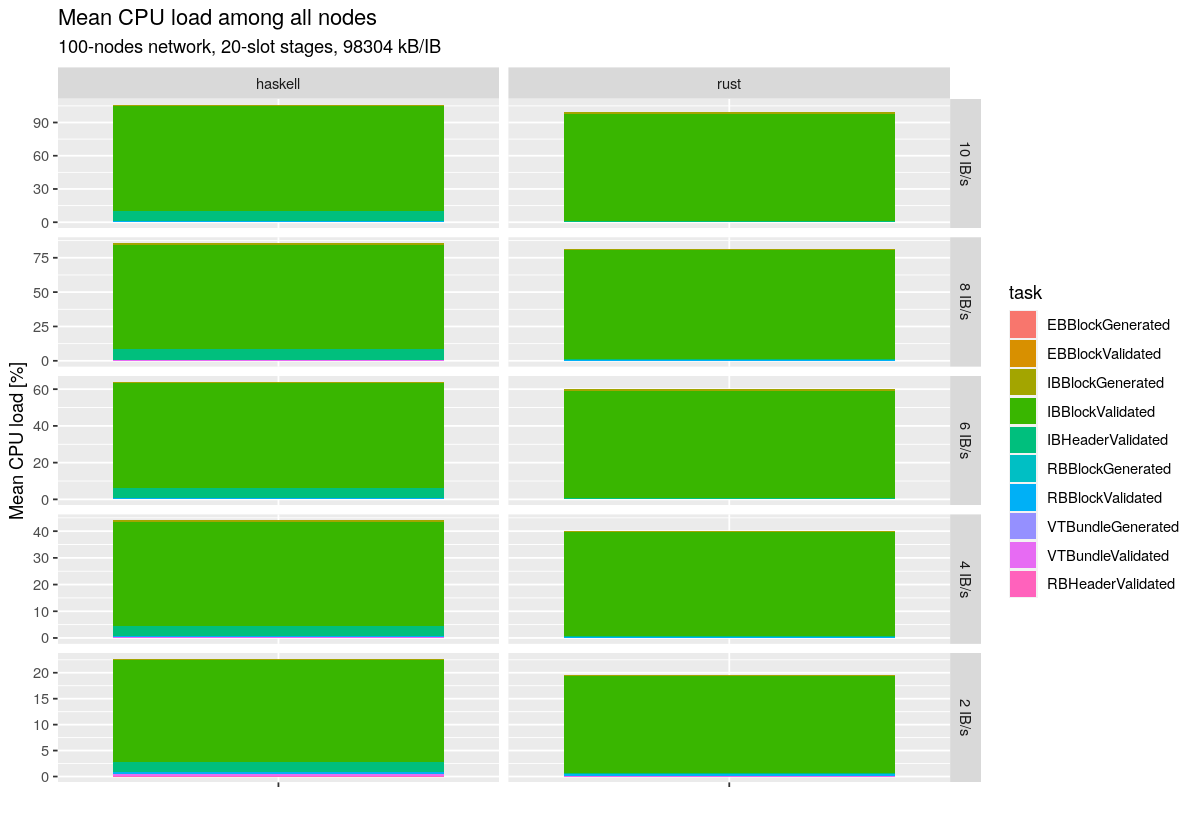

In [32]:
meanCpuHistogram(
    cpus[`ib-generation-probability` %in% ibRates],
    100 * 600, 
    "Mean CPU load among all nodes", scales="free_y",
    outfiles=paste0("plots/cpu-mean-histogram.png")
)

##### Time series

In [33]:
meanCpuTimeseries <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(
                `duration`=100*sum(`duration`)/nodeSeconds
            ),
            by=.(
                `simulator`,
                `ibRate`=mapply(ibRateFactor, `ib-generation-probability`),
                `slot`,
                `task`
            )
        ], 
        aes(x=`slot`, y=`duration`, color=`task`)
    ) +
        geom_point(size=0.25, alpha=0.75) +
        facet_grid(`ibRate` ~ `simulator`, scales=scales) +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

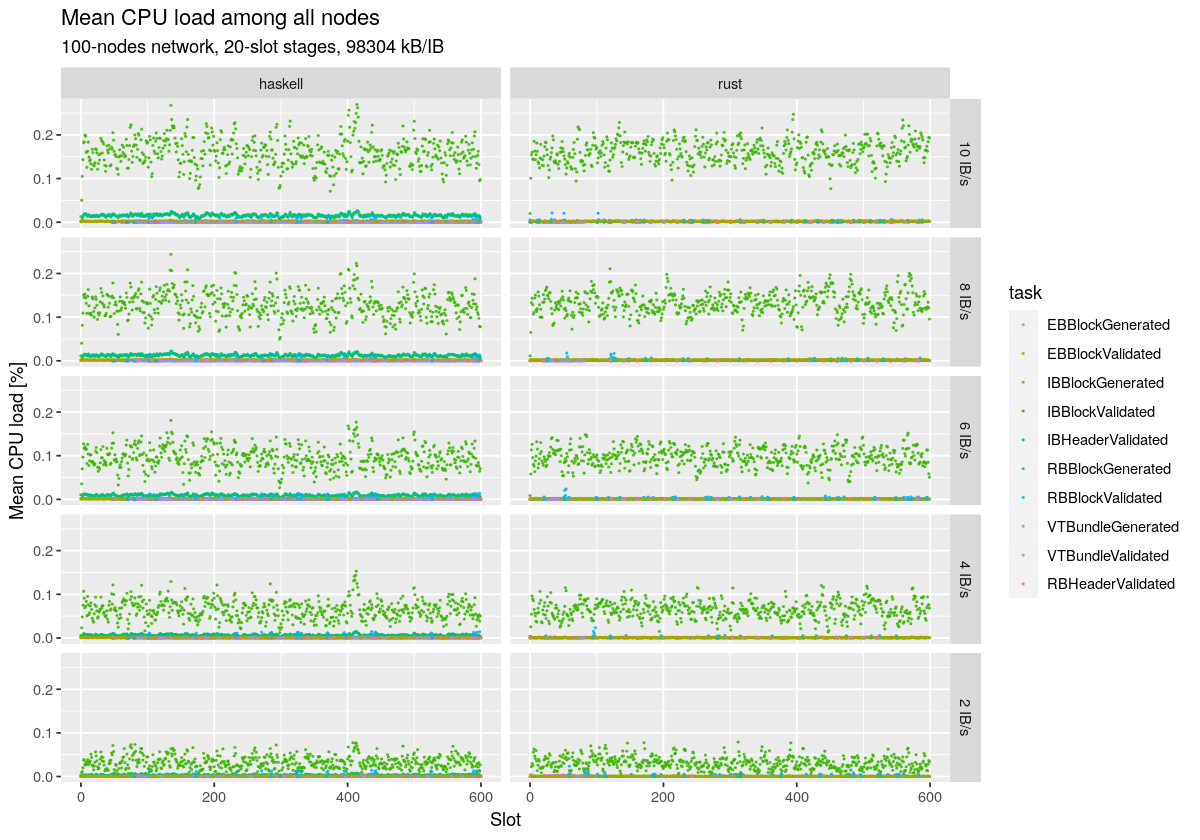

In [34]:
meanCpuTimeseries(
    cpus[`ib-generation-probability` %in% ibRates], 
    100 * 600, 
    "Mean CPU load among all nodes",
    outfiles=paste0("plots/cpu-mean-timeseries.png")
)

#### Fraction throttled

In [35]:
# TBD

#### Idle time

In [36]:
# TBD

### Input blocks

#### Read results

In [37]:
ibgen <- fread("results/ibgen.csv.gz", stringsAsFactors=TRUE)
ibgen %>% summary

   simulator         label             network       ib-generation-probability
 haskell:62492   default:124717   100-nodes:124717   Min.   : 1.000           
 rust   :62225                                       1st Qu.: 5.000           
                                                     Median : 7.500           
                                                     Mean   : 6.867           
                                                     3rd Qu.: 9.000           
                                                     Max.   :10.000           
                                                                              
 ib-body-avg-size-bytes eb-generation-probability leios-stage-length-slots
 Min.   :98304          Min.   :1.5               Min.   :20              
 1st Qu.:98304          1st Qu.:1.5               1st Qu.:20              
 Median :98304          Median :1.5               Median :20              
 Mean   :98304          Mean   :1.5               Mean   :20        

#### IB inculsion in EBs

##### Histogram

In [38]:
ibInclusionHistogram <- function(is, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        is[,
            .(
                `ibRate`=mapply(ibRateFactor, `ib-generation-probability`),
                `Number of EBs that include the IB`=`eb-count`
            ),
           .(`simulator`)
        ],
        aes(x=`Number of EBs that include the IB`)
    ) +
        geom_histogram(bins=5) +
        facet_grid(`ibRate` ~ `simulator`, scales=scales) +
      # coord_cartesian(xlim=c(0, 5)) +
        ylab("Number of IBs") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

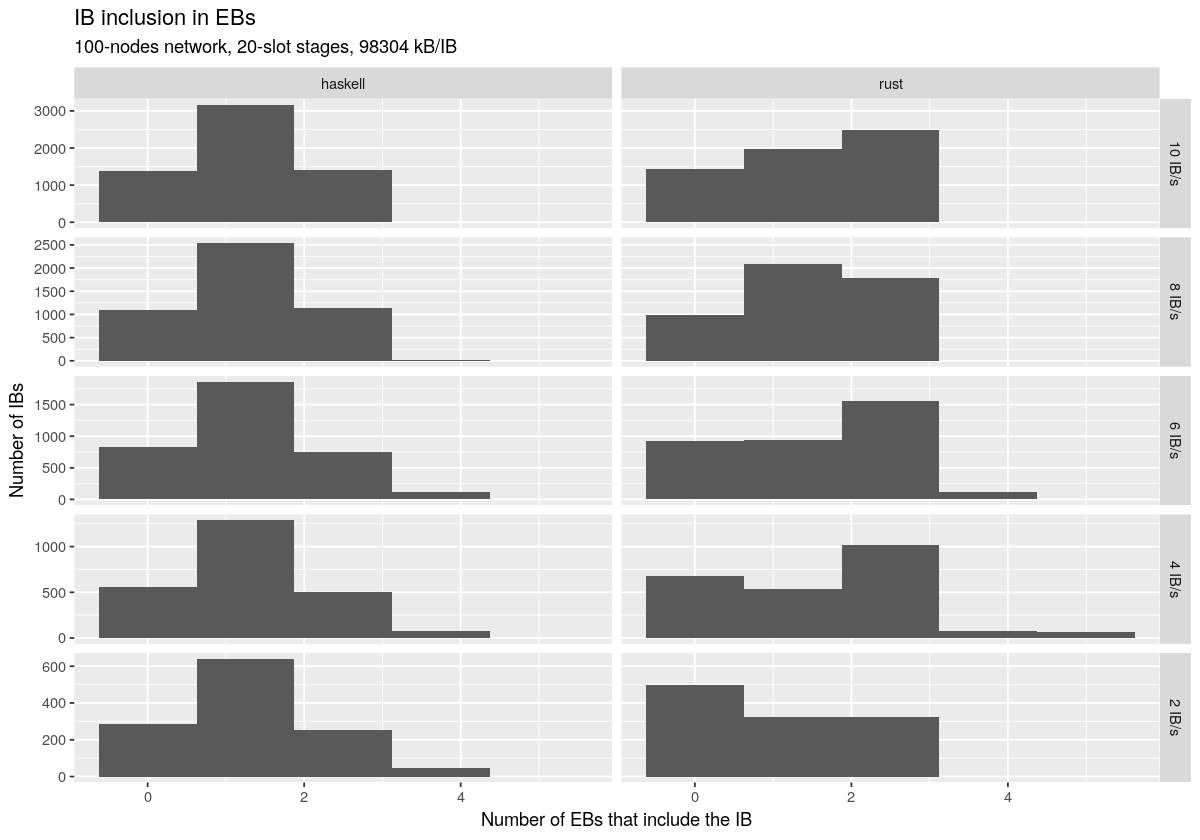

In [39]:
ibInclusionHistogram(
    ibgen[`ib-generation-probability` %in% ibRates], 
    "IB inclusion in EBs",
    scales="free_y",
    paste0("plots/ib-inclusion-ebs-histogram.png")
)

##### Time series

In [40]:
ibInclusionTimeseries <- function(is, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        is[,
            .(
                `ibRate`=mapply(ibRateFactor, `ib-generation-probability`),
                `Time of IB generation [s]`=`time`,
                `Number of EBs including the IB`=`eb-count`
            ),
           `simulator`
        ],
        aes(x=`Time of IB generation [s]`, y=`Number of EBs including the IB`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`ibRate` ~ `simulator`, scales=scales) +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

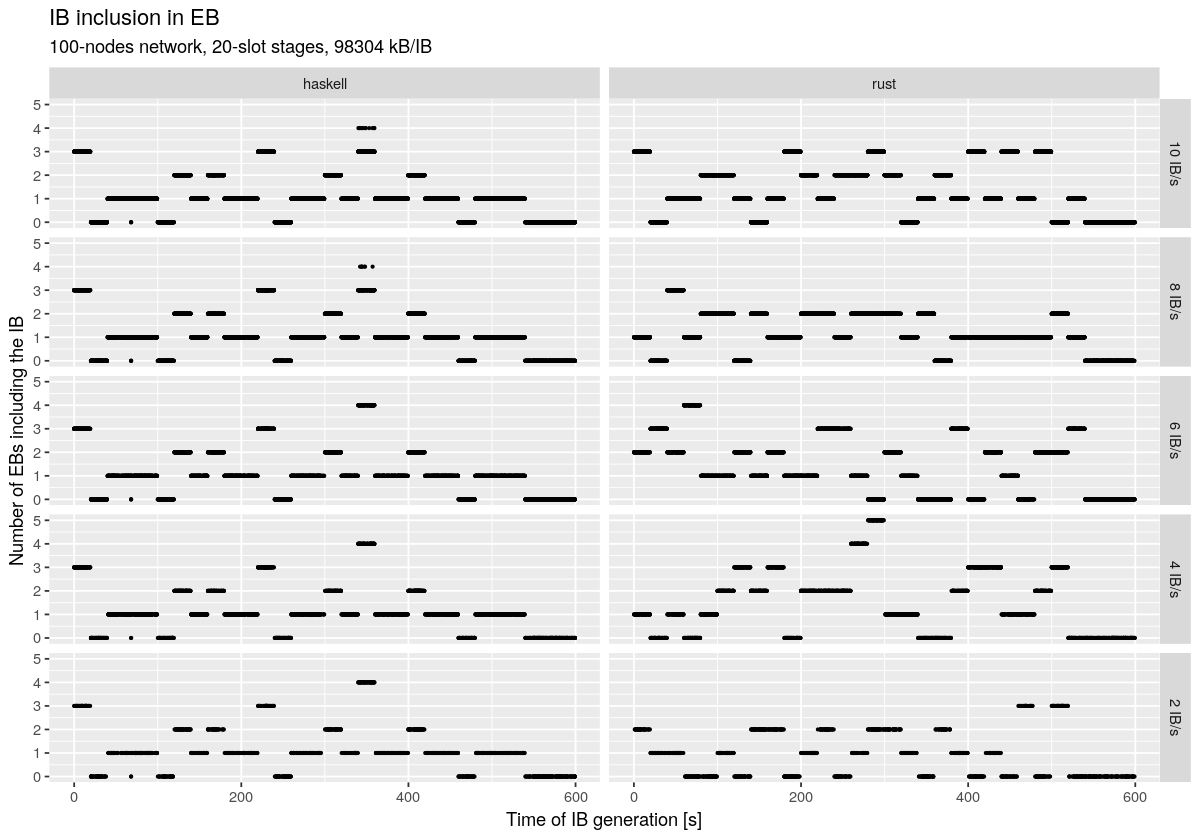

In [41]:
ibInclusionTimeseries(
    ibgen[`ib-generation-probability` %in% ibRates], 
    "IB inclusion in EB",
    outfiles=paste0("plots/ib-inclusion-ebs-timeseries.png")
)

#### IB size

In [42]:
ibSizeTimeseries <- function(is, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        is[,
            .(
                `ibRate`=mapply(ibRateFactor, `ib-generation-probability`),
                `Time of IB generation [s]`=`time`,
                `IB size [kB]`=`size`/1000
            ),
           `simulator`
    ],
    aes(x=`Time of IB generation [s]`, y=`IB size [kB]`)
) +
    geom_point(size=0.5) +
    facet_grid(`ibRate` ~ `simulator`, scales=scales) +
    ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

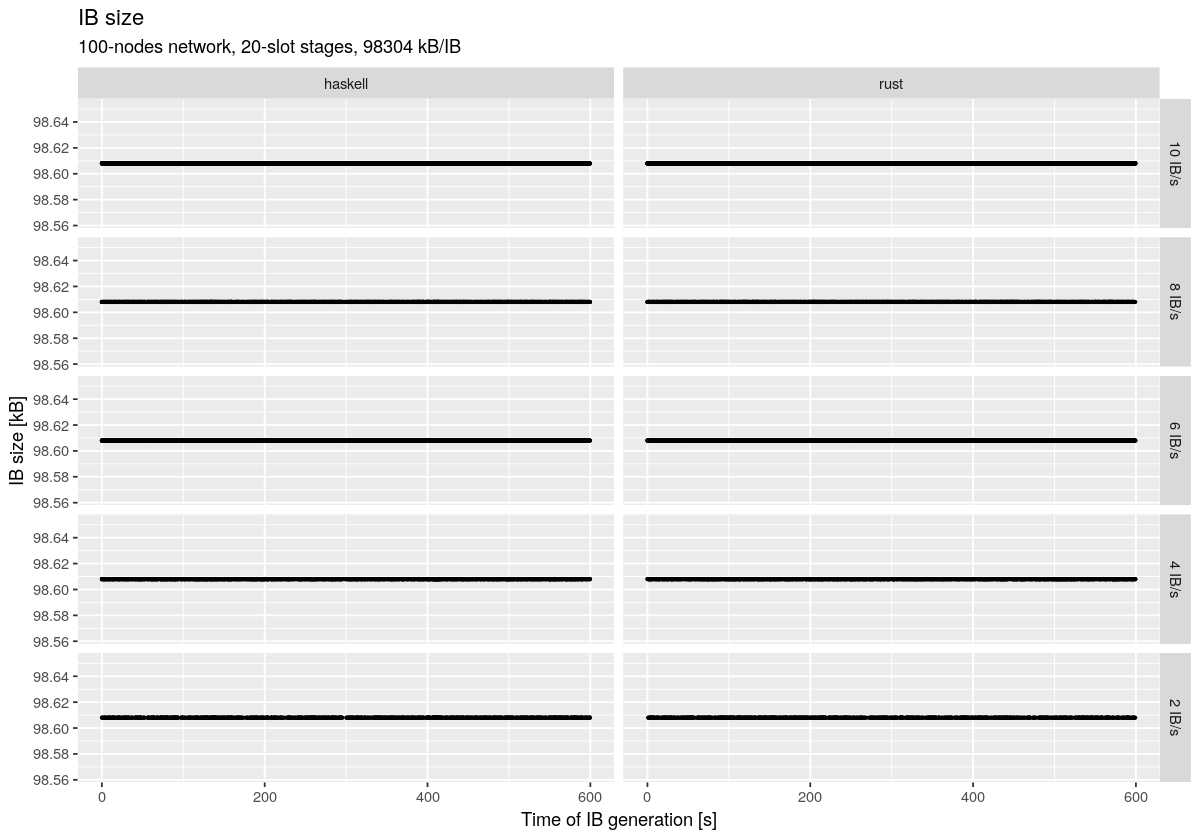

In [43]:
ibSizeTimeseries(
    ibgen[`ib-generation-probability` %in% ibRates], 
    "IB size",
    outfiles=paste0("plots/ib-size-timeseries.png")
)

### Endorser blocks

#### Read results

In [44]:
ebgen <- fread("results/ebgen.csv.gz", stringsAsFactors=TRUE)
ebgen %>% summary

   simulator       label           network     ib-generation-probability
 haskell:646   default:1519   100-nodes:1519   Min.   : 1.000           
 rust   :873                                   1st Qu.: 3.000           
                                               Median : 5.500           
                                               Mean   : 5.464           
                                               3rd Qu.: 8.000           
                                               Max.   :10.000           
                                                                        
 ib-body-avg-size-bytes eb-generation-probability leios-stage-length-slots
 Min.   :98304          Min.   :1.5               Min.   :20              
 1st Qu.:98304          1st Qu.:1.5               1st Qu.:20              
 Median :98304          Median :1.5               Median :20              
 Mean   :98304          Mean   :1.5               Mean   :20              
 3rd Qu.:98304          3rd Qu.:1.5      

#### EB inclusion in RBs

##### Histogram

In [45]:
ibsReferencedHistogram <- function(es, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        es[,
            .(
                `ibRate`=mapply(ibRateFactor, `ib-generation-probability`),
                `Number of IBs referenced by EB`=`ib-count`
            ),
           `simulator`
        ],
        aes(x=`Number of IBs referenced by EB`)
    ) +
        geom_histogram(bins=5) +
        facet_grid(`ibRate` ~ `simulator`, scales=scales) +
        ylab("Number of EBs") +
        ggtitle(title, subtitle=label) +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

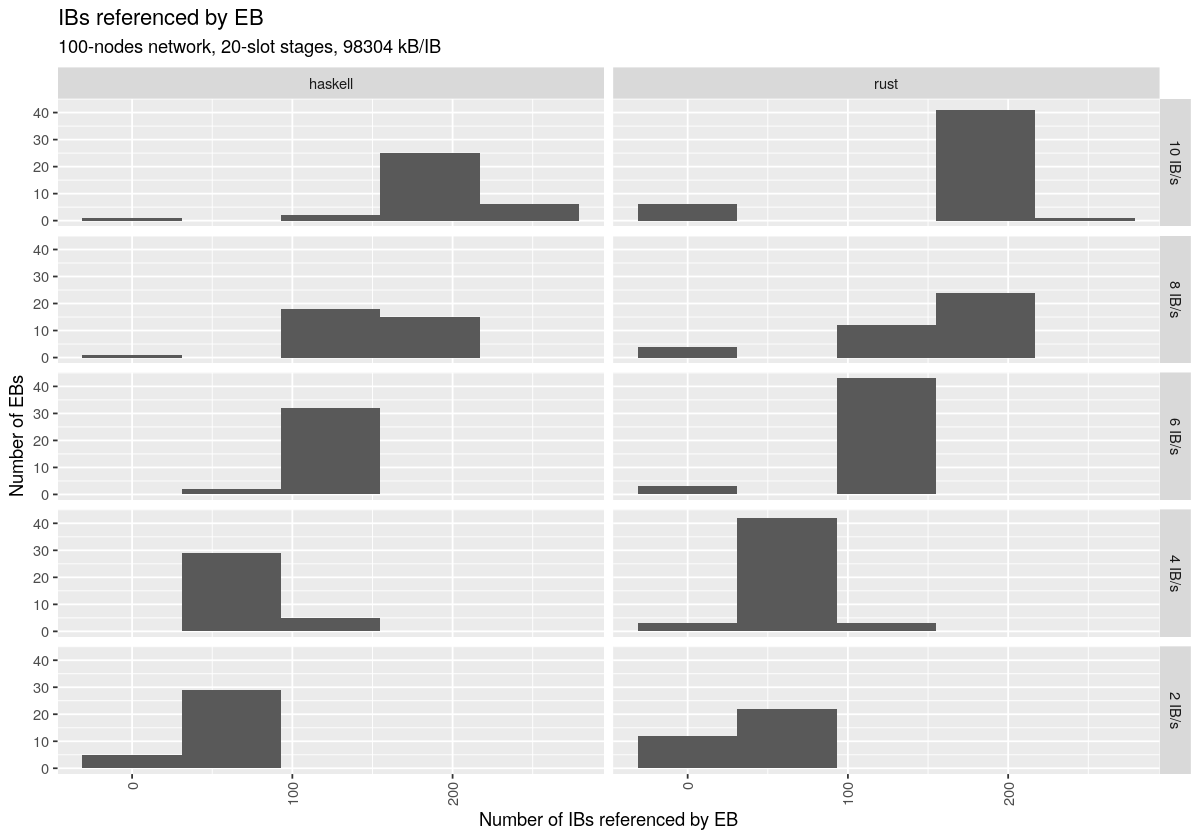

In [46]:
ibsReferencedHistogram(
    ebgen[`ib-generation-probability` %in% ibRates], 
    "IBs referenced by EB",
    outfiles=paste0("plots/ibs-referenced-eb-histogram.png")
)

##### Time series

In [47]:
ibsReferencedTimeseries <- function(es, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        es[,
            .(
                `ibRate`=mapply(ibRateFactor, `ib-generation-probability`),
                `Time of EB generation [s]`=`time`,
                `Number of IBs referenced by EB`=`ib-count`
            ),
           `simulator`
        ],
        aes(x=`Time of EB generation [s]`, y=`Number of IBs referenced by EB`)
    ) +
        geom_point(size=1.5) +
        facet_grid(`ibRate` ~ `simulator`, scales=scales) +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

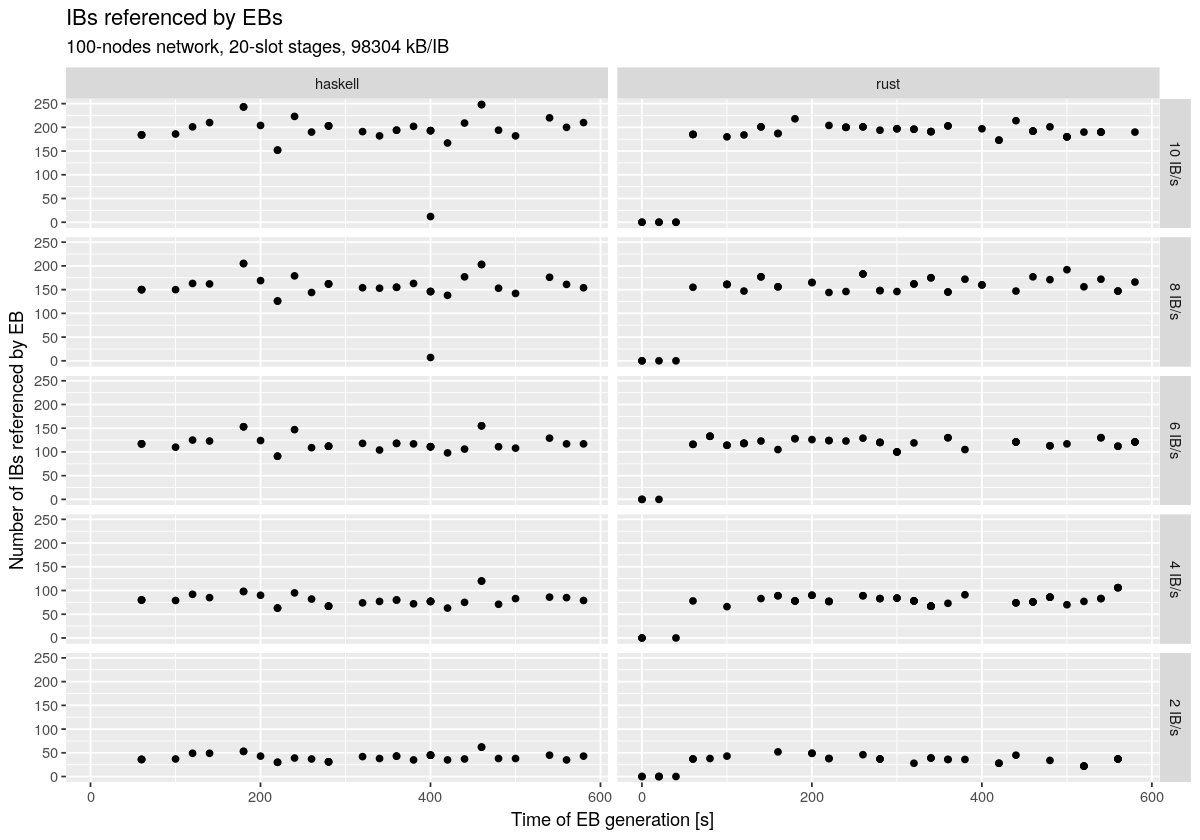

In [48]:
ibsReferencedTimeseries(
    ebgen[`ib-generation-probability` %in% ibRates], 
    "IBs referenced by EBs",
    outfiles=paste0("plots/ibs-referenced-ebs-timeseries.png")
)

#### EB inclusion in RBs

##### Histogram

In [49]:
ebInclusionHistogram <- function(es, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        es[,
            .(
                `ibRate`=mapply(ibRateFactor, `ib-generation-probability`),
                `Number of RBs that include the EB`=`rb-count`
            ),
           `simulator`
        ],
        aes(x=`Number of RBs that include the EB`)
    ) +
        geom_histogram(binwidth=1) +
        facet_grid(`ibRate` ~ `simulator`, scales=scales) +
      # coord_cartesian(xlim=c(0, 3)) +
        ylab("Number of EBs") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

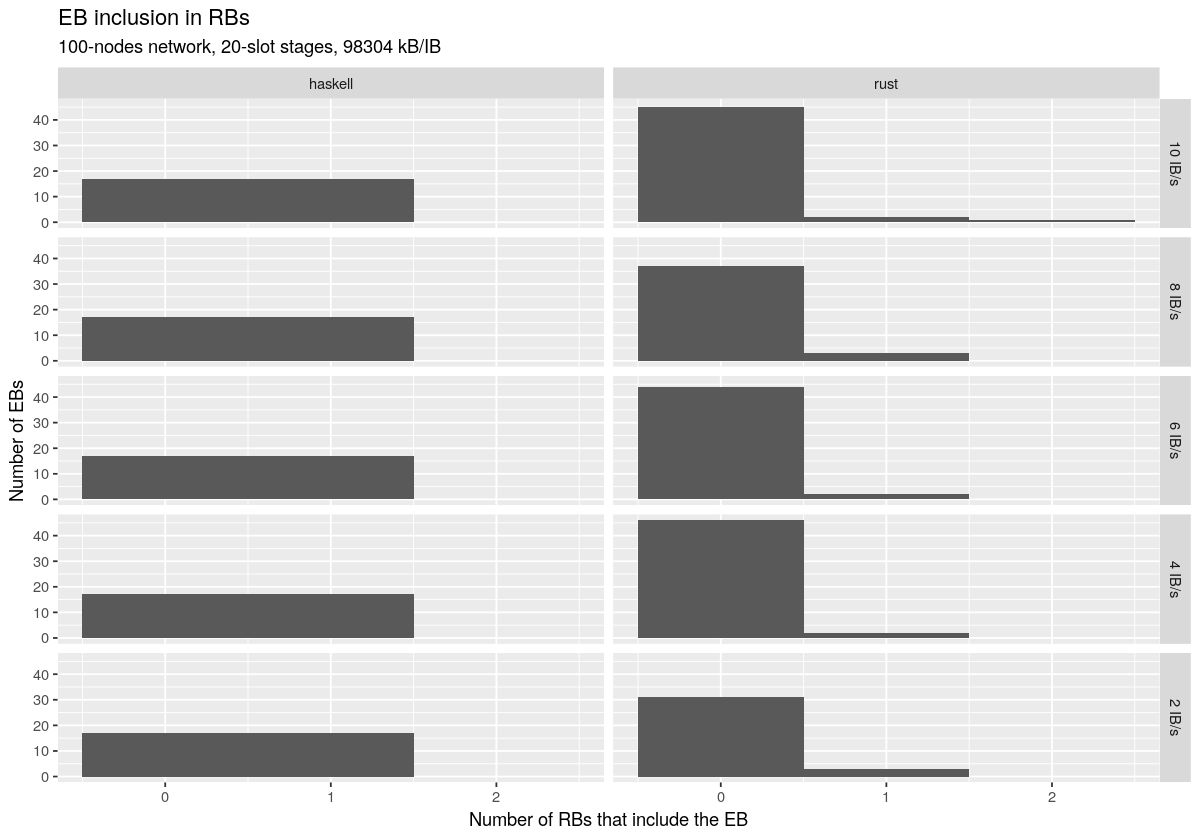

In [50]:
ebInclusionHistogram(
    ebgen[`ib-generation-probability` %in% ibRates], 
    "EB inclusion in RBs",
    outfiles=paste0("plots/eb-inclusion-rbs-histogram.png")
)

##### Time series

In [51]:
ebInclusionTimeseries <- function(es, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        es[,
            .(
                `ibRate`=mapply(ibRateFactor, `ib-generation-probability`),
                `Time of EB generation [s]`=`time`,
                `Number of RBs including the EB`=`rb-count`
            ),
           `simulator`
        ],
        aes(x=`Time of EB generation [s]`, y=`Number of RBs including the EB`)
    ) +
        geom_point(size=1.5) +
        facet_grid(`ibRate` ~ `simulator`, scales=scales) +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

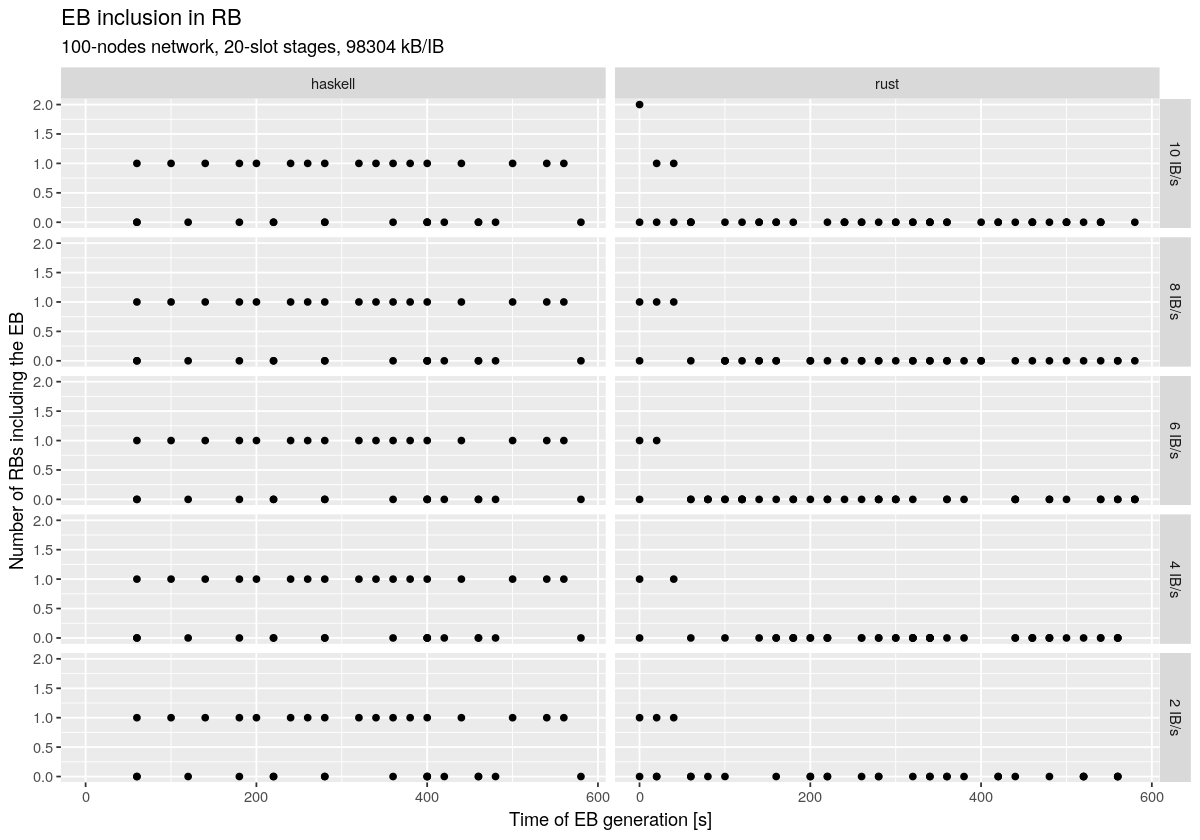

In [52]:
ebInclusionTimeseries(
    ebgen[`ib-generation-probability` %in% ibRates], 
    "EB inclusion in RB",
    outfiles=paste0("plots/eb-inclusion-rbs-timeseries.png")
)

#### EB size

In [53]:
ebSizeTimeseries <- function(es, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        es[,
            .(
                `ibRate`=mapply(ibRateFactor, `ib-generation-probability`),
                `Time of EB generation [s]`=`time`,
                `EB size [kB]`=`size`/1000
            ),
           `simulator`
        ],
        aes(x=`Time of EB generation [s]`, y=`EB size [kB]`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`ibRate` ~ `simulator`, scales=scales) +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

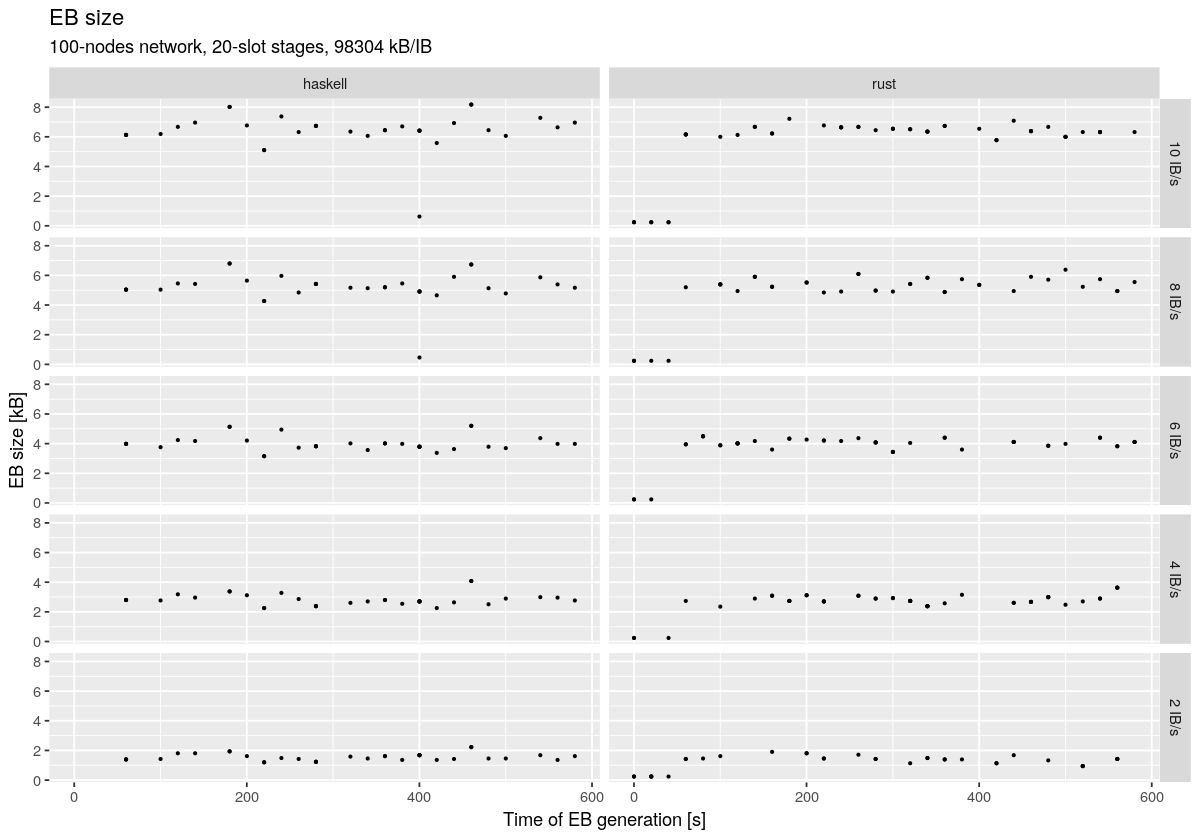

In [54]:
ebSizeTimeseries(
    ebgen[`ib-generation-probability` %in% ibRates], 
    "EB size",
    outfiles=paste0("plots/eb-size-timeseries.png")
)

In [55]:
ebSizeScatterplot <- function(es, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        es[,
            .(
                `ibRate`=mapply(ibRateFactor, `ib-generation-probability`),
                `Number of IBs referenced by the EB`=`ib-count`,
                `EB size [kB]`=`size`/1000
            ),
           `simulator`
        ],
        aes(x=`Number of IBs referenced by the EB`, y=`EB size [kB]`, color=`ibRate`)
    ) +
        geom_point(size=0.5) +
        facet_grid(. ~ `simulator`, scales=scales) +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

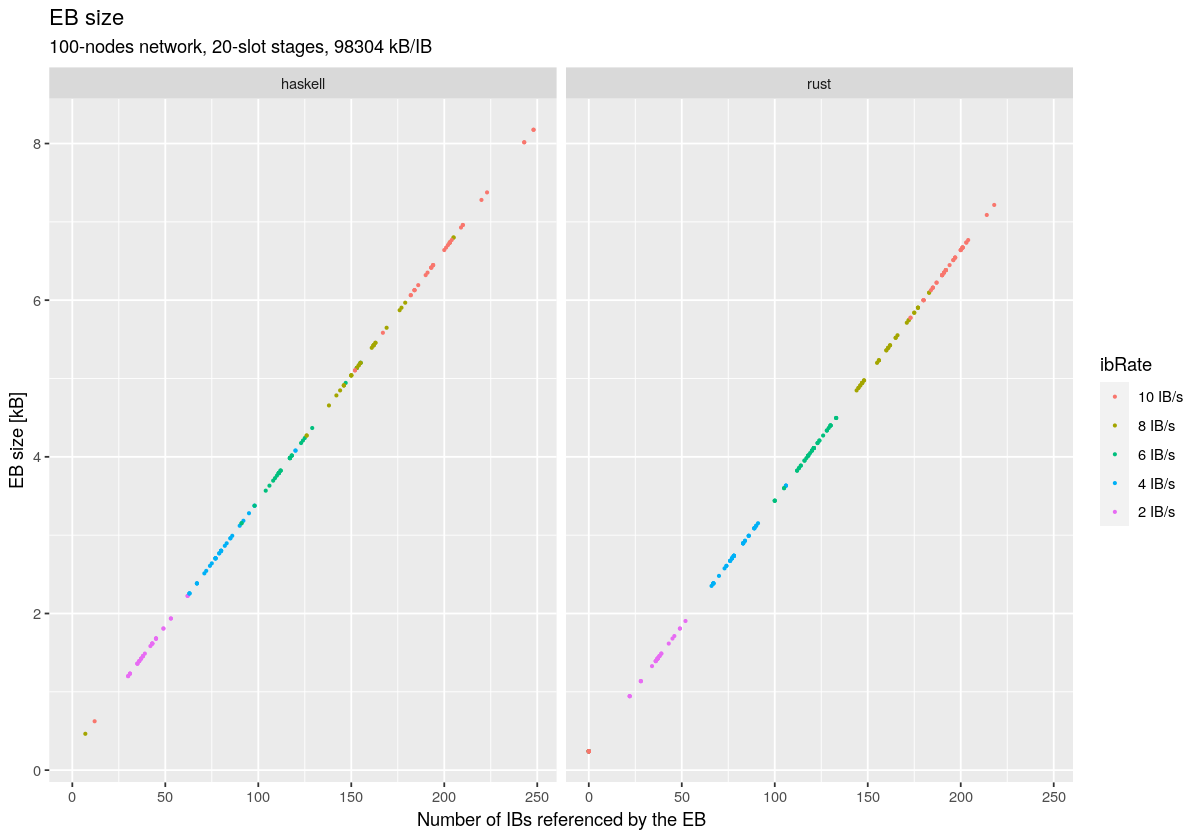

In [56]:
ebSizeScatterplot(
    ebgen[`ib-generation-probability` %in% ibRates], 
    "EB size",
    outfiles=paste0("plots/eb-size-scatterplot.png")
)

### Ranking blocks

#### Read results

In [57]:
rbgen <- fread("results/rbgen.csv.gz", stringsAsFactors=TRUE)
rbgen %>% summary

   simulator       label           network     ib-generation-probability
 haskell:437   default:1052   100-nodes:1052   Min.   : 1.000           
 rust   :615                                   1st Qu.: 3.000           
                                               Median : 5.750           
                                               Mean   : 5.604           
                                               3rd Qu.: 8.000           
                                               Max.   :10.000           
                                                                        
 ib-body-avg-size-bytes eb-generation-probability leios-stage-length-slots
 Min.   :98304          Min.   :1.5               Min.   :20              
 1st Qu.:98304          1st Qu.:1.5               1st Qu.:20              
 Median :98304          Median :1.5               Median :20              
 Mean   :98304          Mean   :1.5               Mean   :20              
 3rd Qu.:98304          3rd Qu.:1.5      

#### EB inclusion in RBs

##### Histogram

In [58]:
rbInclusionHistogram <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `ibRate`=mapply(ibRateFactor, `ib-generation-probability`),
                `Number of EBs referenced by RB`=`eb-count`
            ),
           `simulator`
        ],
        aes(x=`Number of EBs referenced by RB`)
    ) +
        geom_histogram(binwidth=1) +
        facet_grid(`ibRate` ~ `simulator`, scales=scales) +
      # coord_cartesian(xlim=c(0, 2)) +
        ylab("Number of RBs") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

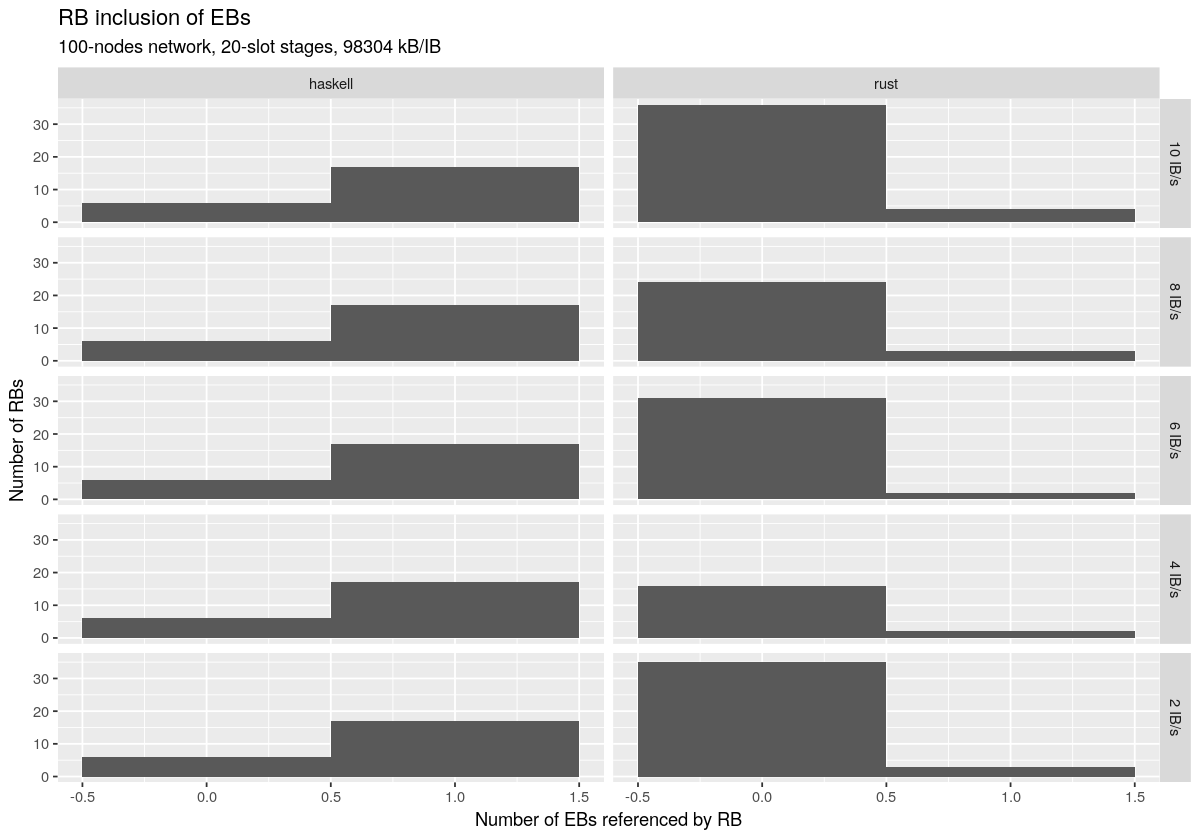

In [59]:
rbInclusionHistogram(
    rbgen[`ib-generation-probability` %in% ibRates], 
    "RB inclusion of EBs",
    outfiles=paste0("plots/ebs-referenced-rb-histogram.png")
)

##### Time series

In [60]:
rbInclusionTimeseries <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `ibRate`=mapply(ibRateFactor, `ib-generation-probability`),
                `Time of RB generation [s]`=`time`,
                `Number of EB referenced by RB`=`eb-count`
            ),
           `simulator`
        ],
        aes(x=`Time of RB generation [s]`, y=`Number of EB referenced by RB`)
    ) +
        geom_point(size=1.5) +
        facet_grid(`ibRate` ~ `simulator`, scales=scales) +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

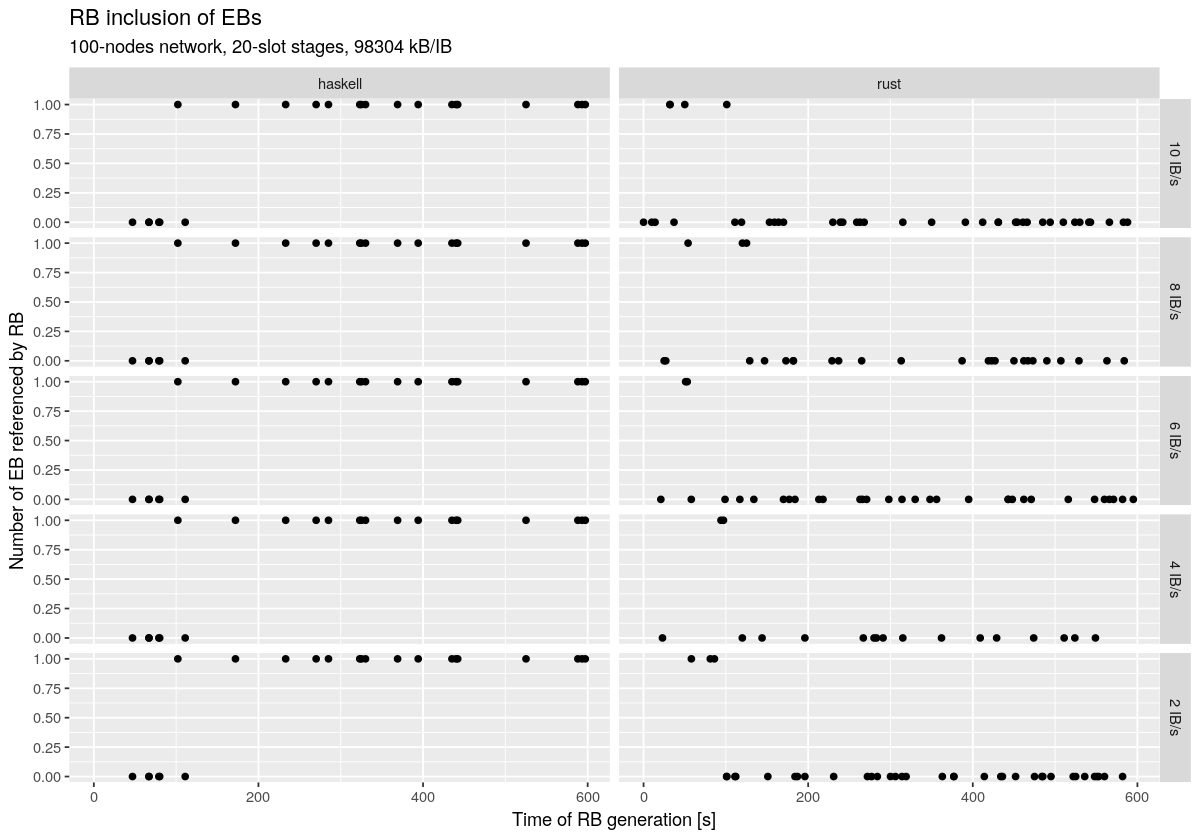

In [61]:
rbInclusionTimeseries(
    rbgen[`ib-generation-probability` %in% ibRates], 
    "RB inclusion of EBs",
    outfiles=paste0("plots/ebs-referenced-rb-timeseries.png")
)

#### RB size

In [62]:
rbSizeTimeseries <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `ibRate`=mapply(ibRateFactor, `ib-generation-probability`),
                `Time of RB generation [s]`=`time`,
                `RB size [kB]`=`size`/1000
            ),
           `simulator`
        ],
        aes(x=`Time of RB generation [s]`, y=`RB size [kB]`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`ibRate` ~ `simulator`, scales=scales) +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

Warning message:
“Removed 271 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 271 rows containing missing values (`geom_point()`).”


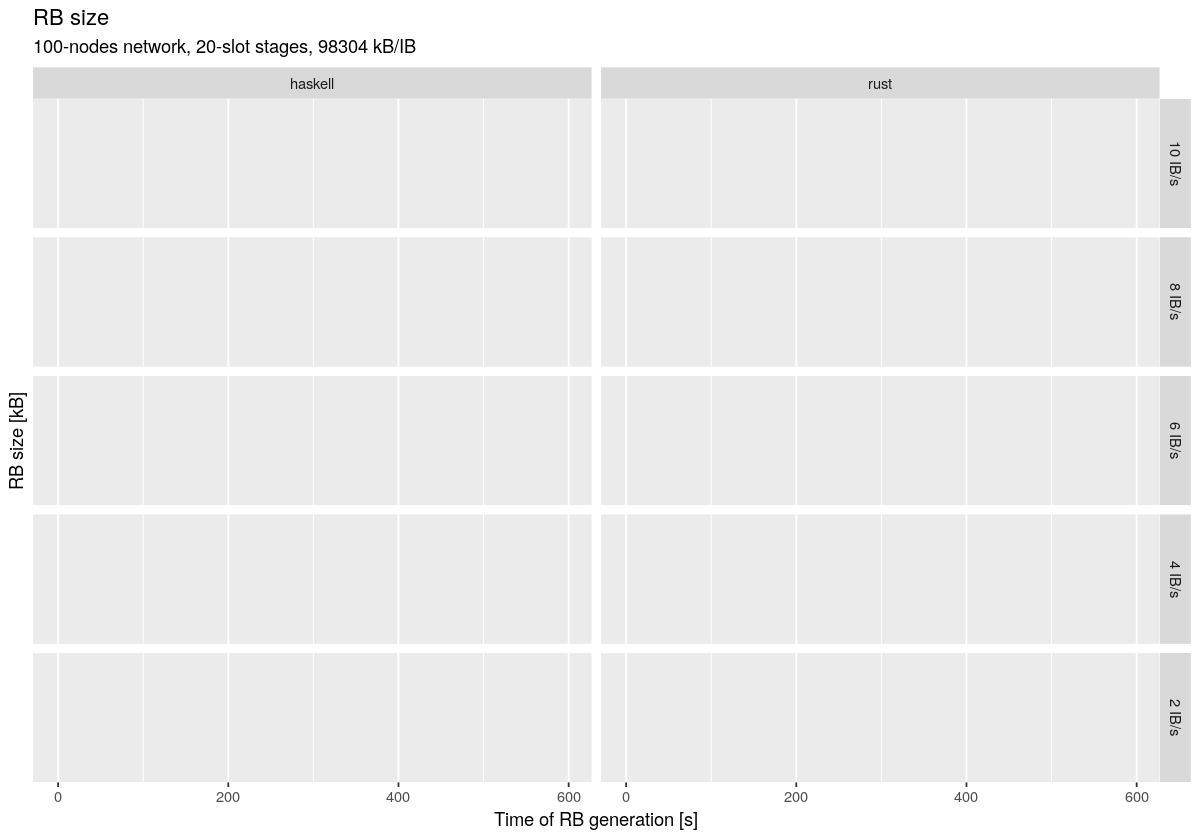

In [63]:
rbSizeTimeseries(
    rbgen[`ib-generation-probability` %in% ibRates], 
    "RB size",
    outfiles=paste0("plots/rb-size-histogram.png")
)

### Receipt of messages

#### Read results

In [64]:
if (file.exists("../2025w12xl/results/receipts.csv.gz")) {
    receipts <- fread("../2025w12xl/results/receipts.csv.gz", stringsAsFactors=TRUE)
} else {
    receipts <- data.table(mongo(url="mongodb://thelio", db="leios2025w12xl", collection="receipts")$find(), stringsAsFactors=TRUE)
    fwrite(receipts, "../2025w12xl/results/receipts.csv")
}
receipts %>% summary

#### Scenarios present in dataset

In [ ]:
receipts[, .(`Records`=.N), by=.(`simulator`, `network`, `label`)]

#### IB rate vs IB size vs stage length

##### Compare the distributions of elapsed times

In [ ]:
for (k in receipts[,unique(`kind`)%>%sort]) {
for (s in receipts[,unique(`simulator`)%>%sort]) {
for (l in c("default", "unoptimized")) {
    if (receipts[`simulator` == s & `label` == l & `kind` == k & !is.na(`received`) &`sent` <= 540, .N] == 0)
        next
    g <- ggplot(
        receipts[
            `simulator` == s & `label` == l & `kind` == k & !is.na(`received`) &`sent` <= 540,
            .(
                `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(receipts[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
                `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(receipts[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
                `elapsed`
            )
        ],
        aes(x=`elapsed`)
    ) +
        geom_histogram(binwidth=0.1) +
        facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
        coord_cartesian(xlim=c(0, 2)) +
        xlab("Time from generation to receipt at node [s]") +
        ylab("Number received") +
        ggtitle(paste("Arrival delay for", k), subtitle=paste0(s %>% str_to_title, " simulation (", l, " configuration) of realistic network, 60-slot stages"))
    print(g)
    ggsave(paste0("../2025w12xl/plots/elapsed-", k, "-", l, "-", s, ".png"), units="in", width=8, height=6, dpi=150)
    ggsave(paste0("../2025w12xl/plots/elapsed-", k, "-", l, "-", s, "-slide.png"), units="in", width=4.75, height=2.00, dpi=150)
}
}
}

#### Fraction of items arriving

In [ ]:
arrival <- receipts[
    `label` == "default" & !is.na(`received`) & `sent` <= 540,
    .(`received`=as.numeric(.N)),
    by=.(`simulator`, `label`, `ib-generation-probability`, `ib-body-avg-size-bytes`, `kind`, `sent`, `item`)
][,
    .(`total`=as.numeric(.N), `received`=sum(`received`)),
    by=.(`simulator`, `label`, `ib-generation-probability`, `ib-body-avg-size-bytes`, `kind`, `sent`)
][,
    .(`received`=sum(`received`)/sum(`total`)),
    by=.(`simulator`, `label`, `ib-generation-probability`, `ib-body-avg-size-bytes`, `kind`, `sent`)
]

In [ ]:
for (k in arrival[,unique(`kind`)%>%sort]) {
for (s in arrival[,unique(`simulator`)%>%sort]) {
    g <- ggplot(
        arrival[
            `simulator` == s & `kind` == k,
            .(
                `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(receipts[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
                `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(receipts[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
                `sent`,
                `received`
            )
        ], 
        aes(x=`sent`, y=`received`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`ibRate`  ~ `ibSize`) +
        xlab("Time of generation [s]") +
        ylab("Number of nodes receiving") +
        ggtitle(paste("Arrival fraction for", k), subtitle=paste(s %>% str_to_title, "simulation of realistic network"))
    print(g)
    ggsave(paste0("../2025w12xl/plots/arrival-", k, "-", s, ".png"), units="in", width=8, height=6, dpi=150)
    ggsave(paste0("../2025w12xl/plots/arrival-", k, "-", s, "-slide.png"), units="in", width=4.75, height=4.00, dpi=150)
}
}

#### Bandwidth usage

##### Total network bandwidth

In [ ]:
for (s in receipts[,unique(`simulator`)%>%sort]) {
    g <- ggplot(
        receipts[
            `simulator` == s & `label` == "default" & !is.na(`received`),
            .(
                `size`=sum(`size`)/1000000000
            ),
            by=.(
                `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(receipts[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
                `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(receipts[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
                `slot`=floor(`received`),
                `Message`=`kind`
            )
        ],
        aes(x=`slot`, y=`size`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`ibRate` ~ `ibSize`) +
        xlab("Slot [s]") +
        ylab("Total network ingress [GB/s]") +
        ggtitle("Total bandwidth", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
    print(g)
    ggsave(paste0("../2025w12xl/plots/ingress-total-area-", s, ".png"), units="in", width=8, height=6, dpi=150)
}

In [ ]:
receipts[`simulator` == "haskell" & `label` == "default" & !is.na(`received`)] %>% summary

In [ ]:
receipts[`simulator` == "rust" & `label` == "default" & !is.na(`received`)] %>% summary

In [ ]:
for (s in receipts[,unique(`simulator`)%>%sort]) {
    g <- ggplot(
        receipts[
            `simulator` == s & `label` == "default" & !is.na(`received`),
            .(
                `size`=sum(`size`)/1000000000
            ),
            by=.(
                `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(receipts[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
                `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(receipts[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
                `slot`=floor(`received`),
                `Message`=`kind`
            )
        ],
        aes(x=`slot`, y=`size`, color=`Message`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`ibRate` ~ `ibSize`) +
        scale_y_sqrt() + #limits=c(0, 0.8)) +
        xlab("Slot [s]") +
        ylab("Total network ingress [GB/s]") +
        ggtitle("Total bandwidth", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
    print(g)
    ggsave(paste0("../2025w12xl/plots/ingress-total-point-", s, ".png"), units="in", width=8, height=6, dpi=150)
}

##### Bandwidth usage per node

In [ ]:
for (s in receipts[,unique(`simulator`)%>%sort]) {
    g <- ggplot(
        receipts[
            `simulator` == s & `label` == "default" & !is.na(`received`),
            .(
                `size`=sum(`size`)/1000000 / 100
            ),
            by=.(
                `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(receipts[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
                `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(receipts[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
                `slot`=floor(`received`),
                `Message`=`kind`
            )
        ],
        aes(x=`slot`, y=`size`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
        scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Mean network ingress among nodes [MB/s]") +
        ggtitle("Mean nodal ingress", subtitle=paste(s %>% str_to_title, " simulation of realistic network, 60-slot stages"))
    print(g)
    ggsave(paste0("../2025w12xl/plots/ingress-average-area-", s, ".png"), units="in", width=8, height=6, dpi=150)
    ggsave(paste0("../2025w12xl/plots/ingress-average-area-", s, "-slide.png"), units="in", width=8.90, height=4.00, dpi=150)
}

In [ ]:
for (s in receipts[,unique(`simulator`)%>%sort]) {
    g <- ggplot(
        receipts[
            `simulator` == s & `label` == "default" & !is.na(`received`),
            .(
                `size`=sum(`size`)/1000000
            ),
            by=.(
                `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(receipts[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
                `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(receipts[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
                `slot`=floor(`received`),
                `Message`=`kind`,
                `recipient`
            )
        ][,
            .(`size`=max(`size`)),
            by=.(`ibRate`, `ibSize`, `slot`, `Message`)
        ],
        aes(x=`slot`, y=`size`, color=`Message`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`ibRate` ~ `ibSize`) +
        xlab("Slot [s]") +
        ylab("Maximum network ingress among nodes [MB/s]") +
        ggtitle("Peak nodal ingress", subtitle=paste(s %>% str_to_title, " simulation of realistic network, 60-slot stages"))
    print(g)
    ggsave(paste0("../2025w12xl/plots/ingress-peak-point-", s, ".png"), units="in", width=8, height=6, dpi=150)
}

### CPU usage

#### Read results

In [ ]:
if (file.exists("../2025w12xl/results/cpus.csv.gz")) {
    cpus <- fread("../2025w12xl/results/cpus.csv.gz", stringsAsFactors=TRUE)
} else {
    cpus <- data.table(mongo(url="mongodb://thelio", db="leios2025w12xl", collection="cpus")$find(), stringsAsFactors=TRUE)
    fwrite(cpus, "../2025w12xl/results/cpus.csv")
}
cpus %>% summary

In [ ]:
cpusNode <-
cpus[
    `slot` >= 60 & `slot` <= 540,
    .(
        `duration`=sum(`duration`)
    ),
    by=.(
        `simulator`,
        `ib-generation-probability`,
        `ib-body-avg-size-bytes`,
        `leios-stage-length-slots`,
        `node`,
        `slot`
    )
]

#### Peak CPU usage

##### Histogram

In [ ]:
for (s in cpusNode[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    cpusNode[
        `simulator` == s & `leios-stage-length-slots` == 60,
        .(
            `duration`=100*max(`duration`)
        ),
        by=.(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(cpusNode[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(cpusNode[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `slot`
        )
    ], 
    aes(x=`duration`)) +
    geom_histogram(binwidth=10) +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    coord_cartesian(xlim=c(0, 700)) +
    xlab("Peak CPU load [%]") +
    ylab("Number of slots") +
    ggtitle("Peak CPU load among all nodes", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
ggsave(paste0("../2025w12xl/plots/cpu-peak-histogram-", s, ".png"), units="in", width=8, height=6, dpi=150)
    
}

##### Time series

In [ ]:
for (s in cpus[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    cpusNode[
        `simulator` == s & `leios-stage-length-slots` == 60,
        .(
            `duration`=100*mean(`duration`)
        ),
        by=.(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(cpusNode[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(cpusNode[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `slot`
        )
    ], 
    aes(x=`slot`, y=`duration`)) +
    geom_line() +
    facet_grid(`ibRate` ~ `ibSize`, scale="free_y") +
    xlab("Slot") +
    ylab("Mean CPU load [%]") +
    ggtitle("Peak CPU load among all nodes", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
ggsave(paste0("../2025w12xl/plots/cpu-peak-timeseries-", s, ".png"), units="in", width=8, height=6, dpi=150)

}

#### Mean CPU usage

##### Histogram

In [ ]:
retask <- function(h) {
    if (h == "GenIB")
        "IBBlockGenerated"
    else if (h == "ValIH")
        "IBHeaderValidated"
    else if (h == "ValIB")
        "IBBlockValidated"
    else if (h == "GenEB")
        "EBBlockGenerated"
    else if (h =="ValEB")
        "EBBlockValidated"
    else if (h == "GenVote")
        "VTBundleGenerated"
    else if (h == "ValVote")
        "VTBundleValidated"
    else if (h == "GenRB")
        "RBBlockGenerated"
    else if (h == "ValRB")
        "RBBlockValidated"
    else if (h == "ValRH")
        "RBHeaderValidated"
    else
        h
}

In [ ]:
for (s in cpus[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    cpus[
        `simulator` == s & `leios-stage-length-slots` == 60,
        .(
            `duration`=100*mean(`duration`)
        ),
        by=.(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(cpusNode[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(cpusNode[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Task`=mapply(retask, `task`)
        )
    ], 
    aes(x="", fill=`Task`, y=`duration`)) +
    geom_bar(stat = "identity") +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    xlab("") +
    ylab("Mean CPU load [%]") +
    ggtitle("Mean CPU load among all nodes", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
ggsave(paste0("../2025w12xl/plots/cpu-mean-histogram-", s, ".png"), units="in", width=8, height=6, dpi=150)

}

##### Time series

In [ ]:
for (s in cpus[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    cpus[
        `simulator` == s & `leios-stage-length-slots` == 60,
        .(
            `duration`=100*mean(`duration`)
        ),
        by=.(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(cpusNode[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(cpusNode[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `slot`,
            `task`=mapply(retask, `task`)
        )
    ], 
    aes(x=`slot`, y=`duration`, color=`task`)) +
    geom_point(size=0.25, alpha=0.75) +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    xlab("Slot") +
    ylab("Mean CPU load [%]") +
    ggtitle("Mean CPU load among all nodes", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
ggsave(paste0("../2025w12xl/plots/cpu-mean-timeseries-", s, ".png"), units="in", width=8, height=6, dpi=150)

}

#### Fraction throttled

In [ ]:
# TBD

#### Idle time

In [ ]:
# TBD

### Input blocks

#### Read results

In [ ]:
if (file.exists("../2025w12xl/results/ibgen.csv.gz")) {
    ibgen <- fread("../2025w12xl/results/ibgen.csv.gz", stringsAsFactors=TRUE)
} else {
    ibgen <- data.table(mongo(url="mongodb://thelio", db="leios2025w12xl", collection="ibgen")$find(), stringsAsFactors=TRUE)
    fwrite(ibgen, "../2025w12xl/results/ibgen.csv")
}
ibgen %>% summary

#### IB inculsion in EBs

##### Histogram

In [ ]:
for (s in ibgen[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    ibgen[
        `simulator` == s & `leios-stage-length-slots` == 60 & time >= 60 & time <= 540,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ibgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ibgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Number of EBs that include the IB`=`eb-count`
        )
    ],
    aes(x=`Number of EBs that include the IB`)
) +
    geom_histogram(bins=5) +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    coord_cartesian(xlim=c(0, 5)) +
    ylab("Number of IBs") +
    ggtitle("IB inclusion in EBs", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
ggsave(paste0("../2025w12xl/plots/ib-inclusion-ebs-histogram-", s, ".png"), units="in", width=8, height=6, dpi=150)

}

##### Time series

In [ ]:
for (s in ibgen[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    ibgen[
        `simulator` == s & `leios-stage-length-slots` == 60 & time >= 60 & time <= 540,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ibgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ibgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of IB generation [s]`=`time`,
            `Number of EBs including the IB`=`eb-count`
        )
    ],
    aes(x=`Time of IB generation [s]`, y=`Number of EBs including the IB`)
) +
    geom_point(size=0.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("IB inclusion in EB", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
ggsave(paste0("../2025w12xl/plots/ib-inclusion-ebs-timeseries-", s, ".png"), units="in", width=8, height=6, dpi=150)

}

#### Time of IB inclusion in an EB

In [ ]:
for (s in ibgen[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    ibgen[
        `simulator` == s & `leios-stage-length-slots` == 60 & !is.na(`eb-first`) & time >= 60 & time <= 540,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ibgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ibgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of IB generation [s]`=`time`,
            `Time of IB inclusion in EB [s]`=`eb-first`
        )
    ],
    aes(x=`Time of IB generation [s]`, y=`Time of IB inclusion in EB [s]`)
) +
    geom_point(size=0.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("IB arrival in EB", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
ggsave(paste0("../2025w12xl/plots/ib-arrival-eb-timeseries-", s, ".png"), units="in", width=8, height=6, dpi=150)

}

#### IB size

In [ ]:
for (s in ibgen[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    ibgen[
        `simulator` == s & `leios-stage-length-slots` == 60,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ibgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ibgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of IB generation [s]`=`time`,
            `IB size [kB]`=`size`/1000
        )
    ],
    aes(x=`Time of IB generation [s]`, y=`IB size [kB]`)
) +
    geom_point(size=0.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("IB size", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
ggsave(paste0("../2025w12xl/plots/ib-size-timeseries-", s, ".png"), units="in", width=8, height=6, dpi=150)

}

### Endorser blocks

#### Read results

In [ ]:
if (file.exists("../2025w12xl/results/ebgen.csv.gz")) {
    ebgen <- fread("../2025w12xl/results/ebgen.csv.gz", stringsAsFactors=TRUE)
} else {
    ebgen <- data.table(mongo(url="mongodb://thelio", db="leios2025w12xl", collection="ebgen")$find(), stringsAsFactors=TRUE)
    fwrite(ebgen, "../2025w12xl/results/ebgen.csv")
}
ebgen %>% summary

#### EB inclusion in RBs

##### Histogram

In [ ]:
for (s in ebgen[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    ebgen[
        `simulator` == s & `leios-stage-length-slots` == 60 & time >= 60 & time <= 540,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Number of IBs referenced by EB`=`ib-count`
        )
    ],
    aes(x=`Number of IBs referenced by EB`)
) +
    geom_histogram(bins=5) +
    facet_wrap(`ibRate` ~ `ibSize`, scales="free_x") +
    ylab("Number of EBs") +
    ggtitle("IBs referenced by EB", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages")) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))
print(g)
ggsave(paste0("../2025w12xl/plots/ibs-referenced-eb-histogram-", s, ".png"), units="in", width=8, height=6, dpi=150)

}

##### Time series

In [ ]:
for (s in ebgen[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    ebgen[
        `simulator` == s & `leios-stage-length-slots` == 60 & time >= 60 & time <= 540,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of EB generation [s]`=`time`,
            `Number of IBs referenced by EB`=`ib-count`
        )
    ],
    aes(x=`Time of EB generation [s]`, y=`Number of IBs referenced by EB`)
) +
    geom_point(size=1.5) +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    ggtitle("IBs referenced by EBs", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
ggsave(paste0("../2025w12xl/plots/ibs-referenced-ebs-timeseries-", s, ".png"), units="in", width=8, height=6, dpi=150)

}

#### EB inclusion in RBs

##### Histogram

In [ ]:
for (s in ebgen[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    ebgen[
        `simulator` == s & `leios-stage-length-slots` == 60 & time >= 60 & time <= 540,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Number of RBs that include the EB`=`rb-count`
        )
    ],
    aes(x=`Number of RBs that include the EB`)
) +
    geom_histogram(binwidth=1) +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    coord_cartesian(xlim=c(0, 3)) +
    ylab("Number of EBs") +
    ggtitle("EB inclusion in RBs", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
ggsave(paste0("../2025w12xl/plots/eb-inclusion-rbs-histogram-", s, ".png"), units="in", width=8, height=6, dpi=150)

}

##### Time series

In [ ]:
for (s in ebgen[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    ebgen[
        `simulator` == s & `leios-stage-length-slots` == 60 & time >= 60 & time <= 540,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of EB generation [s]`=`time`,
            `Number of RBs including the EB`=`rb-count`
        )
    ],
    aes(x=`Time of EB generation [s]`, y=`Number of RBs including the EB`)
) +
    geom_point(size=1.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("EB inclusion in RB", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
ggsave(paste0("../2025w12xl/plots/eb-inclusion-rbs-timeseries-", s, ".png"), units="in", width=8, height=6, dpi=150)

}

#### Time of EB inclusion in an RB

In [ ]:
for (s in ebgen[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    ebgen[
        `simulator` == s & `leios-stage-length-slots` == 60 & `rb-count` > 0 & time >= 60 & time <= 540,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of EB generation [s]`=`time`,
            `Time of EB inclusion in RB [s]`=`rb-first`
        )
    ],
    aes(x=`Time of EB generation [s]`, y=`Time of EB inclusion in RB [s]`)
) +
    geom_point(size=1.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("EB arrival in RB", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
ggsave(paste0("../2025w12xl/plots/eb-arrival-rb-", s, ".png"), units="in", width=8, height=6, dpi=150)

}

#### EB size

In [ ]:
for (s in ebgen[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    ebgen[
        `simulator` == s & `leios-stage-length-slots` == 60 & time >= 60 & time <= 540,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of EB generation [s]`=`time`,
            `EB size [kB]`=`size`/1000
        )
    ],
    aes(x=`Time of EB generation [s]`, y=`EB size [kB]`)
) +
    geom_point(size=0.5) +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    ggtitle("EB size", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
ggsave(paste0("../2025w12xl/plots/eb-size-timeseries", s, ".png"), units="in", width=8, height=6, dpi=150)

}

In [ ]:
for (s in ebgen[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    ebgen[
        `simulator` == s & `leios-stage-length-slots` == 60,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Number of IBs referenced by the EB`=`ib-count`,
            `EB size [kB]`=`size`/1000
        )
    ],
    aes(x=`Number of IBs referenced by the EB`, y=`EB size [kB]`)
) +
    geom_point(size=0.5) +
    #facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("EB size", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
ggsave(paste0("../2025w12xl/plots/eb-size-scatterplot-", s, ".png"), units="in", width=8, height=6, dpi=150)
 
}

### Ranking blocks

#### Read results

In [ ]:
if (file.exists("../2025w12xl/results/rbgen.csv.gz")) {
    rbgen <- fread("../2025w12xl/results/rbgen.csv.gz", stringsAsFactors=TRUE)
} else {
    rbgen <- data.table(mongo(url="mongodb://thelio", db="leios2025w12xl", collection="rbgen")$find(), stringsAsFactors=TRUE)
    fwrite(rbgen, "../2025w12xl/results/rbgen.csv")
}
rbgen %>% summary

#### EB inclusion in RBs

##### Histogram

In [ ]:
for (s in rbgen[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    rbgen[
        `simulator` == s & `leios-stage-length-slots` == 60,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(rbgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(rbgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Number of EBs referenced by RB`=`eb-count`
        )
    ],
    aes(x=`Number of EBs referenced by RB`)
) +
    geom_histogram(binwidth=1) +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    coord_cartesian(xlim=c(0, 2)) +
    ylab("Number of RBs") +
    ggtitle("RB inclusion of EBs", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
ggsave(paste0("../2025w12xl/plots/ebs-referenced-rb-histogram-", s, ".png"), units="in", width=8, height=6, dpi=150)
    
}

##### Time series

In [ ]:
for (s in rbgen[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    rbgen[
        `simulator` == s & `leios-stage-length-slots` == 60,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(rbgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(rbgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of RB generation [s]`=`time`,
            `Number of EB referenced by RB`=`eb-count`
        )
    ],
    aes(x=`Time of RB generation [s]`, y=`Number of EB referenced by RB`)
) +
    geom_point(size=1.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("RB inclusion of EBs", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
ggsave(paste0("../2025w12xl/plots/ebs-referenced-rb-timeseries-", s, ".png"), units="in", width=8, height=6, dpi=150)
    
}

#### RB size

In [ ]:
for (s in rbgen[,unique(`simulator`)%>%sort]) {
if (s == "rust")
    next

g <- ggplot(
    rbgen[
        `simulator` == s & `leios-stage-length-slots` == 60,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(rbgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(rbgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of RB generation [s]`=`time`,
            `RB size [kB]`=`size`/1000
        )
    ],
    aes(x=`Time of RB generation [s]`, y=`RB size [kB]`)
) +
    geom_point(size=0.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("RB size", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
ggsave(paste0("../2025w12xl/plots/rb-size-histogram-", s, ".png"), units="in", width=8, height=6, dpi=150)
    
}